In [172]:
import time
import warnings
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error , make_scorer, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from catboost import CatBoostRegressor, Pool

# !pip install lightgbm -q
import lightgbm as lgbm
from lightgbm import Dataset

import optuna

# warnings.filterwarnings(action="ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore")

matplotlib.style.use("ggplot")
pd.set_option("display.max_rows", 30)
pd.options.mode.chained_assignment = None

# Загрузка данных

In [173]:
dataset_time_sorted = pd.read_csv('../tmp_data/dataset_with_new_features.csv', parse_dates=['reportts'])

In [174]:
dataset_time_sorted_BGU = dataset_time_sorted[dataset_time_sorted['acnum'] == 'VQ-BGU'].reset_index(drop=True)
dataset_time_sorted_BDU = dataset_time_sorted[dataset_time_sorted['acnum'] == 'VQ-BDU'].reset_index(drop=True)

drop_cols = ["reportts", "egtm", "acnum"]

X = dataset_time_sorted_BGU.drop(drop_cols, axis=1, errors="ignore")
y = dataset_time_sorted_BGU["egtm"]

# cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features = ['pos','dep', 'arr', 'part_of_day', 'season']

for col in cat_features:
    X[col] = X[col].astype('category')

random_state = 42

In [175]:
part_of_day_index = len(X.columns)-1
season_index = len(X.columns)-2

## BGU

In [176]:
encoder = LabelEncoder()
features_to_encode = ['dep', 'arr']
for col in features_to_encode:
    X[col] = encoder.fit_transform(X[col])

In [177]:
# Calculate the 95th and 98th percentiles of 'egtm'
lower_bound = dataset_time_sorted_BGU["egtm"].quantile(0.04)
upper_bound = dataset_time_sorted_BGU["egtm"].quantile(0.96)

# Filter the dataset to exclude outliers
filtered_dataset = dataset_time_sorted_BGU[(dataset_time_sorted_BGU["egtm"] >= lower_bound) & 
                                           (dataset_time_sorted_BGU["egtm"] <= upper_bound)]

X_filtered = filtered_dataset.drop(drop_cols, axis=1, errors="ignore")
y_filtered = filtered_dataset["egtm"]

# Convert categorical features
for col in cat_features:
    X_filtered[col] = X_filtered[col].astype('category')

# Encode categorical features
encoder = LabelEncoder()
for col in features_to_encode:
    X_filtered[col] = encoder.fit_transform(X_filtered[col])

In [178]:
X = X_filtered.copy()
y = y_filtered.copy()

In [63]:
def objective(trial,data=X,target=y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25,random_state=42)

    param = {
        'objective': "huber",
        'boosting_type': 'dart',
        'n_jobs': 1,
        'verbose': -1,
        'cat_feature': [0, 2, 3, part_of_day_index, season_index],
        'num_leaves': trial.suggest_int('num_leaves', 4, 30),
        'max_bin': trial.suggest_int('max_bin', 20, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        # НЕ работают с huber loss
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'alpha': trial.suggest_uniform('alpha', 0.1, 2.0)
    }
    
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)], callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds = model.predict(X_test)

    
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse


In [64]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=1000,
               n_jobs = -1,
               show_progress_bar=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-12 12:29:49,750] A new study created in memory with name: no-name-a168c344-2936-4cd8-8916-b1789fd976a5
Best trial: 1. Best value: 2.06692:   1%|      | 9/1000 [00:00<00:30, 32.58it/s]

[I 2024-06-12 12:29:49,927] Trial 0 finished with value: 10.784704591792211 and parameters: {'num_leaves': 10, 'max_bin': 74, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.18377726961393112, 'alpha': 0.8717941525258328}. Best is trial 0 with value: 10.784704591792211.
[I 2024-06-12 12:29:49,944] Trial 4 finished with value: 12.321193280886646 and parameters: {'num_leaves': 22, 'max_bin': 46, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.13982462445819535, 'alpha': 0.7489139457736217}. Best is trial 0 with value: 10.784704591792211.
[I 2024-06-12 12:29:49,963] Trial 2 finished with value: 11.521261716947608 and parameters: {'num_leaves': 22, 'max_bin': 301, 'max_depth': 3, 'min_data_in_leaf': 6, 'learning_rate': 0.0781967434886246, 'alpha': 1.709603518812822}. Best is trial 0 with value: 10.784704591792211.
[I 2024-06-12 12:29:49,972] Trial 7 finished with value: 14.938494413960294 and parameters: {'num_leaves': 11, 'max_bin': 260, 'max_depth': 8, 'min_data_in_

Best trial: 1. Best value: 2.06692:   2%|     | 16/1000 [00:00<00:31, 31.19it/s]

[I 2024-06-12 12:29:50,121] Trial 8 finished with value: 45.90256451399708 and parameters: {'num_leaves': 19, 'max_bin': 170, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.230653910533482, 'alpha': 0.3660987599946155}. Best is trial 1 with value: 2.066922562520849.
[I 2024-06-12 12:29:50,180] Trial 11 finished with value: 45.901012717412975 and parameters: {'num_leaves': 28, 'max_bin': 145, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.3240006741693234, 'alpha': 0.2893327594434653}. Best is trial 1 with value: 2.066922562520849.
[I 2024-06-12 12:29:50,241] Trial 16 finished with value: 45.913876363185544 and parameters: {'num_leaves': 5, 'max_bin': 197, 'max_depth': 5, 'min_data_in_leaf': 7, 'learning_rate': 0.7788317214619187, 'alpha': 0.21531634020099732}. Best is trial 1 with value: 2.066922562520849.
[I 2024-06-12 12:29:50,250] Trial 13 finished with value: 4.222324392639117 and parameters: {'num_leaves': 19, 'max_bin': 130, 'max_depth': 9, 'min_data_in_lea

Best trial: 17. Best value: 0.327494:   2%|   | 21/1000 [00:00<00:35, 27.21it/s]

[I 2024-06-12 12:29:50,407] Trial 18 finished with value: 45.922289750081234 and parameters: {'num_leaves': 28, 'max_bin': 387, 'max_depth': 6, 'min_data_in_leaf': 10, 'learning_rate': 0.9289689124329185, 'alpha': 1.2938155807208571}. Best is trial 1 with value: 2.066922562520849.
[I 2024-06-12 12:29:50,458] Trial 17 finished with value: 0.3274940531314324 and parameters: {'num_leaves': 30, 'max_bin': 391, 'max_depth': 6, 'min_data_in_leaf': 10, 'learning_rate': 0.8662622836352614, 'alpha': 1.2628825303975602}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,502] Trial 20 finished with value: 12.769903048005222 and parameters: {'num_leaves': 15, 'max_bin': 371, 'max_depth': 14, 'min_data_in_leaf': 10, 'learning_rate': 0.07069968382041275, 'alpha': 1.2378344061755362}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,533] Trial 22 finished with value: 10.080744377602345 and parameters: {'num_leaves': 14, 'max_bin': 99, 'max_depth': 5, 'min_

Best trial: 17. Best value: 0.327494:   3%|   | 28/1000 [00:01<00:33, 28.74it/s]

[I 2024-06-12 12:29:50,609] Trial 19 finished with value: 0.3445558142620727 and parameters: {'num_leaves': 30, 'max_bin': 384, 'max_depth': 14, 'min_data_in_leaf': 10, 'learning_rate': 0.9943373516352613, 'alpha': 1.2522793786245647}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,613] Trial 24 finished with value: 45.919611094164374 and parameters: {'num_leaves': 13, 'max_bin': 365, 'max_depth': 5, 'min_data_in_leaf': 10, 'learning_rate': 0.06779017352325313, 'alpha': 1.991338213099374}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,619] Trial 23 finished with value: 11.04621391332219 and parameters: {'num_leaves': 12, 'max_bin': 343, 'max_depth': 5, 'min_data_in_leaf': 10, 'learning_rate': 0.07926032767112118, 'alpha': 1.894167456468005}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,692] Trial 25 finished with value: 11.496252361812 and parameters: {'num_leaves': 11, 'max_bin': 283, 'max_depth': 12, 'min_d

Best trial: 17. Best value: 0.327494:   3%|   | 34/1000 [00:01<00:35, 26.95it/s]

[I 2024-06-12 12:29:50,797] Trial 29 finished with value: 45.94847594595387 and parameters: {'num_leaves': 8, 'max_bin': 296, 'max_depth': 4, 'min_data_in_leaf': 9, 'learning_rate': 0.4987689057501361, 'alpha': 0.5806371066324884}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,883] Trial 32 finished with value: 46.015932048950646 and parameters: {'num_leaves': 25, 'max_bin': 320, 'max_depth': 3, 'min_data_in_leaf': 9, 'learning_rate': 0.5303702123727506, 'alpha': 0.9896929690262215}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,949] Trial 31 finished with value: 46.018206290000705 and parameters: {'num_leaves': 25, 'max_bin': 288, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.5032591720547966, 'alpha': 0.9733181910056303}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:50,961] Trial 33 finished with value: 2.051951983860349 and parameters: {'num_leaves': 26, 'max_bin': 337, 'max_depth': 4, 'min_data

[I 2024-06-12 12:29:51,100] Trial 37 finished with value: 45.974977343062186 and parameters: {'num_leaves': 25, 'max_bin': 260, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.9470213516123148, 'alpha': 1.1118333250066417}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:51,142] Trial 35 finished with value: 0.35455630673360194 and parameters: {'num_leaves': 25, 'max_bin': 253, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.9924197079168507, 'alpha': 1.4838761143598211}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:51,149] Trial 38 finished with value: 0.39208509369098876 and parameters: {'num_leaves': 8, 'max_bin': 345, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.9881112201311791, 'alpha': 0.8586911097909512}. Best is trial 17 with value: 0.3274940531314324.
[I 2024-06-12 12:29:51,172] Trial 36 finished with value: 0.35638017562150304 and parameters: {'num_leaves': 25, 'max_bin': 265, 'max_depth': 7, 'min_

Best trial: 41. Best value: 0.287244:   5%|▏  | 46/1000 [00:01<00:37, 25.75it/s]

[I 2024-06-12 12:29:51,304] Trial 40 finished with value: 0.34455115687147103 and parameters: {'num_leaves': 28, 'max_bin': 351, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.9933727727736955, 'alpha': 1.4451116610966708}. Best is trial 39 with value: 0.30073410775441.
[I 2024-06-12 12:29:51,352] Trial 42 finished with value: 0.3246435783900016 and parameters: {'num_leaves': 27, 'max_bin': 251, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.9787036961740873, 'alpha': 1.461958412969244}. Best is trial 39 with value: 0.30073410775441.
[I 2024-06-12 12:29:51,358] Trial 41 finished with value: 0.2872442964066424 and parameters: {'num_leaves': 25, 'max_bin': 355, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.7201027126598446, 'alpha': 1.4632387166686744}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:51,402] Trial 43 finished with value: 46.00675076160487 and parameters: {'num_leaves': 27, 'max_bin': 355, 'max_depth': 6, 'min_data_in

Best trial: 41. Best value: 0.287244:   5%|▏  | 51/1000 [00:01<00:38, 24.84it/s]

[I 2024-06-12 12:29:51,550] Trial 46 finished with value: 1.7004467426239163 and parameters: {'num_leaves': 29, 'max_bin': 232, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.3657643986627176, 'alpha': 1.5630440312878857}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:51,566] Trial 47 finished with value: 45.975731596302154 and parameters: {'num_leaves': 23, 'max_bin': 362, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.35953961662249145, 'alpha': 1.5781186218327932}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:51,620] Trial 51 finished with value: 45.94011675113263 and parameters: {'num_leaves': 23, 'max_bin': 22, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.3795068702564791, 'alpha': 1.6076730577575917}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:51,653] Trial 48 finished with value: 2.1179640167679374 and parameters: {'num_leaves': 29, 'max_bin': 360, 'max_depth': 6, 'min_dat

Best trial: 41. Best value: 0.287244:   6%|▏  | 56/1000 [00:02<00:40, 23.40it/s]

[I 2024-06-12 12:29:51,771] Trial 52 finished with value: 45.98390776932067 and parameters: {'num_leaves': 23, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.6539710774381521, 'alpha': 1.5877349426060285}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:51,791] Trial 53 finished with value: 45.966026714739485 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.7035362262622042, 'alpha': 1.5854241704532896}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:51,902] Trial 56 finished with value: 45.923468316624145 and parameters: {'num_leaves': 20, 'max_bin': 303, 'max_depth': 8, 'min_data_in_leaf': 5, 'learning_rate': 0.6961104869639485, 'alpha': 1.7777798971645975}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:51,917] Trial 54 finished with value: 0.28978745146442436 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 8, 'min_da

Best trial: 41. Best value: 0.287244:   6%|▏  | 60/1000 [00:02<00:38, 24.44it/s]

[I 2024-06-12 12:29:52,012] Trial 57 finished with value: 0.29228055606475495 and parameters: {'num_leaves': 20, 'max_bin': 399, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.7088136740850275, 'alpha': 1.7512219652172765}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:52,024] Trial 58 finished with value: 45.978877376100506 and parameters: {'num_leaves': 30, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 1, 'learning_rate': 0.7123337664824754, 'alpha': 1.3476200094416544}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:52,161] Trial 60 finished with value: 0.302480690026992 and parameters: {'num_leaves': 30, 'max_bin': 379, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7891402349047832, 'alpha': 1.3740346992476151}. Best is trial 41 with value: 0.2872442964066424.
[I 2024-06-12 12:29:52,201] Trial 59 finished with value: 0.3129991467635763 and parameters: {'num_leaves': 30, 'max_bin': 387, 'max_depth': 8, 'min_d

[I 2024-06-12 12:29:52,226] Trial 61 finished with value: 0.2860398754582251 and parameters: {'num_leaves': 30, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.8077062984898286, 'alpha': 1.355371573778589}. Best is trial 61 with value: 0.2860398754582251.
[I 2024-06-12 12:29:52,257] Trial 62 finished with value: 0.3025238790330732 and parameters: {'num_leaves': 30, 'max_bin': 377, 'max_depth': 5, 'min_data_in_leaf': 1, 'learning_rate': 0.8275740979132692, 'alpha': 1.3610254971668383}. Best is trial 61 with value: 0.2860398754582251.
[I 2024-06-12 12:29:52,271] Trial 63 finished with value: 0.33622624311914995 and parameters: {'num_leaves': 19, 'max_bin': 372, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.817484066275113, 'alpha': 1.781021361457395}. Best is trial 61 with value: 0.2860398754582251.
[I 2024-06-12 12:29:52,304] Trial 64 finished with value: 0.32944308410069867 and parameters: {'num_leaves': 21, 'max_bin': 375, 'max_depth': 10, 'min_d

Best trial: 66. Best value: 0.279792:   7%|▏  | 71/1000 [00:02<00:46, 20.06it/s]

[I 2024-06-12 12:29:52,429] Trial 66 finished with value: 0.27979232491000633 and parameters: {'num_leaves': 20, 'max_bin': 376, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.6224743949333144, 'alpha': 1.7702961313207544}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,481] Trial 67 finished with value: 2.6990801094384866 and parameters: {'num_leaves': 20, 'max_bin': 380, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.27712123328368526, 'alpha': 1.8267415008450574}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,569] Trial 68 finished with value: 0.3334657287268979 and parameters: {'num_leaves': 21, 'max_bin': 377, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.8003114148032765, 'alpha': 1.7398292071402603}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,588] Trial 69 finished with value: 0.31039558215953267 and parameters: {'num_leaves': 20, 'max_bin': 380, 'max_depth': 1

Best trial: 66. Best value: 0.279792:   8%|▏  | 75/1000 [00:03<00:37, 24.62it/s]

[I 2024-06-12 12:29:52,651] Trial 73 finished with value: 3.2727095510822157 and parameters: {'num_leaves': 17, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.28584328974420636, 'alpha': 1.6433512559689434}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,681] Trial 72 finished with value: 0.2845897416188013 and parameters: {'num_leaves': 17, 'max_bin': 399, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.6183663322215066, 'alpha': 1.7241645851999112}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,746] Trial 74 finished with value: 45.974711849144505 and parameters: {'num_leaves': 17, 'max_bin': 399, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.590990189341766, 'alpha': 1.7269777532002621}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,856] Trial 75 finished with value: 0.29108728640179476 and parameters: {'num_leaves': 18, 'max_bin': 398, 'max_depth': 11,

Best trial: 66. Best value: 0.279792:   8%|▏  | 82/1000 [00:03<00:39, 23.35it/s]

[I 2024-06-12 12:29:52,930] Trial 76 finished with value: 0.30434798921877837 and parameters: {'num_leaves': 17, 'max_bin': 303, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5932549695076711, 'alpha': 1.6525602611382257}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,931] Trial 77 finished with value: 0.2802314037598088 and parameters: {'num_leaves': 17, 'max_bin': 400, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6144580835208847, 'alpha': 1.6801994980046642}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,958] Trial 78 finished with value: 0.3077539534321061 and parameters: {'num_leaves': 17, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.5782732367062218, 'alpha': 1.6677484211342335}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:52,993] Trial 79 finished with value: 0.46511535252814207 and parameters: {'num_leaves': 18, 'max_bin': 398, 'max_depth': 11,

Best trial: 66. Best value: 0.279792:   9%|▎  | 87/1000 [00:03<00:41, 21.89it/s]

[I 2024-06-12 12:29:53,201] Trial 83 finished with value: 0.40434660990787225 and parameters: {'num_leaves': 15, 'max_bin': 399, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.45469828854849276, 'alpha': 1.9757440198612808}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,252] Trial 85 finished with value: 45.98480521288136 and parameters: {'num_leaves': 18, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.4471371460089764, 'alpha': 1.8414188561684695}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,308] Trial 84 finished with value: 0.42699714768161445 and parameters: {'num_leaves': 18, 'max_bin': 399, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.4412600389356827, 'alpha': 1.9947783835257464}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,332] Trial 87 finished with value: 0.4107033835856026 and parameters: {'num_leaves': 15, 'max_bin': 387, 'max_depth': 13

Best trial: 66. Best value: 0.279792:   9%|▎  | 92/1000 [00:03<00:36, 24.92it/s]

[I 2024-06-12 12:29:53,411] Trial 88 finished with value: 0.4230903471321235 and parameters: {'num_leaves': 15, 'max_bin': 387, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.4508275469739935, 'alpha': 1.9228957069371362}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,421] Trial 89 finished with value: 0.4464508843002842 and parameters: {'num_leaves': 15, 'max_bin': 368, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.43870883507070113, 'alpha': 1.9620166099643963}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,445] Trial 90 finished with value: 0.5316261309560995 and parameters: {'num_leaves': 15, 'max_bin': 348, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.42183930963845795, 'alpha': 1.8363098117812156}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,531] Trial 91 finished with value: 0.4932196538536993 and parameters: {'num_leaves': 15, 'max_bin': 368, 'max_depth': 12

[I 2024-06-12 12:29:53,634] Trial 93 finished with value: 14.539561443930232 and parameters: {'num_leaves': 16, 'max_bin': 369, 'max_depth': 13, 'min_data_in_leaf': 2, 'learning_rate': 0.012732588768261856, 'alpha': 1.5135572049995047}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,657] Trial 95 finished with value: 14.58126348323107 and parameters: {'num_leaves': 16, 'max_bin': 347, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.01158410310922049, 'alpha': 1.5206135831010172}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,670] Trial 94 finished with value: 9.081534456761375 and parameters: {'num_leaves': 16, 'max_bin': 347, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.11466542358488102, 'alpha': 1.9325216142371446}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,738] Trial 98 finished with value: 6.145805887798878 and parameters: {'num_leaves': 16, 'max_bin': 184, 'max_depth': 9, 'm

Best trial: 66. Best value: 0.279792:  10%|▏ | 103/1000 [00:04<00:38, 23.56it/s]

[I 2024-06-12 12:29:53,834] Trial 100 finished with value: 45.9853235122072 and parameters: {'num_leaves': 16, 'max_bin': 333, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.5315215315681641, 'alpha': 1.6742923845301323}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,884] Trial 99 finished with value: 0.33022638234646917 and parameters: {'num_leaves': 16, 'max_bin': 291, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.5392315972516334, 'alpha': 1.7015161114236779}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,959] Trial 102 finished with value: 45.90257471760316 and parameters: {'num_leaves': 19, 'max_bin': 271, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.045065759519805224, 'alpha': 1.647730133180184}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:53,978] Trial 101 finished with value: 0.3107877992985531 and parameters: {'num_leaves': 16, 'max_bin': 271, 'max_depth': 9, '

Best trial: 66. Best value: 0.279792:  11%|▏ | 109/1000 [00:04<00:40, 22.26it/s]

[I 2024-06-12 12:29:54,109] Trial 106 finished with value: 13.544329544945846 and parameters: {'num_leaves': 19, 'max_bin': 218, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.03572933331823746, 'alpha': 1.6279106883524812}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:54,143] Trial 105 finished with value: 0.28721155398246095 and parameters: {'num_leaves': 18, 'max_bin': 387, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6432978741598799, 'alpha': 1.6979647988918454}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:54,145] Trial 107 finished with value: 45.90531356767246 and parameters: {'num_leaves': 18, 'max_bin': 389, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.03964264168773345, 'alpha': 1.629094327421176}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:54,145] Trial 104 finished with value: 0.3168580213993805 and parameters: {'num_leaves': 24, 'max_bin': 272, 'max_depth':

Best trial: 111. Best value: 0.259922:  11%| | 114/1000 [00:04<00:38, 22.77it/s]

[I 2024-06-12 12:29:54,340] Trial 109 finished with value: 0.2873087377914469 and parameters: {'num_leaves': 19, 'max_bin': 391, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6654715134944559, 'alpha': 1.606234611662041}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:54,397] Trial 112 finished with value: 45.93649852411436 and parameters: {'num_leaves': 18, 'max_bin': 390, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6585372654033799, 'alpha': 1.802595139302804}. Best is trial 66 with value: 0.27979232491000633.
[I 2024-06-12 12:29:54,460] Trial 111 finished with value: 0.25992173867926927 and parameters: {'num_leaves': 24, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6453874316490792, 'alpha': 1.6129777185606422}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:54,513] Trial 115 finished with value: 12.87743845858647 and parameters: {'num_leaves': 22, 'max_bin': 389, 'max_depth': 11

Best trial: 111. Best value: 0.259922:  12%| | 119/1000 [00:04<00:38, 22.74it/s]

[I 2024-06-12 12:29:54,555] Trial 113 finished with value: 0.2629056760163714 and parameters: {'num_leaves': 22, 'max_bin': 355, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6460245664381888, 'alpha': 1.8080404090956392}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:54,616] Trial 116 finished with value: 12.700158006126102 and parameters: {'num_leaves': 22, 'max_bin': 358, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8817960260511316, 'alpha': 0.10237901810697159}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:54,635] Trial 117 finished with value: 0.33198897972576097 and parameters: {'num_leaves': 14, 'max_bin': 353, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7428109051270079, 'alpha': 1.8095593174558853}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:54,710] Trial 119 finished with value: 45.7500055434343 and parameters: {'num_leaves': 18, 'max_bin': 355, 'max_depth

[I 2024-06-12 12:29:54,836] Trial 120 finished with value: 0.3427073526298237 and parameters: {'num_leaves': 22, 'max_bin': 354, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8849072910842608, 'alpha': 1.5827984637173766}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:54,839] Trial 123 finished with value: 45.85635644260681 and parameters: {'num_leaves': 21, 'max_bin': 354, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.8834535806563502, 'alpha': 1.5772971847363546}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:54,921] Trial 121 finished with value: 0.311829109783127 and parameters: {'num_leaves': 24, 'max_bin': 357, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.8638308192248966, 'alpha': 1.4170936477664007}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:54,940] Trial 124 finished with value: 45.927892316889306 and parameters: {'num_leaves': 24, 'max_bin': 374, 'max_depth':

Best trial: 111. Best value: 0.259922:  13%|▏| 128/1000 [00:05<00:37, 23.30it/s]

[I 2024-06-12 12:29:55,025] Trial 126 finished with value: 45.939058980430495 and parameters: {'num_leaves': 24, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.7636067661554206, 'alpha': 1.5909402301238527}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:55,088] Trial 125 finished with value: 0.3532578236888452 and parameters: {'num_leaves': 24, 'max_bin': 321, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.8897418575741219, 'alpha': 1.5939592572928114}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:55,230] Trial 129 finished with value: 0.26779542030989445 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.7765438959593627, 'alpha': 1.4036119970768681}. Best is trial 111 with value: 0.25992173867926927.


[I 2024-06-12 12:29:55,278] Trial 128 finished with value: 0.3147650142027484 and parameters: {'num_leaves': 26, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.7646479998535063, 'alpha': 1.7450659499950743}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:55,307] Trial 130 finished with value: 0.33941077204040926 and parameters: {'num_leaves': 24, 'max_bin': 381, 'max_depth': 11, 'min_data_in_leaf': 9, 'learning_rate': 0.752933258552903, 'alpha': 1.7438368559479132}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:55,367] Trial 131 finished with value: 0.28263483913335863 and parameters: {'num_leaves': 26, 'max_bin': 383, 'max_depth': 11, 'min_data_in_leaf': 9, 'learning_rate': 0.7351809644993075, 'alpha': 1.781090378158087}. Best is trial 111 with value: 0.25992173867926927.
[I 2024-06-12 12:29:55,370] Trial 132 finished with value: 0.2548376522056822 and parameters: {'num_leaves': 21, 'max_bin': 382, 'max_depth

Best trial: 132. Best value: 0.254838:  14%|▏| 138/1000 [00:05<00:44, 19.30it/s]

[I 2024-06-12 12:29:55,476] Trial 135 finished with value: 0.27865160354672 and parameters: {'num_leaves': 17, 'max_bin': 383, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.6624866998755895, 'alpha': 1.7511171723921128}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:55,636] Trial 137 finished with value: 0.32405691160395117 and parameters: {'num_leaves': 17, 'max_bin': 341, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.6536963343011646, 'alpha': 1.2908594947101106}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:55,654] Trial 136 finished with value: 0.2858724261437916 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.6723676625852221, 'alpha': 1.8929494098250634}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:55,672] Trial 138 finished with value: 0.32273741188310506 and parameters: {'num_leaves': 17, 'max_bin': 384, 'max_depth': 

Best trial: 132. Best value: 0.254838:  14%|▏| 143/1000 [00:06<00:41, 20.57it/s]

[I 2024-06-12 12:29:55,744] Trial 139 finished with value: 0.3699325398506628 and parameters: {'num_leaves': 21, 'max_bin': 364, 'max_depth': 10, 'min_data_in_leaf': 10, 'learning_rate': 0.4930476848488547, 'alpha': 1.8684060791320583}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:55,773] Trial 143 finished with value: 45.970443984646224 and parameters: {'num_leaves': 17, 'max_bin': 374, 'max_depth': 10, 'min_data_in_leaf': 10, 'learning_rate': 0.5883818938269325, 'alpha': 1.1970751631226464}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:55,791] Trial 141 finished with value: 1.3637232329277076 and parameters: {'num_leaves': 21, 'max_bin': 374, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.48881843778101913, 'alpha': 1.214754833544725}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:55,801] Trial 140 finished with value: 0.2767499241948046 and parameters: {'num_leaves': 21, 'max_bin': 339, 'max_depth'

Best trial: 132. Best value: 0.254838:  15%|▏| 146/1000 [00:06<00:41, 20.57it/s]

[I 2024-06-12 12:29:55,967] Trial 144 finished with value: 45.94171781496696 and parameters: {'num_leaves': 14, 'max_bin': 373, 'max_depth': 10, 'min_data_in_leaf': 10, 'learning_rate': 0.5709116255336556, 'alpha': 1.1988799382693793}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,046] Trial 146 finished with value: 0.34796305290795215 and parameters: {'num_leaves': 14, 'max_bin': 372, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.49761967595928214, 'alpha': 1.9149670164188426}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,092] Trial 145 finished with value: 0.3484460430360775 and parameters: {'num_leaves': 27, 'max_bin': 372, 'max_depth': 10, 'min_data_in_leaf': 10, 'learning_rate': 0.5018254931922586, 'alpha': 1.8697547464999882}. Best is trial 132 with value: 0.2548376522056822.


Best trial: 132. Best value: 0.254838:  15%|▏| 151/1000 [00:06<00:43, 19.49it/s]

[I 2024-06-12 12:29:56,181] Trial 148 finished with value: 0.2879051302229551 and parameters: {'num_leaves': 28, 'max_bin': 147, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.5795885757116584, 'alpha': 1.9266402236655682}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,199] Trial 147 finished with value: 0.2723502427161431 and parameters: {'num_leaves': 28, 'max_bin': 375, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.5791620481218379, 'alpha': 1.9301993970972373}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,273] Trial 149 finished with value: 0.2801239210659232 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.5791584628849707, 'alpha': 1.9311711179022795}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,295] Trial 150 finished with value: 0.28544799903768986 and parameters: {'num_leaves': 27, 'max_bin': 365, 'max_depth':

Best trial: 132. Best value: 0.254838:  16%|▏| 157/1000 [00:06<00:41, 20.38it/s]

[I 2024-06-12 12:29:56,415] Trial 152 finished with value: 0.292211233207536 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.7782093473089194, 'alpha': 1.9382980219115358}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,487] Trial 153 finished with value: 0.3084709348313296 and parameters: {'num_leaves': 27, 'max_bin': 364, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.7963570670309303, 'alpha': 1.9431574477458091}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,541] Trial 154 finished with value: 0.5330721901399678 and parameters: {'num_leaves': 28, 'max_bin': 340, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.4059124706037598, 'alpha': 1.9553697264987193}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,576] Trial 155 finished with value: 0.29703892674262333 and parameters: {'num_leaves': 20, 'max_bin': 339, 'max_depth': 

[I 2024-06-12 12:29:56,659] Trial 158 finished with value: 45.988000111576696 and parameters: {'num_leaves': 27, 'max_bin': 313, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5462847271812761, 'alpha': 1.7839517957250064}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,721] Trial 157 finished with value: 0.2945065297592453 and parameters: {'num_leaves': 29, 'max_bin': 337, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5512088998255743, 'alpha': 1.9537126387632837}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,796] Trial 159 finished with value: 0.3523554497364335 and parameters: {'num_leaves': 28, 'max_bin': 364, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5413838554952068, 'alpha': 1.833588734514788}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:56,863] Trial 160 finished with value: 0.34839220270068844 and parameters: {'num_leaves': 29, 'max_bin': 340, 'max_depth': 

Best trial: 132. Best value: 0.254838:  16%|▏| 165/1000 [00:07<00:43, 19.30it/s]

[I 2024-06-12 12:29:56,934] Trial 161 finished with value: 0.31409632510672336 and parameters: {'num_leaves': 29, 'max_bin': 341, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5472713843071393, 'alpha': 1.8350218347433234}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,003] Trial 162 finished with value: 0.3057154277105612 and parameters: {'num_leaves': 29, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.550199260080948, 'alpha': 1.7895555191145358}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,034] Trial 164 finished with value: 0.30839772750713956 and parameters: {'num_leaves': 26, 'max_bin': 314, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.5600251245755765, 'alpha': 1.8288989839530214}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,041] Trial 163 finished with value: 0.26998233944993827 and parameters: {'num_leaves': 29, 'max_bin': 400, 'max_depth'

Best trial: 132. Best value: 0.254838:  17%|▏| 170/1000 [00:07<00:48, 17.22it/s]

[I 2024-06-12 12:29:57,189] Trial 166 finished with value: 0.27611572962613007 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6048418539002387, 'alpha': 1.8096956573347316}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,225] Trial 167 finished with value: 0.2685116647166524 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7108734814929524, 'alpha': 1.9943785484982954}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,307] Trial 168 finished with value: 0.29017109981245626 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.6980630187871643, 'alpha': 1.8972971188666514}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,378] Trial 169 finished with value: 0.27101032044896717 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth

Best trial: 132. Best value: 0.254838:  17%|▏| 174/1000 [00:07<00:45, 18.20it/s]

[I 2024-06-12 12:29:57,423] Trial 170 finished with value: 0.26675470057528966 and parameters: {'num_leaves': 22, 'max_bin': 380, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7038156607457203, 'alpha': 1.89294487185907}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,443] Trial 171 finished with value: 0.2704306844686063 and parameters: {'num_leaves': 22, 'max_bin': 395, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7127563859828316, 'alpha': 1.7254133644921958}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,517] Trial 172 finished with value: 0.26972653406297037 and parameters: {'num_leaves': 23, 'max_bin': 399, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7101654084429567, 'alpha': 1.7239141467689887}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,525] Trial 173 finished with value: 0.26928989778896967 and parameters: {'num_leaves': 23, 'max_bin': 395, 'max_depth':

Best trial: 132. Best value: 0.254838:  18%|▏| 179/1000 [00:08<00:43, 18.78it/s]

[I 2024-06-12 12:29:57,631] Trial 176 finished with value: 45.926221465796324 and parameters: {'num_leaves': 23, 'max_bin': 388, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7003512629003018, 'alpha': 1.7383266125659296}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,644] Trial 175 finished with value: 0.28027892340585564 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7123845998443632, 'alpha': 1.7459442239150809}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,815] Trial 177 finished with value: 0.256618918871641 and parameters: {'num_leaves': 23, 'max_bin': 390, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7135327332044711, 'alpha': 1.9937996455730713}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,816] Trial 180 finished with value: 45.87931185998969 and parameters: {'num_leaves': 23, 'max_bin': 390, 'max_depth': 1

Best trial: 132. Best value: 0.254838:  18%|▏| 183/1000 [00:08<00:40, 19.93it/s]

[I 2024-06-12 12:29:57,867] Trial 178 finished with value: 0.2673914652034796 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.717217103875889, 'alpha': 1.9906471749098524}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,910] Trial 179 finished with value: 0.26822594449813475 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7103786539538639, 'alpha': 1.9902800190391619}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,941] Trial 181 finished with value: 0.272308073412599 and parameters: {'num_leaves': 23, 'max_bin': 391, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7274109875138457, 'alpha': 1.9954563777116536}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:57,992] Trial 184 finished with value: 45.70026545943853 and parameters: {'num_leaves': 22, 'max_bin': 391, 'max_depth': 13

Best trial: 132. Best value: 0.254838:  19%|▏| 186/1000 [00:08<00:40, 19.99it/s]

[I 2024-06-12 12:29:58,104] Trial 183 finished with value: 0.3742399869357688 and parameters: {'num_leaves': 22, 'max_bin': 391, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.9761408557609589, 'alpha': 1.9827653736379733}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,217] Trial 186 finished with value: 0.41365406409712374 and parameters: {'num_leaves': 22, 'max_bin': 393, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.9842291331447215, 'alpha': 0.7288364791475299}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,232] Trial 185 finished with value: 0.38353585267262297 and parameters: {'num_leaves': 22, 'max_bin': 393, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.9886068484252118, 'alpha': 1.9913226981105332}. Best is trial 132 with value: 0.2548376522056822.


[I 2024-06-12 12:29:58,315] Trial 187 finished with value: 0.38370155024983427 and parameters: {'num_leaves': 22, 'max_bin': 400, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.9931518320073189, 'alpha': 1.9959066402174324}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,357] Trial 188 finished with value: 0.2853599434755892 and parameters: {'num_leaves': 22, 'max_bin': 393, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.8061768075366295, 'alpha': 1.9975713286469312}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,379] Trial 189 finished with value: 0.28121480236642155 and parameters: {'num_leaves': 22, 'max_bin': 400, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.8148425686244588, 'alpha': 1.9821289291547721}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,462] Trial 190 finished with value: 0.3060586484031063 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth'

Best trial: 132. Best value: 0.254838:  19%|▏| 194/1000 [00:08<00:45, 17.75it/s]

[I 2024-06-12 12:29:58,518] Trial 192 finished with value: 0.31259239029050023 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7798931366253603, 'alpha': 1.9976090550867969}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,644] Trial 193 finished with value: 0.2723650572932066 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7605939889320684, 'alpha': 1.8970015417331294}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,684] Trial 194 finished with value: 0.2840271899896914 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7570513241928633, 'alpha': 1.9925839753318513}. Best is trial 132 with value: 0.2548376522056822.


Best trial: 132. Best value: 0.254838:  20%|▏| 199/1000 [00:09<00:45, 17.53it/s]

[I 2024-06-12 12:29:58,734] Trial 195 finished with value: 0.27889504775654306 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7719493295635285, 'alpha': 1.8925697587991075}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,785] Trial 196 finished with value: 0.2911384477462917 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.758032553162989, 'alpha': 1.9077140806658273}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,820] Trial 197 finished with value: 0.2807860984577794 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.746277124957159, 'alpha': 1.9015247552929353}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:58,923] Trial 198 finished with value: 0.2861971697399052 and parameters: {'num_leaves': 24, 'max_bin': 383, 'max_depth': 1

Best trial: 132. Best value: 0.254838:  20%|▏| 202/1000 [00:09<00:44, 18.00it/s]

[I 2024-06-12 12:29:58,972] Trial 200 finished with value: 0.2889438615201427 and parameters: {'num_leaves': 24, 'max_bin': 380, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7319301491511899, 'alpha': 1.8981960465097367}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,086] Trial 201 finished with value: 0.28801167261010646 and parameters: {'num_leaves': 24, 'max_bin': 381, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7173640403510141, 'alpha': 1.8931782106483017}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,131] Trial 202 finished with value: 0.29514800267593505 and parameters: {'num_leaves': 24, 'max_bin': 383, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7172268224580283, 'alpha': 1.8838258024943042}. Best is trial 132 with value: 0.2548376522056822.


Best trial: 132. Best value: 0.254838:  21%|▏| 206/1000 [00:09<00:44, 18.02it/s]

[I 2024-06-12 12:29:59,179] Trial 203 finished with value: 0.2933250570780185 and parameters: {'num_leaves': 24, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7111195553835593, 'alpha': 1.9122241281721257}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,229] Trial 204 finished with value: 0.30748213759801596 and parameters: {'num_leaves': 24, 'max_bin': 384, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7112868401943567, 'alpha': 1.8649406304308846}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,270] Trial 205 finished with value: 0.2758151400636684 and parameters: {'num_leaves': 24, 'max_bin': 386, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6824924449997878, 'alpha': 1.8735875236209707}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,279] Trial 206 finished with value: 45.88900647379716 and parameters: {'num_leaves': 25, 'max_bin': 387, 'max_depth': 

Best trial: 132. Best value: 0.254838:  21%|▏| 211/1000 [00:09<00:43, 18.33it/s]

[I 2024-06-12 12:29:59,389] Trial 207 finished with value: 0.2651673983579224 and parameters: {'num_leaves': 24, 'max_bin': 388, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6717499999469702, 'alpha': 1.9379394410194135}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,405] Trial 208 finished with value: 0.3237318683278497 and parameters: {'num_leaves': 21, 'max_bin': 387, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.8631911846675022, 'alpha': 1.947743643824142}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,501] Trial 209 finished with value: 0.3299485558138846 and parameters: {'num_leaves': 21, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8701836712154959, 'alpha': 1.9487867142499617}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,517] Trial 211 finished with value: 45.88914393540287 and parameters: {'num_leaves': 21, 'max_bin': 388, 'max_depth': 13

Best trial: 132. Best value: 0.254838:  22%|▏| 216/1000 [00:10<00:43, 18.00it/s]

[I 2024-06-12 12:29:59,704] Trial 212 finished with value: 0.3225877314601487 and parameters: {'num_leaves': 25, 'max_bin': 392, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8421418432199722, 'alpha': 1.948078973881714}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,724] Trial 213 finished with value: 0.28467350491599575 and parameters: {'num_leaves': 25, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6295318958842039, 'alpha': 1.9514404565994163}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,739] Trial 214 finished with value: 0.28045416290188163 and parameters: {'num_leaves': 25, 'max_bin': 391, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6284950518856582, 'alpha': 1.9493966695399803}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:29:59,855] Trial 215 finished with value: 0.2596685230582573 and parameters: {'num_leaves': 25, 'max_bin': 375, 'max_depth':

Best trial: 217. Best value: 0.252416:  22%|▏| 220/1000 [00:10<00:44, 17.54it/s]

[I 2024-06-12 12:29:59,955] Trial 219 finished with value: 45.926849443808 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6516869864312994, 'alpha': 1.8413986141286687}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:30:00,006] Trial 218 finished with value: 0.2751771045470473 and parameters: {'num_leaves': 25, 'max_bin': 374, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6268094884083766, 'alpha': 1.85329623136702}. Best is trial 132 with value: 0.2548376522056822.
[I 2024-06-12 12:30:00,079] Trial 217 finished with value: 0.2524156690275664 and parameters: {'num_leaves': 25, 'max_bin': 374, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6317135396910369, 'alpha': 1.862267208042771}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,150] Trial 221 finished with value: 12.550110550586844 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 12, 'm

Best trial: 217. Best value: 0.252416:  23%|▏| 226/1000 [00:10<00:43, 17.73it/s]

[I 2024-06-12 12:30:00,212] Trial 220 finished with value: 0.26987889968972073 and parameters: {'num_leaves': 23, 'max_bin': 372, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6339974849193111, 'alpha': 1.844223431470433}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,238] Trial 222 finished with value: 0.2798689056715914 and parameters: {'num_leaves': 23, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6669245229962376, 'alpha': 1.854998295090248}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,319] Trial 225 finished with value: 0.680459583486958 and parameters: {'num_leaves': 25, 'max_bin': 54, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6458506107498138, 'alpha': 1.045129691654616}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,375] Trial 224 finished with value: 0.3050410694621677 and parameters: {'num_leaves': 25, 'max_bin': 375, 'max_depth': 12, 

Best trial: 217. Best value: 0.252416:  23%|▏| 231/1000 [00:10<00:41, 18.66it/s]

[I 2024-06-12 12:30:00,491] Trial 228 finished with value: 0.28719328826815366 and parameters: {'num_leaves': 25, 'max_bin': 60, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6669698472285216, 'alpha': 1.8616970278883447}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,602] Trial 227 finished with value: 0.28668163843525357 and parameters: {'num_leaves': 25, 'max_bin': 374, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6725706679059132, 'alpha': 1.8522136764956956}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,603] Trial 230 finished with value: 13.773246269194598 and parameters: {'num_leaves': 25, 'max_bin': 372, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.025531226930800784, 'alpha': 1.922438681061508}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,630] Trial 231 finished with value: 7.642843518184645 and parameters: {'num_leaves': 25, 'max_bin': 371, 'max_depth':

Best trial: 217. Best value: 0.252416:  24%|▏| 237/1000 [00:11<00:41, 18.41it/s]

[I 2024-06-12 12:30:00,840] Trial 232 finished with value: 0.275427937196672 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.598525258007609, 'alpha': 1.917516744252419}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,854] Trial 233 finished with value: 0.27397409331600764 and parameters: {'num_leaves': 24, 'max_bin': 368, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.591070739932541, 'alpha': 1.9657004578777997}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,896] Trial 234 finished with value: 0.2789133466810744 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6110742667208389, 'alpha': 1.9272993963869207}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:00,928] Trial 235 finished with value: 0.27771758453581236 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 13

Best trial: 217. Best value: 0.252416:  24%|▏| 241/1000 [00:11<00:39, 19.44it/s]

[I 2024-06-12 12:30:01,059] Trial 236 finished with value: 0.29094672326367016 and parameters: {'num_leaves': 24, 'max_bin': 393, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.5848201468768629, 'alpha': 1.9623454706169456}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,076] Trial 237 finished with value: 0.2764736901407142 and parameters: {'num_leaves': 24, 'max_bin': 393, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6089979350425857, 'alpha': 1.9605788917803026}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,147] Trial 239 finished with value: 0.2819929751784095 and parameters: {'num_leaves': 24, 'max_bin': 392, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.5901641903171935, 'alpha': 1.9576754581280562}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,228] Trial 240 finished with value: 45.72831484504228 and parameters: {'num_leaves': 24, 'max_bin': 362, 'max_depth': 

Best trial: 217. Best value: 0.252416:  25%|▏| 246/1000 [00:11<00:41, 18.33it/s]

[I 2024-06-12 12:30:01,329] Trial 241 finished with value: 0.292474475274196 and parameters: {'num_leaves': 24, 'max_bin': 393, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7947129934565186, 'alpha': 1.964918608368948}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,388] Trial 243 finished with value: 0.3018937472022341 and parameters: {'num_leaves': 22, 'max_bin': 394, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7895765086570775, 'alpha': 1.9714531622558804}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,446] Trial 245 finished with value: 5.326904010470338 and parameters: {'num_leaves': 22, 'max_bin': 361, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.18998476246343324, 'alpha': 1.9703054003249758}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,474] Trial 244 finished with value: 0.2909261829878963 and parameters: {'num_leaves': 22, 'max_bin': 394, 'max_depth': 13

Best trial: 217. Best value: 0.252416:  25%|▏| 249/1000 [00:11<00:38, 19.71it/s]

[I 2024-06-12 12:30:01,563] Trial 247 finished with value: 0.28430976667119134 and parameters: {'num_leaves': 22, 'max_bin': 382, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7943210359836457, 'alpha': 1.9953890144380866}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,682] Trial 248 finished with value: 0.27056117940321633 and parameters: {'num_leaves': 22, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7120857482196213, 'alpha': 1.8017781791244476}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,695] Trial 249 finished with value: 0.2816621399620901 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7037991972593759, 'alpha': 1.9147737113145986}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  25%|▎| 254/1000 [00:12<00:43, 17.15it/s]

[I 2024-06-12 12:30:01,776] Trial 250 finished with value: 0.29426498673421697 and parameters: {'num_leaves': 23, 'max_bin': 380, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7067240281115564, 'alpha': 1.9230866264438982}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,828] Trial 251 finished with value: 0.2980766366621426 and parameters: {'num_leaves': 23, 'max_bin': 379, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.692357934576219, 'alpha': 1.9154644207894134}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,905] Trial 252 finished with value: 0.2645150033819407 and parameters: {'num_leaves': 23, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7061043231200878, 'alpha': 1.9994799922942827}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:01,920] Trial 253 finished with value: 0.27981541074030636 and parameters: {'num_leaves': 23, 'max_bin': 380, 'max_depth':

Best trial: 217. Best value: 0.252416:  26%|▎| 257/1000 [00:12<00:38, 19.18it/s]

[I 2024-06-12 12:30:02,012] Trial 255 finished with value: 0.284302441147526 and parameters: {'num_leaves': 23, 'max_bin': 379, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7072142269203959, 'alpha': 1.9142884726126295}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,034] Trial 256 finished with value: 45.91836386294833 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6849552400777189, 'alpha': 1.791962319696131}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,137] Trial 257 finished with value: 0.2636132513719059 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7115246387814081, 'alpha': 1.8098442422084007}. Best is trial 217 with value: 0.2524156690275664.


[I 2024-06-12 12:30:02,248] Trial 261 finished with value: 45.89075802043144 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7291787153064564, 'alpha': 1.7943273611829031}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,257] Trial 259 finished with value: 0.2762376757034223 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7156731850580644, 'alpha': 1.7977839834850713}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,259] Trial 258 finished with value: 0.3329367184875444 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.503247427161138, 'alpha': 1.8182226176472227}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,383] Trial 260 finished with value: 0.26186640451880994 and parameters: {'num_leaves': 23, 'max_bin': 399, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  27%|▎| 266/1000 [00:12<00:36, 20.38it/s]

[I 2024-06-12 12:30:02,450] Trial 262 finished with value: 0.2731118122133851 and parameters: {'num_leaves': 23, 'max_bin': 399, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7245511573209685, 'alpha': 1.8262465779696138}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,493] Trial 264 finished with value: 0.384446259581892 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.9009827099262555, 'alpha': 1.9949522429264595}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,560] Trial 268 finished with value: 0.8810939582762705 and parameters: {'num_leaves': 4, 'max_bin': 388, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8782919358885474, 'alpha': 1.9978543578230137}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,560] Trial 265 finished with value: 0.32608643835382717 and parameters: {'num_leaves': 22, 'max_bin': 387, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  27%|▎| 272/1000 [00:13<00:39, 18.37it/s]

[I 2024-06-12 12:30:02,689] Trial 266 finished with value: 0.3666269048136221 and parameters: {'num_leaves': 22, 'max_bin': 386, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8975588455857995, 'alpha': 1.9955662461643455}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,723] Trial 267 finished with value: 0.3657952884942771 and parameters: {'num_leaves': 22, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.9006787615147257, 'alpha': 1.9997954337323856}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,802] Trial 272 finished with value: 0.4012606084750735 and parameters: {'num_leaves': 9, 'max_bin': 392, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8976766331378692, 'alpha': 1.766668902460923}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:02,822] Trial 269 finished with value: 0.31268164378901325 and parameters: {'num_leaves': 22, 'max_bin': 390, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  28%|▎| 278/1000 [00:13<00:32, 22.25it/s]

[I 2024-06-12 12:30:02,965] Trial 275 finished with value: 1.3301975214852872 and parameters: {'num_leaves': 6, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6432979371316521, 'alpha': 0.9358280481171461}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,008] Trial 273 finished with value: 0.2614959818078661 and parameters: {'num_leaves': 22, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6550804934125732, 'alpha': 1.757113679745805}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,035] Trial 274 finished with value: 0.2636252082786853 and parameters: {'num_leaves': 22, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6501850313276278, 'alpha': 1.7219525063760348}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,061] Trial 276 finished with value: 45.95149031683587 and parameters: {'num_leaves': 22, 'max_bin': 392, 'max_depth': 12,

Best trial: 217. Best value: 0.252416:  28%|▎| 283/1000 [00:13<00:36, 19.44it/s]

[I 2024-06-12 12:30:03,272] Trial 278 finished with value: 0.2830175600795255 and parameters: {'num_leaves': 21, 'max_bin': 209, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6376551933097084, 'alpha': 1.7188616686390912}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,306] Trial 279 finished with value: 0.27500160728108003 and parameters: {'num_leaves': 21, 'max_bin': 242, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6510760190732898, 'alpha': 1.869578370909272}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,318] Trial 280 finished with value: 0.26727848981866864 and parameters: {'num_leaves': 21, 'max_bin': 394, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6627932691680047, 'alpha': 1.874140704689109}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,366] Trial 282 finished with value: 45.93688654223312 and parameters: {'num_leaves': 21, 'max_bin': 366, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  29%|▎| 288/1000 [00:13<00:37, 19.09it/s]

[I 2024-06-12 12:30:03,542] Trial 284 finished with value: 0.28468316206149874 and parameters: {'num_leaves': 21, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.6444193168526287, 'alpha': 1.7373655790972888}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,546] Trial 285 finished with value: 0.3210201724591626 and parameters: {'num_leaves': 21, 'max_bin': 363, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5238673003975656, 'alpha': 1.7222172876824895}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,615] Trial 286 finished with value: 45.96565151905193 and parameters: {'num_leaves': 21, 'max_bin': 371, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5177355908010884, 'alpha': 1.6529480105401244}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,694] Trial 287 finished with value: 45.961642780907624 and parameters: {'num_leaves': 21, 'max_bin': 367, 'max_depth': 

Best trial: 217. Best value: 0.252416:  29%|▎| 292/1000 [00:14<00:37, 18.77it/s]

[I 2024-06-12 12:30:03,790] Trial 289 finished with value: 45.88210397759195 and parameters: {'num_leaves': 24, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.792383366843305, 'alpha': 1.7396464974973613}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,868] Trial 290 finished with value: 0.33186260987104566 and parameters: {'num_leaves': 24, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5151156413982453, 'alpha': 1.6700549816946344}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,906] Trial 291 finished with value: 0.3159966966508649 and parameters: {'num_leaves': 24, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5331367718670479, 'alpha': 1.8256122532442516}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  30%|▎| 296/1000 [00:14<00:34, 20.52it/s]

[I 2024-06-12 12:30:03,998] Trial 293 finished with value: 0.3112533304868869 and parameters: {'num_leaves': 24, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7711594561810741, 'alpha': 1.6674598147095632}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:03,998] Trial 292 finished with value: 0.3197438739972274 and parameters: {'num_leaves': 24, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7817472784079086, 'alpha': 1.6603032095478862}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,028] Trial 295 finished with value: 45.819781349733724 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7711279423155107, 'alpha': 1.8305908343958557}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,065] Trial 294 finished with value: 0.3769962847815949 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 

Best trial: 217. Best value: 0.252416:  30%|▎| 300/1000 [00:14<00:39, 17.52it/s]

[I 2024-06-12 12:30:04,209] Trial 298 finished with value: 45.83747477535689 and parameters: {'num_leaves': 23, 'max_bin': 383, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7979686375660577, 'alpha': 1.8144715503894095}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,274] Trial 297 finished with value: 0.32432479460352936 and parameters: {'num_leaves': 24, 'max_bin': 384, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7577792737234982, 'alpha': 1.8292525628105483}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,360] Trial 299 finished with value: 0.3244073976242691 and parameters: {'num_leaves': 23, 'max_bin': 385, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7691424568286571, 'alpha': 1.8311176294996518}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,383] Trial 301 finished with value: 45.94822555618141 and parameters: {'num_leaves': 23, 'max_bin': 384, 'max_depth': 1

[I 2024-06-12 12:30:04,477] Trial 300 finished with value: 0.2693708543478425 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5856653180769169, 'alpha': 1.8825323068281374}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,520] Trial 304 finished with value: 45.972678762488144 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5737160423537744, 'alpha': 1.7682797202551173}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,527] Trial 303 finished with value: 0.27776263116311667 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5766868119332709, 'alpha': 1.882753154108053}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,536] Trial 302 finished with value: 0.29459738766642524 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth':

Best trial: 217. Best value: 0.252416:  31%|▎| 309/1000 [00:15<00:37, 18.26it/s]

[I 2024-06-12 12:30:04,681] Trial 305 finished with value: 0.2909261801748422 and parameters: {'num_leaves': 23, 'max_bin': 395, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.5809366133749702, 'alpha': 1.8797162140403858}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,707] Trial 306 finished with value: 0.27159058261790997 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5911603104971174, 'alpha': 1.8838661312827432}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,720] Trial 308 finished with value: 45.912757777149096 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.5818797506812158, 'alpha': 1.9346538496563892}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,843] Trial 307 finished with value: 0.28397777235446475 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth'

Best trial: 217. Best value: 0.252416:  31%|▎| 313/1000 [00:15<00:40, 17.05it/s]

[I 2024-06-12 12:30:04,956] Trial 309 finished with value: 0.27901390437973383 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.5796248692580187, 'alpha': 1.924952720780767}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:04,961] Trial 311 finished with value: 0.278759020084163 and parameters: {'num_leaves': 26, 'max_bin': 110, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6832935486098926, 'alpha': 1.9302069706623137}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,007] Trial 310 finished with value: 0.2756583213401398 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 11, 'min_data_in_leaf': 9, 'learning_rate': 0.6747961058112236, 'alpha': 1.9230510657660256}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,088] Trial 312 finished with value: 0.27706819443598807 and parameters: {'num_leaves': 26, 'max_bin': 396, 'max_depth': 

Best trial: 217. Best value: 0.252416:  32%|▎| 316/1000 [00:15<00:36, 18.76it/s]

[I 2024-06-12 12:30:05,195] Trial 314 finished with value: 0.35178042660444603 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.4719701445697441, 'alpha': 1.9305622891289604}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,226] Trial 315 finished with value: 0.27824782972103523 and parameters: {'num_leaves': 26, 'max_bin': 385, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.6841168176274868, 'alpha': 1.9314028838425754}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,328] Trial 316 finished with value: 0.3587520563098337 and parameters: {'num_leaves': 26, 'max_bin': 384, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.47355407188058785, 'alpha': 1.9372599465200782}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  32%|▎| 322/1000 [00:15<00:34, 19.74it/s]

[I 2024-06-12 12:30:05,414] Trial 319 finished with value: 10.69577661329623 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.08328898141965535, 'alpha': 1.9513850458956985}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,440] Trial 317 finished with value: 0.26184174791029746 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.668954143607283, 'alpha': 1.9387506121377802}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,461] Trial 320 finished with value: 45.98617916299658 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6339006562618908, 'alpha': 1.146902302725945}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,471] Trial 318 finished with value: 0.2686343922763162 and parameters: {'num_leaves': 25, 'max_bin': 387, 'max_depth': 12

Best trial: 217. Best value: 0.252416:  32%|▎| 325/1000 [00:16<00:39, 17.23it/s]

[I 2024-06-12 12:30:05,623] Trial 323 finished with value: 11.990088031332132 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.06478779633457292, 'alpha': 1.7847169183624465}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,658] Trial 322 finished with value: 0.2646868974467808 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6231276461786038, 'alpha': 1.7802140541150786}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,772] Trial 324 finished with value: 0.26316905908745475 and parameters: {'num_leaves': 25, 'max_bin': 384, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6287887688718553, 'alpha': 1.763889133572895}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,779] Trial 327 finished with value: 45.818628244902406 and parameters: {'num_leaves': 25, 'max_bin': 25, 'max_depth': 

Best trial: 217. Best value: 0.252416:  33%|▎| 330/1000 [00:16<00:36, 18.22it/s]

[I 2024-06-12 12:30:05,890] Trial 325 finished with value: 0.2632535038012688 and parameters: {'num_leaves': 22, 'max_bin': 358, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6328134813941344, 'alpha': 1.857771684876906}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,957] Trial 326 finished with value: 0.2959141831878089 and parameters: {'num_leaves': 25, 'max_bin': 359, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7278923098377522, 'alpha': 1.1566321908308308}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:05,991] Trial 328 finished with value: 0.2724404094188492 and parameters: {'num_leaves': 25, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.733088532772641, 'alpha': 1.956053514704266}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,034] Trial 330 finished with value: 1.1441219538984342 and parameters: {'num_leaves': 25, 'max_bin': 390, 'max_depth': 13,

Best trial: 217. Best value: 0.252416:  33%|▎| 334/1000 [00:16<00:36, 18.24it/s]

[I 2024-06-12 12:30:06,144] Trial 331 finished with value: 0.2740009200330216 and parameters: {'num_leaves': 25, 'max_bin': 375, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7325068135522602, 'alpha': 1.9690752108245042}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,181] Trial 333 finished with value: 7.778712036523378 and parameters: {'num_leaves': 25, 'max_bin': 359, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.13886770851926664, 'alpha': 1.955748406970668}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,256] Trial 332 finished with value: 0.28706480050999245 and parameters: {'num_leaves': 25, 'max_bin': 378, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7292804099831397, 'alpha': 1.9996727171222115}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,339] Trial 336 finished with value: 45.93177400906079 and parameters: {'num_leaves': 25, 'max_bin': 164, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  34%|▎| 339/1000 [00:16<00:36, 18.03it/s]

[I 2024-06-12 12:30:06,379] Trial 334 finished with value: 0.3028630301886221 and parameters: {'num_leaves': 25, 'max_bin': 363, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6240352467450152, 'alpha': 1.8563068250410906}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,450] Trial 338 finished with value: 4.016938811009748 and parameters: {'num_leaves': 25, 'max_bin': 360, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.631456633575496, 'alpha': 0.6753829368706183}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,484] Trial 335 finished with value: 0.30708634181265787 and parameters: {'num_leaves': 25, 'max_bin': 350, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6175690236325171, 'alpha': 1.853155803466826}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,532] Trial 339 finished with value: 45.93936758335226 and parameters: {'num_leaves': 26, 'max_bin': 355, 'max_depth': 12,

Best trial: 217. Best value: 0.252416:  34%|▎| 344/1000 [00:17<00:37, 17.47it/s]

[I 2024-06-12 12:30:06,673] Trial 340 finished with value: 0.266877232252412 and parameters: {'num_leaves': 26, 'max_bin': 353, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6329264434659838, 'alpha': 1.8544017646564657}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,739] Trial 341 finished with value: 0.2590633721719008 and parameters: {'num_leaves': 24, 'max_bin': 350, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6307549044531476, 'alpha': 1.8555880032236018}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,764] Trial 342 finished with value: 3.260134748996702 and parameters: {'num_leaves': 24, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.2500463253403223, 'alpha': 1.8945119721257164}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,835] Trial 343 finished with value: 0.3064201492899097 and parameters: {'num_leaves': 22, 'max_bin': 354, 'max_depth': 12

Best trial: 217. Best value: 0.252416:  35%|▎| 348/1000 [00:17<00:36, 18.01it/s]

[I 2024-06-12 12:30:06,907] Trial 346 finished with value: 46.028620039141295 and parameters: {'num_leaves': 24, 'max_bin': 372, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8112957466225028, 'alpha': 1.095402813828612}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,932] Trial 347 finished with value: 45.71126489908872 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8527585771732628, 'alpha': 1.9118987629723927}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,937] Trial 344 finished with value: 0.2762856453252035 and parameters: {'num_leaves': 24, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6263930576759439, 'alpha': 1.889090764517296}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:06,950] Trial 345 finished with value: 0.303525832393554 and parameters: {'num_leaves': 24, 'max_bin': 371, 'max_depth': 12, 

Best trial: 217. Best value: 0.252416:  35%|▎| 353/1000 [00:17<00:37, 17.43it/s]

[I 2024-06-12 12:30:07,214] Trial 349 finished with value: 0.31534711441579 and parameters: {'num_leaves': 22, 'max_bin': 347, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.825360575520468, 'alpha': 1.764261948372757}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,245] Trial 350 finished with value: 0.321895933677329 and parameters: {'num_leaves': 22, 'max_bin': 357, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8276719153651394, 'alpha': 1.7669691979114557}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,305] Trial 351 finished with value: 0.32917546139375103 and parameters: {'num_leaves': 22, 'max_bin': 356, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.5560184033699554, 'alpha': 1.78458706685087}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,362] Trial 355 finished with value: 45.97122050400594 and parameters: {'num_leaves': 22, 'max_bin': 357, 'max_depth': 12, 'mi

Best trial: 217. Best value: 0.252416:  36%|▎| 356/1000 [00:17<00:32, 19.65it/s]

[I 2024-06-12 12:30:07,440] Trial 353 finished with value: 0.32326229939940654 and parameters: {'num_leaves': 22, 'max_bin': 347, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5359276038248987, 'alpha': 1.7796183247866475}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,470] Trial 354 finished with value: 0.3039873120354061 and parameters: {'num_leaves': 22, 'max_bin': 356, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5457524286584255, 'alpha': 1.7809729154202256}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,515] Trial 356 finished with value: 0.31630082790522157 and parameters: {'num_leaves': 22, 'max_bin': 346, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.547137640959987, 'alpha': 1.7652693209026218}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  36%|▎| 362/1000 [00:18<00:36, 17.49it/s]

[I 2024-06-12 12:30:07,710] Trial 357 finished with value: 0.2840873654718239 and parameters: {'num_leaves': 27, 'max_bin': 329, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5498007169935519, 'alpha': 1.7922087601354186}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,722] Trial 358 finished with value: 0.3229833631489704 and parameters: {'num_leaves': 26, 'max_bin': 348, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.511058130568867, 'alpha': 1.8091650222923754}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,731] Trial 360 finished with value: 45.97910614930177 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5404698743265719, 'alpha': 1.8120854895671727}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,798] Trial 359 finished with value: 0.3076515290484733 and parameters: {'num_leaves': 27, 'max_bin': 349, 'max_depth': 12

Best trial: 217. Best value: 0.252416:  36%|▎| 364/1000 [00:18<00:36, 17.49it/s]

[I 2024-06-12 12:30:07,940] Trial 362 finished with value: 0.2884602317433237 and parameters: {'num_leaves': 20, 'max_bin': 330, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6116552516287306, 'alpha': 1.8491350050658049}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:07,942] Trial 363 finished with value: 0.30644410806482725 and parameters: {'num_leaves': 20, 'max_bin': 379, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6902567167752807, 'alpha': 1.8192889858948385}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  37%|▎| 370/1000 [00:18<00:37, 16.70it/s]

[I 2024-06-12 12:30:08,208] Trial 366 finished with value: 0.26402511912798876 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.6794761842986317, 'alpha': 1.4934186202490722}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,209] Trial 365 finished with value: 0.2893488978968614 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.6763766992028358, 'alpha': 1.8307249841409141}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,238] Trial 367 finished with value: 0.2691066930004073 and parameters: {'num_leaves': 24, 'max_bin': 380, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6814640789742741, 'alpha': 1.8475553992947367}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,270] Trial 368 finished with value: 0.320946618114638 and parameters: {'num_leaves': 20, 'max_bin': 381, 'max_depth': 9

Best trial: 217. Best value: 0.252416:  37%|▎| 372/1000 [00:18<00:37, 16.70it/s]

[I 2024-06-12 12:30:08,411] Trial 370 finished with value: 0.26320976617125186 and parameters: {'num_leaves': 24, 'max_bin': 379, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6776560314985798, 'alpha': 1.8553640582896391}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,447] Trial 371 finished with value: 0.2801627004271346 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6809108610318387, 'alpha': 1.7064497931512856}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,464] Trial 372 finished with value: 0.2754341094163669 and parameters: {'num_leaves': 24, 'max_bin': 381, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6794104492625427, 'alpha': 1.707624598328915}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  38%|▍| 378/1000 [00:19<00:35, 17.67it/s]

[I 2024-06-12 12:30:08,684] Trial 374 finished with value: 0.29047501558652145 and parameters: {'num_leaves': 24, 'max_bin': 363, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.6079552675287514, 'alpha': 1.7410721262053417}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,712] Trial 373 finished with value: 0.29509997596114595 and parameters: {'num_leaves': 24, 'max_bin': 367, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.614077628605288, 'alpha': 1.5127768958042969}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,725] Trial 376 finished with value: 0.30259594148266883 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.6221142519921578, 'alpha': 1.498508670687538}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,728] Trial 375 finished with value: 0.3171885982052044 and parameters: {'num_leaves': 24, 'max_bin': 376, 'max_depth':

Best trial: 217. Best value: 0.252416:  38%|▍| 382/1000 [00:19<00:35, 17.49it/s]

[I 2024-06-12 12:30:08,889] Trial 378 finished with value: 0.2854743826668051 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.610010666912055, 'alpha': 1.5044635780347484}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:08,932] Trial 380 finished with value: 0.275885597581062 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6122073839985105, 'alpha': 1.518959141545149}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,074] Trial 381 finished with value: 45.928213584484176 and parameters: {'num_leaves': 24, 'max_bin': 366, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7740168641050261, 'alpha': 1.5509560060138432}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  39%|▍| 386/1000 [00:19<00:36, 16.99it/s]

[I 2024-06-12 12:30:09,112] Trial 382 finished with value: 45.96229869182782 and parameters: {'num_leaves': 21, 'max_bin': 371, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7695150722863816, 'alpha': 1.5543453566025986}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,211] Trial 383 finished with value: 0.32071040656465616 and parameters: {'num_leaves': 21, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7678806827261139, 'alpha': 1.406470090841692}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,223] Trial 384 finished with value: 0.28708376157593135 and parameters: {'num_leaves': 21, 'max_bin': 388, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7622951966073862, 'alpha': 1.4541651172686376}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,250] Trial 385 finished with value: 45.79893660631607 and parameters: {'num_leaves': 26, 'max_bin': 221, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  39%|▍| 391/1000 [00:19<00:31, 19.25it/s]

[I 2024-06-12 12:30:09,366] Trial 387 finished with value: 0.29960149579133805 and parameters: {'num_leaves': 21, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7687436253640436, 'alpha': 1.4508535214352158}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,394] Trial 388 finished with value: 0.45302840336731026 and parameters: {'num_leaves': 21, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.4845224838904032, 'alpha': 1.5473831994663143}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,403] Trial 389 finished with value: 0.38627103378462657 and parameters: {'num_leaves': 21, 'max_bin': 232, 'max_depth': 4, 'min_data_in_leaf': 4, 'learning_rate': 0.4779811253033705, 'alpha': 1.8732090145645455}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,520] Trial 390 finished with value: 13.64364871193064 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_depth':

Best trial: 217. Best value: 0.252416:  40%|▍| 395/1000 [00:20<00:37, 16.30it/s]

[I 2024-06-12 12:30:09,582] Trial 392 finished with value: 11.762235831774078 and parameters: {'num_leaves': 26, 'max_bin': 232, 'max_depth': 4, 'min_data_in_leaf': 2, 'learning_rate': 0.6716288745793635, 'alpha': 0.1856360011135666}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,723] Trial 391 finished with value: 0.2967635997448225 and parameters: {'num_leaves': 26, 'max_bin': 197, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.6655291309437424, 'alpha': 1.8664465296495678}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,745] Trial 393 finished with value: 0.2742854374625879 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6689311804457733, 'alpha': 1.8747930177407346}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,752] Trial 396 finished with value: 45.900280645212106 and parameters: {'num_leaves': 25, 'max_bin': 375, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  40%|▍| 400/1000 [00:20<00:28, 20.90it/s]

[I 2024-06-12 12:30:09,838] Trial 398 finished with value: 45.97905726100006 and parameters: {'num_leaves': 11, 'max_bin': 374, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.18819605178003765, 'alpha': 1.7413743838636262}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,887] Trial 395 finished with value: 0.2811861756563077 and parameters: {'num_leaves': 25, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6603573109990566, 'alpha': 1.8899171048567507}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,929] Trial 397 finished with value: 0.28946771100333324 and parameters: {'num_leaves': 25, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6651136455590432, 'alpha': 1.7385727506568256}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:09,940] Trial 399 finished with value: 0.32503739255253944 and parameters: {'num_leaves': 12, 'max_bin': 375, 'max_depth'

[I 2024-06-12 12:30:10,245] Trial 400 finished with value: 0.2936287817511241 and parameters: {'num_leaves': 25, 'max_bin': 375, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5866070931509233, 'alpha': 1.7490853685500458}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,256] Trial 402 finished with value: 0.39924378559404056 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5773449094712293, 'alpha': 1.2674912455720007}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,293] Trial 401 finished with value: 0.28389940362368565 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.5777064368001256, 'alpha': 1.7323675737426008}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,319] Trial 403 finished with value: 0.2928268235161898 and parameters: {'num_leaves': 23, 'max_bin': 254, 'max_depth'

Best trial: 217. Best value: 0.252416:  41%|▍| 408/1000 [00:20<00:32, 18.10it/s]

[I 2024-06-12 12:30:10,440] Trial 406 finished with value: 0.5113200123057756 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5617474483993053, 'alpha': 1.2514818465035493}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,453] Trial 405 finished with value: 0.277441758673601 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5887912385320225, 'alpha': 1.9147149169556383}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,514] Trial 407 finished with value: 0.2795337950495859 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5844589111561507, 'alpha': 1.9142225366351948}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  41%|▍| 414/1000 [00:21<00:34, 17.23it/s]

[I 2024-06-12 12:30:10,737] Trial 409 finished with value: 0.3108419874784239 and parameters: {'num_leaves': 23, 'max_bin': 391, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8580710052323584, 'alpha': 1.9185671812747143}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,765] Trial 408 finished with value: 0.2934134860374535 and parameters: {'num_leaves': 23, 'max_bin': 395, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8435555272897848, 'alpha': 1.90984758401485}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,806] Trial 411 finished with value: 0.29739167118882137 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.826750630274752, 'alpha': 1.9178819742949778}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,820] Trial 410 finished with value: 0.3960970467564416 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 12

Best trial: 217. Best value: 0.252416:  42%|▍| 415/1000 [00:21<00:33, 17.23it/s]

[I 2024-06-12 12:30:10,949] Trial 413 finished with value: 0.3450189479684143 and parameters: {'num_leaves': 22, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.9589240488970975, 'alpha': 1.8073263955636052}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:10,996] Trial 414 finished with value: 0.34009996837465345 and parameters: {'num_leaves': 22, 'max_bin': 384, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.9422681655446649, 'alpha': 1.8264100706357231}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  42%|▍| 421/1000 [00:21<00:37, 15.64it/s]

[I 2024-06-12 12:30:11,208] Trial 416 finished with value: 0.33877762532039346 and parameters: {'num_leaves': 22, 'max_bin': 336, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.9508165856189517, 'alpha': 1.8218883833915367}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,228] Trial 417 finished with value: 0.31098730009867964 and parameters: {'num_leaves': 22, 'max_bin': 383, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.7298116382877198, 'alpha': 1.8154576143876962}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,236] Trial 419 finished with value: 0.31490428435303014 and parameters: {'num_leaves': 24, 'max_bin': 85, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7193277449728337, 'alpha': 1.8304108784504824}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,351] Trial 423 finished with value: 45.946109037558735 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth'

Best trial: 217. Best value: 0.252416:  42%|▍| 424/1000 [00:21<00:29, 19.58it/s]

[I 2024-06-12 12:30:11,437] Trial 421 finished with value: 0.26781867203485443 and parameters: {'num_leaves': 24, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7190645208043454, 'alpha': 1.8353512482477023}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,471] Trial 422 finished with value: 0.2759137098951373 and parameters: {'num_leaves': 24, 'max_bin': 337, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7176820794709554, 'alpha': 1.8629222409184898}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,641] Trial 426 finished with value: 12.303452957040308 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.055993996984074666, 'alpha': 1.8599317471430632}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  43%|▍| 430/1000 [00:22<00:35, 15.86it/s]

[I 2024-06-12 12:30:11,720] Trial 424 finished with value: 0.282325074214797 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7147316761664717, 'alpha': 1.854227731846912}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,734] Trial 425 finished with value: 0.2929451407936078 and parameters: {'num_leaves': 24, 'max_bin': 352, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7060047599827974, 'alpha': 1.8695124325974077}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,843] Trial 429 finished with value: 45.94036356242384 and parameters: {'num_leaves': 25, 'max_bin': 355, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.624838989609038, 'alpha': 1.8609327115436172}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,863] Trial 431 finished with value: 6.875589983981035 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 13, '

Best trial: 217. Best value: 0.252416:  43%|▍| 433/1000 [00:22<00:29, 19.50it/s]

[I 2024-06-12 12:30:11,964] Trial 430 finished with value: 0.2844692322286436 and parameters: {'num_leaves': 25, 'max_bin': 356, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6201589227046094, 'alpha': 1.8661422584106413}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:11,991] Trial 432 finished with value: 45.95184214024954 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.627555863775126, 'alpha': 1.7754727291951506}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,146] Trial 433 finished with value: 10.263393930403499 and parameters: {'num_leaves': 25, 'max_bin': 380, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.100247410440844, 'alpha': 1.7765078956283182}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  44%|▍| 437/1000 [00:22<00:38, 14.65it/s]

[I 2024-06-12 12:30:12,217] Trial 434 finished with value: 0.26989318384646993 and parameters: {'num_leaves': 25, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6348128764866396, 'alpha': 1.7811120317958655}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,319] Trial 435 finished with value: 0.29423077328736513 and parameters: {'num_leaves': 25, 'max_bin': 134, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.6329239539468343, 'alpha': 1.7773352547794998}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,403] Trial 437 finished with value: 0.32586223837744877 and parameters: {'num_leaves': 26, 'max_bin': 363, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5109421105503948, 'alpha': 1.7725195930761515}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,421] Trial 436 finished with value: 0.3481770460753447 and parameters: {'num_leaves': 26, 'max_bin': 369, 'max_depth

Best trial: 217. Best value: 0.252416:  44%|▍| 442/1000 [00:22<00:32, 17.36it/s]

[I 2024-06-12 12:30:12,470] Trial 438 finished with value: 0.33041001386627433 and parameters: {'num_leaves': 27, 'max_bin': 364, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.5078486470493435, 'alpha': 1.7827592204049052}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,496] Trial 439 finished with value: 0.3369470112215426 and parameters: {'num_leaves': 26, 'max_bin': 346, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.5028586743835842, 'alpha': 1.7666827357359118}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,535] Trial 440 finished with value: 0.33743984458032666 and parameters: {'num_leaves': 27, 'max_bin': 350, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.4959744368623954, 'alpha': 1.778535064991481}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,614] Trial 441 finished with value: 0.34013018841271625 and parameters: {'num_leaves': 26, 'max_bin': 344, 'max_depth'

Best trial: 217. Best value: 0.252416:  44%|▍| 444/1000 [00:23<00:37, 14.84it/s]

[I 2024-06-12 12:30:12,715] Trial 442 finished with value: 0.32228548448642624 and parameters: {'num_leaves': 25, 'max_bin': 350, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.5227569386889006, 'alpha': 1.695932761011621}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,826] Trial 443 finished with value: 0.3376696330867026 and parameters: {'num_leaves': 26, 'max_bin': 350, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.500997897468175, 'alpha': 1.813122530167766}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,848] Trial 445 finished with value: 45.96492490724046 and parameters: {'num_leaves': 27, 'max_bin': 361, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.15272637786683244, 'alpha': 1.713962960773943}. Best is trial 217 with value: 0.2524156690275664.


[I 2024-06-12 12:30:12,926] Trial 447 finished with value: 45.98101464683663 and parameters: {'num_leaves': 26, 'max_bin': 350, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.5539797091599671, 'alpha': 1.6196181505263785}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:12,934] Trial 444 finished with value: 0.3188115071940894 and parameters: {'num_leaves': 27, 'max_bin': 321, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.5241145594483402, 'alpha': 1.7217225711004387}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,011] Trial 446 finished with value: 0.2993785632968873 and parameters: {'num_leaves': 26, 'max_bin': 354, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.5544059366586787, 'alpha': 1.6265134506096595}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,087] Trial 448 finished with value: 0.2819288191563553 and parameters: {'num_leaves': 26, 'max_bin': 362, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  45%|▍| 452/1000 [00:23<00:29, 18.49it/s]

[I 2024-06-12 12:30:13,134] Trial 449 finished with value: 0.298124402925078 and parameters: {'num_leaves': 26, 'max_bin': 363, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5678437111014762, 'alpha': 1.7185698195068275}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,182] Trial 450 finished with value: 0.2808796097628674 and parameters: {'num_leaves': 26, 'max_bin': 324, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5648466772645465, 'alpha': 1.7050892864010376}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,213] Trial 451 finished with value: 8.021778331418849 and parameters: {'num_leaves': 26, 'max_bin': 361, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.15285089292354231, 'alpha': 1.7134341977154919}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  46%|▍| 455/1000 [00:23<00:35, 15.50it/s]

[I 2024-06-12 12:30:13,347] Trial 452 finished with value: 0.30319369112824135 and parameters: {'num_leaves': 26, 'max_bin': 370, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.5850710280254017, 'alpha': 1.6336934150961606}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,406] Trial 453 finished with value: 0.44394595239894896 and parameters: {'num_leaves': 25, 'max_bin': 360, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.44215012013779886, 'alpha': 1.8479650179544231}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,446] Trial 454 finished with value: 0.28649124175125584 and parameters: {'num_leaves': 25, 'max_bin': 359, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.593836380855889, 'alpha': 1.9466645445604085}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,491] Trial 455 finished with value: 0.2859352034161604 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth

Best trial: 217. Best value: 0.252416:  46%|▍| 460/1000 [00:23<00:29, 18.29it/s]

[I 2024-06-12 12:30:13,581] Trial 457 finished with value: 0.46587715359955584 and parameters: {'num_leaves': 25, 'max_bin': 372, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8128889592079293, 'alpha': 0.8889890002743042}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,582] Trial 456 finished with value: 0.2974535025401895 and parameters: {'num_leaves': 25, 'max_bin': 371, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.6690099372509661, 'alpha': 1.888008670732743}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,680] Trial 458 finished with value: 0.29847764996449944 and parameters: {'num_leaves': 25, 'max_bin': 371, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8240214862213976, 'alpha': 1.8950531363515404}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,696] Trial 459 finished with value: 0.2832758351961959 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth':

Best trial: 217. Best value: 0.252416:  46%|▍| 465/1000 [00:24<00:34, 15.48it/s]

[I 2024-06-12 12:30:13,894] Trial 461 finished with value: 0.2997867698768002 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.81039712034998, 'alpha': 1.9473273167828962}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,905] Trial 463 finished with value: 1.2224301845404717 and parameters: {'num_leaves': 24, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6749799287965073, 'alpha': 0.888231188645703}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:13,937] Trial 462 finished with value: 0.28792444933086064 and parameters: {'num_leaves': 24, 'max_bin': 371, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7895155296997552, 'alpha': 1.8918902831721798}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,089] Trial 465 finished with value: 0.2680507847503976 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 11

Best trial: 217. Best value: 0.252416:  47%|▍| 469/1000 [00:24<00:33, 15.90it/s]

[I 2024-06-12 12:30:14,194] Trial 469 finished with value: 0.5211383457970348 and parameters: {'num_leaves': 5, 'max_bin': 383, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.6286235805667634, 'alpha': 1.8535064631460234}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,195] Trial 467 finished with value: 0.2598026226185394 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6770624261759021, 'alpha': 1.9027670104655354}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,205] Trial 468 finished with value: 0.2620467210766626 and parameters: {'num_leaves': 24, 'max_bin': 380, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6870961129102451, 'alpha': 1.8400063817402463}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,205] Trial 466 finished with value: 0.29052298412332744 and parameters: {'num_leaves': 24, 'max_bin': 341, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  47%|▍| 473/1000 [00:24<00:31, 16.73it/s]

[I 2024-06-12 12:30:14,420] Trial 470 finished with value: 0.283862733432689 and parameters: {'num_leaves': 24, 'max_bin': 342, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.6328886536811212, 'alpha': 1.835894288590462}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,436] Trial 471 finished with value: 0.25829311904032043 and parameters: {'num_leaves': 23, 'max_bin': 341, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6355722480969589, 'alpha': 1.848544571688029}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,536] Trial 473 finished with value: 0.2781323432264645 and parameters: {'num_leaves': 23, 'max_bin': 160, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.6346245180484196, 'alpha': 1.8473585215526005}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,574] Trial 472 finished with value: 0.2595159488528772 and parameters: {'num_leaves': 23, 'max_bin': 343, 'max_depth': 12

Best trial: 217. Best value: 0.252416:  48%|▍| 479/1000 [00:25<00:28, 18.41it/s]

[I 2024-06-12 12:30:14,711] Trial 474 finished with value: 0.28610264984977546 and parameters: {'num_leaves': 23, 'max_bin': 387, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.7396343673219268, 'alpha': 1.8241367536699933}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,717] Trial 475 finished with value: 0.296131454540102 and parameters: {'num_leaves': 23, 'max_bin': 386, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7438782936240332, 'alpha': 1.811331151640343}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,729] Trial 476 finished with value: 0.31066397225337483 and parameters: {'num_leaves': 23, 'max_bin': 386, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.752328165446573, 'alpha': 1.8160124925509535}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:14,738] Trial 477 finished with value: 0.3123871865244663 and parameters: {'num_leaves': 23, 'max_bin': 385, 'max_depth': 7,

Best trial: 217. Best value: 0.252416:  48%|▍| 483/1000 [00:25<00:34, 15.07it/s]

[I 2024-06-12 12:30:15,009] Trial 480 finished with value: 0.26649950169133046 and parameters: {'num_leaves': 23, 'max_bin': 388, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.7229514528125969, 'alpha': 1.9523517267509876}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,056] Trial 481 finished with value: 0.278820421311065 and parameters: {'num_leaves': 23, 'max_bin': 337, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.615731750065136, 'alpha': 1.8060421393840664}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,190] Trial 482 finished with value: 0.26716377893388027 and parameters: {'num_leaves': 23, 'max_bin': 342, 'max_depth': 7, 'min_data_in_leaf': 4, 'learning_rate': 0.6093120952342364, 'alpha': 1.7597747074011294}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  49%|▍| 488/1000 [00:25<00:28, 17.81it/s]

[I 2024-06-12 12:30:15,262] Trial 483 finished with value: 0.2891892611898201 and parameters: {'num_leaves': 23, 'max_bin': 332, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6039389421616372, 'alpha': 1.7442105767369698}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,277] Trial 485 finished with value: 0.27170140591801545 and parameters: {'num_leaves': 23, 'max_bin': 351, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.5780981815722185, 'alpha': 1.8618480384941816}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,286] Trial 484 finished with value: 0.28415347540832686 and parameters: {'num_leaves': 23, 'max_bin': 333, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6023745238949056, 'alpha': 1.7511001476969978}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,340] Trial 487 finished with value: 13.097559174025891 and parameters: {'num_leaves': 22, 'max_bin': 345, 'max_depth': 

Best trial: 217. Best value: 0.252416:  49%|▍| 490/1000 [00:25<00:28, 17.95it/s]

[I 2024-06-12 12:30:15,511] Trial 489 finished with value: 0.2875395632690888 and parameters: {'num_leaves': 22, 'max_bin': 346, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5609725677393674, 'alpha': 1.7558950124017876}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,653] Trial 490 finished with value: 0.4218358499793204 and parameters: {'num_leaves': 22, 'max_bin': 325, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.448271684153587, 'alpha': 1.8545573402156659}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  50%|▍| 496/1000 [00:26<00:26, 18.73it/s]

[I 2024-06-12 12:30:15,755] Trial 494 finished with value: 46.00412350557074 and parameters: {'num_leaves': 24, 'max_bin': 355, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.29480421898903386, 'alpha': 1.669205374868013}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,824] Trial 491 finished with value: 0.29059668447059844 and parameters: {'num_leaves': 22, 'max_bin': 355, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.5482391077374346, 'alpha': 1.8599637879727227}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,830] Trial 493 finished with value: 0.49754693524872184 and parameters: {'num_leaves': 22, 'max_bin': 360, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.4220800570374496, 'alpha': 1.8623811799976728}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:15,841] Trial 492 finished with value: 0.4266131467523121 and parameters: {'num_leaves': 22, 'max_bin': 366, 'max_depth':

Best trial: 217. Best value: 0.252416:  50%|▍| 499/1000 [00:26<00:31, 15.93it/s]

[I 2024-06-12 12:30:16,007] Trial 497 finished with value: 0.4326738054151278 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.4401066960184568, 'alpha': 1.9148275829534893}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,124] Trial 498 finished with value: 0.2705416805807446 and parameters: {'num_leaves': 24, 'max_bin': 358, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6812976935179683, 'alpha': 1.9114983619326997}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,205] Trial 499 finished with value: 14.083058265807134 and parameters: {'num_leaves': 24, 'max_bin': 359, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.019816670366837014, 'alpha': 1.8791767256884488}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  50%|▌| 505/1000 [00:26<00:30, 16.20it/s]

[I 2024-06-12 12:30:16,319] Trial 501 finished with value: 45.89834432930885 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.673239931246132, 'alpha': 1.898054111422485}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,356] Trial 503 finished with value: 45.93028006799816 and parameters: {'num_leaves': 24, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6472867135099202, 'alpha': 1.920290553715032}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,397] Trial 500 finished with value: 0.25439021220715596 and parameters: {'num_leaves': 24, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6677010848287683, 'alpha': 1.9197364009268474}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,450] Trial 502 finished with value: 0.2587852315360092 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 12, 

Best trial: 217. Best value: 0.252416:  51%|▌| 507/1000 [00:26<00:27, 18.25it/s]

[I 2024-06-12 12:30:16,556] Trial 505 finished with value: 0.2700543837875011 and parameters: {'num_leaves': 25, 'max_bin': 377, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.6841195739983832, 'alpha': 1.9202557313369084}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,592] Trial 507 finished with value: 45.90757212812341 and parameters: {'num_leaves': 25, 'max_bin': 378, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6633394883585944, 'alpha': 1.789837111098576}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  51%|▌| 511/1000 [00:27<00:31, 15.43it/s]

[I 2024-06-12 12:30:16,783] Trial 510 finished with value: 45.82486830931449 and parameters: {'num_leaves': 13, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7221854126718805, 'alpha': 1.9986775694147076}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,835] Trial 508 finished with value: 0.2772563246737804 and parameters: {'num_leaves': 25, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7018839602899731, 'alpha': 1.797766704355309}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,901] Trial 509 finished with value: 0.29193469091103086 and parameters: {'num_leaves': 25, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5463843760995298, 'alpha': 1.799652415959156}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:16,927] Trial 514 finished with value: 6.947602109849919 and parameters: {'num_leaves': 10, 'max_bin': 366, 'max_depth': 12,

Best trial: 217. Best value: 0.252416:  52%|▌| 515/1000 [00:27<00:32, 15.02it/s]

[I 2024-06-12 12:30:17,034] Trial 511 finished with value: 0.32140842696857436 and parameters: {'num_leaves': 25, 'max_bin': 366, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7210811525777847, 'alpha': 1.9279042039539385}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,050] Trial 512 finished with value: 0.2965202792539411 and parameters: {'num_leaves': 25, 'max_bin': 277, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5442959443671569, 'alpha': 1.951307720933979}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,078] Trial 513 finished with value: 0.28633799561027184 and parameters: {'num_leaves': 25, 'max_bin': 261, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.745456461442576, 'alpha': 1.9189257849305352}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,136] Trial 515 finished with value: 0.2999665638170488 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 

Best trial: 217. Best value: 0.252416:  52%|▌| 519/1000 [00:27<00:30, 16.00it/s]

[I 2024-06-12 12:30:17,257] Trial 517 finished with value: 45.95541388461163 and parameters: {'num_leaves': 24, 'max_bin': 368, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5354175790285755, 'alpha': 1.9319339302139542}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,270] Trial 516 finished with value: 0.29298591140985014 and parameters: {'num_leaves': 25, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8019348188203351, 'alpha': 1.932885761432573}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,381] Trial 519 finished with value: 0.30308472681767545 and parameters: {'num_leaves': 24, 'max_bin': 364, 'max_depth': 6, 'min_data_in_leaf': 5, 'learning_rate': 0.7797081992224425, 'alpha': 1.9264313714273422}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,421] Trial 518 finished with value: 0.3135537635425581 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  52%|▌| 525/1000 [00:27<00:24, 19.11it/s]

[I 2024-06-12 12:30:17,558] Trial 520 finished with value: 0.3289340902130407 and parameters: {'num_leaves': 24, 'max_bin': 393, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8714773001052247, 'alpha': 1.8942841255540905}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,583] Trial 521 finished with value: 0.32545019632109645 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.8089107329449907, 'alpha': 1.8940668813369523}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,596] Trial 522 finished with value: 0.34284224858335816 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8666754246228341, 'alpha': 1.8875005632610413}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,642] Trial 523 finished with value: 0.3048634293476831 and parameters: {'num_leaves': 24, 'max_bin': 301, 'max_depth'

Best trial: 217. Best value: 0.252416:  53%|▌| 528/1000 [00:28<00:25, 18.43it/s]

[I 2024-06-12 12:30:17,769] Trial 525 finished with value: 0.30918493292775967 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.623636795946116, 'alpha': 1.8840504804865583}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,831] Trial 526 finished with value: 3.91442805282883 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.2325698882897087, 'alpha': 1.886102621693752}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:17,844] Trial 527 finished with value: 4.7492291361279735 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.21210288510767705, 'alpha': 1.8810904092377445}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  53%|▌| 530/1000 [00:28<00:30, 15.27it/s]

[I 2024-06-12 12:30:17,984] Trial 528 finished with value: 45.91546863020699 and parameters: {'num_leaves': 23, 'max_bin': 400, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6337987463507267, 'alpha': 1.8764912091832904}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,059] Trial 530 finished with value: 5.314157249805645 and parameters: {'num_leaves': 23, 'max_bin': 351, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.20359823894977774, 'alpha': 1.8331899917943268}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,155] Trial 529 finished with value: 0.268143199865439 and parameters: {'num_leaves': 23, 'max_bin': 352, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6262603726145828, 'alpha': 1.8330102579116283}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  54%|▌| 536/1000 [00:28<00:25, 18.16it/s]

[I 2024-06-12 12:30:18,221] Trial 535 finished with value: 13.336403653201033 and parameters: {'num_leaves': 23, 'max_bin': 353, 'max_depth': 3, 'min_data_in_leaf': 4, 'learning_rate': 0.03589661097158381, 'alpha': 1.84342900235959}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,254] Trial 531 finished with value: 0.2785159170454544 and parameters: {'num_leaves': 23, 'max_bin': 332, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6284988271442256, 'alpha': 1.8406235542062197}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,256] Trial 532 finished with value: 0.25722736473646574 and parameters: {'num_leaves': 23, 'max_bin': 349, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6272520021433824, 'alpha': 1.8362574998807544}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,317] Trial 533 finished with value: 0.2733879501378883 and parameters: {'num_leaves': 23, 'max_bin': 331, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  54%|▌| 538/1000 [00:28<00:29, 15.80it/s]

[I 2024-06-12 12:30:18,459] Trial 536 finished with value: 0.28307904021170555 and parameters: {'num_leaves': 22, 'max_bin': 333, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7521583358351892, 'alpha': 1.8353690682706851}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,534] Trial 537 finished with value: 0.2884175295734868 and parameters: {'num_leaves': 22, 'max_bin': 330, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7478204560477344, 'alpha': 1.8346287542682491}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,622] Trial 538 finished with value: 0.2977918327556161 and parameters: {'num_leaves': 22, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.755993624601733, 'alpha': 1.8328513380423281}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  54%|▌| 544/1000 [00:29<00:25, 17.92it/s]

[I 2024-06-12 12:30:18,765] Trial 539 finished with value: 0.29574137427418196 and parameters: {'num_leaves': 22, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7316746128770008, 'alpha': 1.8408659273746957}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,794] Trial 541 finished with value: 1.6172318671445869 and parameters: {'num_leaves': 22, 'max_bin': 327, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7487358859807999, 'alpha': 0.754032977842186}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,832] Trial 540 finished with value: 0.303139013480821 and parameters: {'num_leaves': 22, 'max_bin': 341, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7517739567164415, 'alpha': 1.8179235768588922}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:18,844] Trial 544 finished with value: 45.89625766293282 and parameters: {'num_leaves': 22, 'max_bin': 342, 'max_depth': 11

Best trial: 217. Best value: 0.252416:  55%|▌| 547/1000 [00:29<00:25, 17.55it/s]

[I 2024-06-12 12:30:19,005] Trial 546 finished with value: 8.835336988044741 and parameters: {'num_leaves': 21, 'max_bin': 344, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.12851100518865963, 'alpha': 1.7963554287300691}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,055] Trial 545 finished with value: 0.30738574388543605 and parameters: {'num_leaves': 22, 'max_bin': 341, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5809867087129539, 'alpha': 1.7967874027488224}. Best is trial 217 with value: 0.2524156690275664.


[I 2024-06-12 12:30:19,277] Trial 547 finished with value: 4.45610728917592 and parameters: {'num_leaves': 21, 'max_bin': 339, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5700860629325423, 'alpha': 0.7132211006399656}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,331] Trial 549 finished with value: 45.94599840557979 and parameters: {'num_leaves': 21, 'max_bin': 359, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.11896900581861473, 'alpha': 1.790721685783195}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,384] Trial 548 finished with value: 0.2950197143990183 and parameters: {'num_leaves': 21, 'max_bin': 338, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5743115108553098, 'alpha': 1.8075856975774747}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  56%|▌| 555/1000 [00:29<00:25, 17.22it/s]

[I 2024-06-12 12:30:19,479] Trial 551 finished with value: 0.29236547807091434 and parameters: {'num_leaves': 21, 'max_bin': 358, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5743870444833747, 'alpha': 1.79009332652379}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,483] Trial 550 finished with value: 0.29367090806542956 and parameters: {'num_leaves': 24, 'max_bin': 359, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5659054294705557, 'alpha': 1.7957654272813035}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,513] Trial 552 finished with value: 0.2809271631893925 and parameters: {'num_leaves': 21, 'max_bin': 317, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5831785910265396, 'alpha': 1.790167787596824}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,523] Trial 553 finished with value: 1.6507960002848998 and parameters: {'num_leaves': 24, 'max_bin': 354, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  56%|▌| 559/1000 [00:30<00:28, 15.25it/s]

[I 2024-06-12 12:30:19,745] Trial 556 finished with value: 46.01020135375286 and parameters: {'num_leaves': 24, 'max_bin': 371, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.4759299939458147, 'alpha': 1.022300675197211}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,776] Trial 555 finished with value: 0.3663597478301975 and parameters: {'num_leaves': 24, 'max_bin': 358, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.4800380011889239, 'alpha': 1.8712654955150532}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,846] Trial 557 finished with value: 0.3647794483222117 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.48096560607486283, 'alpha': 1.8720862362693023}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,922] Trial 559 finished with value: 10.827095184564458 and parameters: {'num_leaves': 24, 'max_bin': 32, 'max_depth': 12

[I 2024-06-12 12:30:19,978] Trial 558 finished with value: 0.3175695469474845 and parameters: {'num_leaves': 24, 'max_bin': 121, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6717918590807106, 'alpha': 1.8602978012426614}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:19,991] Trial 560 finished with value: 45.92744206765841 and parameters: {'num_leaves': 24, 'max_bin': 372, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6739904056167823, 'alpha': 1.8715674215814346}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,095] Trial 561 finished with value: 0.36253603139349505 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.47751596100504107, 'alpha': 1.8693454985388236}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,150] Trial 562 finished with value: 0.32444372357473755 and parameters: {'num_leaves': 24, 'max_bin': 372, 'max_depth'

Best trial: 217. Best value: 0.252416:  56%|▌| 565/1000 [00:30<00:28, 15.19it/s]

[I 2024-06-12 12:30:20,152] Trial 563 finished with value: 45.88781431629256 and parameters: {'num_leaves': 23, 'max_bin': 373, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6629261037039973, 'alpha': 1.969682122812569}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,302] Trial 564 finished with value: 0.2646015724971812 and parameters: {'num_leaves': 23, 'max_bin': 372, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.6689749063996523, 'alpha': 1.9584571403467699}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,369] Trial 565 finished with value: 0.2885441764458803 and parameters: {'num_leaves': 23, 'max_bin': 380, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.6702636798898225, 'alpha': 1.9653708919942865}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  57%|▌| 570/1000 [00:30<00:27, 15.67it/s]

[I 2024-06-12 12:30:20,437] Trial 567 finished with value: 45.95254866421535 and parameters: {'num_leaves': 23, 'max_bin': 380, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.6692301452049452, 'alpha': 1.741302853930535}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,443] Trial 568 finished with value: 10.643470501150302 and parameters: {'num_leaves': 23, 'max_bin': 380, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.6745618190484939, 'alpha': 0.24439742580837054}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,482] Trial 566 finished with value: 0.26903532761921867 and parameters: {'num_leaves': 23, 'max_bin': 379, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6498013580945947, 'alpha': 1.9115541151642916}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,618] Trial 569 finished with value: 0.40721100048632636 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 

Best trial: 217. Best value: 0.252416:  57%|▌| 575/1000 [00:31<00:24, 17.21it/s]

[I 2024-06-12 12:30:20,730] Trial 570 finished with value: 0.2704057834383595 and parameters: {'num_leaves': 25, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6606522216384652, 'alpha': 1.742736005160559}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,765] Trial 571 finished with value: 0.26960048807347003 and parameters: {'num_leaves': 25, 'max_bin': 383, 'max_depth': 14, 'min_data_in_leaf': 2, 'learning_rate': 0.6911946294318535, 'alpha': 1.7570897437316162}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,828] Trial 573 finished with value: 45.85197501760987 and parameters: {'num_leaves': 25, 'max_bin': 384, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8056128896234235, 'alpha': 1.740310894586021}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:20,862] Trial 572 finished with value: 0.2861273968306239 and parameters: {'num_leaves': 25, 'max_bin': 382, 'max_depth': 13

Best trial: 217. Best value: 0.252416:  58%|▌| 577/1000 [00:31<00:26, 16.05it/s]

[I 2024-06-12 12:30:21,018] Trial 576 finished with value: 0.38563955969898756 and parameters: {'num_leaves': 25, 'max_bin': 348, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8185218303131327, 'alpha': 1.7358835943972732}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,020] Trial 575 finished with value: 0.31484011847721044 and parameters: {'num_leaves': 25, 'max_bin': 348, 'max_depth': 13, 'min_data_in_leaf': 7, 'learning_rate': 0.8308780576605589, 'alpha': 1.9132272931920191}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,112] Trial 577 finished with value: 0.2998537301473307 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8122478393333318, 'alpha': 1.9132753156624243}. Best is trial 217 with value: 0.2524156690275664.


[I 2024-06-12 12:30:21,253] Trial 578 finished with value: 0.29673999750665464 and parameters: {'num_leaves': 25, 'max_bin': 348, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8319968703128242, 'alpha': 1.9180007848449587}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,281] Trial 581 finished with value: 45.945827125790466 and parameters: {'num_leaves': 26, 'max_bin': 351, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5387659395333605, 'alpha': 1.9121747946865004}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,369] Trial 579 finished with value: 0.31219201875551233 and parameters: {'num_leaves': 25, 'max_bin': 347, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8210254378086776, 'alpha': 1.9102704097750882}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,371] Trial 580 finished with value: 0.2952470404651859 and parameters: {'num_leaves': 25, 'max_bin': 349, 'max_depth'

[I 2024-06-12 12:30:21,461] Trial 582 finished with value: 0.30323985933803255 and parameters: {'num_leaves': 26, 'max_bin': 362, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.5272693543498169, 'alpha': 1.8991322034928846}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,554] Trial 583 finished with value: 0.30341241870910457 and parameters: {'num_leaves': 26, 'max_bin': 363, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.538118116026716, 'alpha': 1.8449682616409409}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,591] Trial 584 finished with value: 0.3050803428321749 and parameters: {'num_leaves': 23, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.5313426815173145, 'alpha': 1.8282001355127067}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  59%|▌| 587/1000 [00:32<00:32, 12.80it/s]

[I 2024-06-12 12:30:21,666] Trial 585 finished with value: 0.30910394722326195 and parameters: {'num_leaves': 26, 'max_bin': 362, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5323917443193842, 'alpha': 1.8514465031386482}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,774] Trial 588 finished with value: 0.3783463667984102 and parameters: {'num_leaves': 7, 'max_bin': 362, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6007584452961414, 'alpha': 1.8491804543397214}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,840] Trial 586 finished with value: 0.28769176644029115 and parameters: {'num_leaves': 23, 'max_bin': 363, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5458500147546523, 'alpha': 1.8461315790249961}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  59%|▌| 590/1000 [00:32<00:28, 14.30it/s]

[I 2024-06-12 12:30:21,846] Trial 587 finished with value: 0.2860715154693792 and parameters: {'num_leaves': 23, 'max_bin': 366, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5975021300965483, 'alpha': 1.8487542269925878}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:21,988] Trial 589 finished with value: 0.26232413874141053 and parameters: {'num_leaves': 23, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6090066539515462, 'alpha': 1.8392202916595726}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,030] Trial 591 finished with value: 14.310849015160143 and parameters: {'num_leaves': 23, 'max_bin': 189, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.01532636359050484, 'alpha': 1.8490792903326423}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  59%|▌| 593/1000 [00:32<00:27, 14.88it/s]

[I 2024-06-12 12:30:22,092] Trial 590 finished with value: 0.29272662961762425 and parameters: {'num_leaves': 23, 'max_bin': 364, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6021091960933095, 'alpha': 1.8433474630133637}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,215] Trial 592 finished with value: 0.2856840954079124 and parameters: {'num_leaves': 24, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6083174369692581, 'alpha': 1.8548689110145506}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,303] Trial 593 finished with value: 0.27454130168243124 and parameters: {'num_leaves': 24, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6093907407514684, 'alpha': 1.9588415060122881}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  60%|▌| 597/1000 [00:32<00:32, 12.40it/s]

[I 2024-06-12 12:30:22,412] Trial 595 finished with value: 45.92098105793212 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6259326690305179, 'alpha': 1.9400333844568802}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,493] Trial 594 finished with value: 0.41426567762839733 and parameters: {'num_leaves': 24, 'max_bin': 390, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.9289705381813124, 'alpha': 1.9933511366532162}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,518] Trial 597 finished with value: 4.631229794233729 and parameters: {'num_leaves': 24, 'max_bin': 372, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6296087587936713, 'alpha': 0.6327565183994651}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,531] Trial 596 finished with value: 0.2811879916919689 and parameters: {'num_leaves': 19, 'max_bin': 400, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  60%|▌| 601/1000 [00:33<00:26, 15.18it/s]

[I 2024-06-12 12:30:22,652] Trial 598 finished with value: 0.25431769388670017 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6099342131393477, 'alpha': 1.999536303045119}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,740] Trial 599 finished with value: 0.2626455742025329 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6163783243913088, 'alpha': 1.9656701647115429}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,744] Trial 600 finished with value: 0.2722921809402613 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7133204186531418, 'alpha': 1.9642814680321525}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:22,811] Trial 601 finished with value: 0.288257142128523 and parameters: {'num_leaves': 24, 'max_bin': 369, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  60%|▌| 605/1000 [00:33<00:30, 12.76it/s]

[I 2024-06-12 12:30:22,951] Trial 602 finished with value: 0.25869297566312105 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7257444408436862, 'alpha': 1.999028014332113}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,050] Trial 603 finished with value: 45.890591664337826 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7226033357705991, 'alpha': 1.8843942169729981}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,143] Trial 604 finished with value: 0.27599718694800907 and parameters: {'num_leaves': 24, 'max_bin': 372, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7416600024270508, 'alpha': 1.8880599879979447}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  61%|▌| 608/1000 [00:33<00:29, 13.30it/s]

[I 2024-06-12 12:30:23,185] Trial 605 finished with value: 0.3073501857843307 and parameters: {'num_leaves': 24, 'max_bin': 354, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7391578623545687, 'alpha': 1.8875896630101774}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,266] Trial 607 finished with value: 45.828049692145555 and parameters: {'num_leaves': 24, 'max_bin': 369, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7243522124665477, 'alpha': 1.9881986001008987}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,275] Trial 606 finished with value: 0.27574759726159076 and parameters: {'num_leaves': 24, 'max_bin': 355, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7423413811448152, 'alpha': 1.9845437721572818}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,349] Trial 609 finished with value: 6.110774860331261 and parameters: {'num_leaves': 24, 'max_bin': 368, 'max_depth': 

Best trial: 217. Best value: 0.252416:  61%|▌| 610/1000 [00:33<00:24, 15.61it/s]

[I 2024-06-12 12:30:23,412] Trial 608 finished with value: 0.26541116283662214 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7029758106888807, 'alpha': 1.9692350017816014}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,512] Trial 610 finished with value: 45.81150097453109 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7222492014731108, 'alpha': 1.9995187161633}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  62%|▌| 615/1000 [00:34<00:30, 12.73it/s]

[I 2024-06-12 12:30:23,698] Trial 611 finished with value: 0.28604352056220833 and parameters: {'num_leaves': 25, 'max_bin': 366, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5945661984524333, 'alpha': 1.9975633610761467}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,739] Trial 612 finished with value: 0.2799240433971978 and parameters: {'num_leaves': 25, 'max_bin': 359, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5940201268652618, 'alpha': 1.9866871439021243}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,820] Trial 613 finished with value: 0.26480333905882675 and parameters: {'num_leaves': 25, 'max_bin': 359, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5915946033343737, 'alpha': 1.9804669711392098}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,833] Trial 615 finished with value: 0.3068409413725554 and parameters: {'num_leaves': 25, 'max_bin': 68, 'max_depth':

Best trial: 217. Best value: 0.252416:  62%|▌| 619/1000 [00:34<00:24, 15.28it/s]

[I 2024-06-12 12:30:23,934] Trial 614 finished with value: 0.2632739454190439 and parameters: {'num_leaves': 25, 'max_bin': 364, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5941634952034618, 'alpha': 1.9785457331826775}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:23,960] Trial 616 finished with value: 0.27806161851541406 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5833500142142116, 'alpha': 1.9471663099317835}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,068] Trial 618 finished with value: 0.27543007329555497 and parameters: {'num_leaves': 25, 'max_bin': 361, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5868532857844324, 'alpha': 1.9538528176932857}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  62%|▌| 621/1000 [00:34<00:30, 12.40it/s]

[I 2024-06-12 12:30:24,247] Trial 619 finished with value: 0.5298123940806753 and parameters: {'num_leaves': 27, 'max_bin': 360, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.4046817222152475, 'alpha': 1.9521245451514802}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,327] Trial 620 finished with value: 0.3976018067548592 and parameters: {'num_leaves': 27, 'max_bin': 376, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.9070420027262949, 'alpha': 1.9750307855925175}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,390] Trial 622 finished with value: 45.919254128527925 and parameters: {'num_leaves': 27, 'max_bin': 376, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.06409251339120206, 'alpha': 1.9411101263698995}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  63%|▋| 627/1000 [00:34<00:23, 15.64it/s]

[I 2024-06-12 12:30:24,491] Trial 621 finished with value: 0.27271223641325903 and parameters: {'num_leaves': 27, 'max_bin': 377, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.6452611881435505, 'alpha': 1.9445943752862358}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,496] Trial 625 finished with value: 0.346293573131222 and parameters: {'num_leaves': 23, 'max_bin': 100, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5157045847447178, 'alpha': 1.9642826993345412}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,551] Trial 623 finished with value: 0.3103559703124469 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5161607282240149, 'alpha': 1.9392925072748957}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,573] Trial 624 finished with value: 0.26930643667183 and parameters: {'num_leaves': 27, 'max_bin': 377, 'max_depth': 10

Best trial: 217. Best value: 0.252416:  63%|▋| 629/1000 [00:35<00:25, 14.79it/s]

[I 2024-06-12 12:30:24,753] Trial 627 finished with value: 0.3303177161589247 and parameters: {'num_leaves': 26, 'max_bin': 377, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.5137695026909349, 'alpha': 1.9358422960936992}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,815] Trial 628 finished with value: 0.27178225097597136 and parameters: {'num_leaves': 23, 'max_bin': 378, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6466998965190862, 'alpha': 1.9219297812956597}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:24,910] Trial 629 finished with value: 0.31104121239696225 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.521588933875339, 'alpha': 1.93855084831861}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  64%|▋| 636/1000 [00:35<00:20, 17.41it/s]

[I 2024-06-12 12:30:25,080] Trial 631 finished with value: 0.2643317474295153 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.6511174834805216, 'alpha': 1.931872623714884}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,083] Trial 630 finished with value: 0.2796671749587163 and parameters: {'num_leaves': 26, 'max_bin': 380, 'max_depth': 8, 'min_data_in_leaf': 1, 'learning_rate': 0.6502093495943931, 'alpha': 1.9312121445662669}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,110] Trial 632 finished with value: 0.26870731147079907 and parameters: {'num_leaves': 23, 'max_bin': 383, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6494570527235622, 'alpha': 1.9298314561870311}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,130] Trial 634 finished with value: 0.31721889869600844 and parameters: {'num_leaves': 23, 'max_bin': 385, 'max_depth': 5

Best trial: 217. Best value: 0.252416:  64%|▋| 638/1000 [00:35<00:23, 15.15it/s]

[I 2024-06-12 12:30:25,359] Trial 636 finished with value: 0.2629773476492262 and parameters: {'num_leaves': 24, 'max_bin': 354, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7906481644923135, 'alpha': 1.9968793407639849}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,402] Trial 637 finished with value: 0.3009254093219424 and parameters: {'num_leaves': 24, 'max_bin': 354, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.8075065006137688, 'alpha': 1.9260888587065166}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  64%|▋| 642/1000 [00:36<00:27, 13.09it/s]

[I 2024-06-12 12:30:25,649] Trial 642 finished with value: 45.844395632756296 and parameters: {'num_leaves': 24, 'max_bin': 353, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6919044389506859, 'alpha': 1.999427888629901}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,669] Trial 638 finished with value: 0.2843193695698567 and parameters: {'num_leaves': 24, 'max_bin': 148, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7651131574327672, 'alpha': 1.8941877882240745}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,784] Trial 640 finished with value: 0.2876491672664651 and parameters: {'num_leaves': 24, 'max_bin': 354, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7865629264311647, 'alpha': 1.998355501568925}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,787] Trial 641 finished with value: 0.32452931275406977 and parameters: {'num_leaves': 24, 'max_bin': 353, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  64%|▋| 645/1000 [00:36<00:22, 15.46it/s]

[I 2024-06-12 12:30:25,863] Trial 643 finished with value: 0.29776392713982863 and parameters: {'num_leaves': 24, 'max_bin': 267, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7005367808302037, 'alpha': 1.891783063880448}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,933] Trial 644 finished with value: 0.3977765355797245 and parameters: {'num_leaves': 24, 'max_bin': 350, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9401554661969794, 'alpha': 1.978908222930579}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:25,942] Trial 645 finished with value: 0.2767430121913418 and parameters: {'num_leaves': 24, 'max_bin': 341, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7785988601290098, 'alpha': 1.9800360680503946}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  65%|▋| 647/1000 [00:36<00:26, 13.47it/s]

[I 2024-06-12 12:30:26,134] Trial 646 finished with value: 0.28605441896705974 and parameters: {'num_leaves': 24, 'max_bin': 144, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7998463032713296, 'alpha': 1.991196208845878}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:26,224] Trial 647 finished with value: 0.39604472695188847 and parameters: {'num_leaves': 24, 'max_bin': 346, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9236015959747319, 'alpha': 1.9948822316175003}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  65%|▋| 653/1000 [00:36<00:24, 14.46it/s]

[I 2024-06-12 12:30:26,361] Trial 648 finished with value: 0.3770192769944164 and parameters: {'num_leaves': 23, 'max_bin': 343, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9053213458840147, 'alpha': 1.9663307412228297}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:26,391] Trial 653 finished with value: 45.50371677062461 and parameters: {'num_leaves': 23, 'max_bin': 366, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9978868701061355, 'alpha': 1.9571176516185194}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:26,422] Trial 649 finished with value: 0.38473559422311404 and parameters: {'num_leaves': 23, 'max_bin': 346, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.9482240061883994, 'alpha': 1.997446556501545}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:26,484] Trial 651 finished with value: 0.32865440587618056 and parameters: {'num_leaves': 23, 'max_bin': 345, 'max_depth': 

Best trial: 217. Best value: 0.252416:  66%|▋| 655/1000 [00:36<00:20, 17.16it/s]

[I 2024-06-12 12:30:26,572] Trial 655 finished with value: 45.588445468747175 and parameters: {'num_leaves': 23, 'max_bin': 343, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9820969440635519, 'alpha': 1.9619318776555699}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:26,668] Trial 654 finished with value: 0.4272419869668886 and parameters: {'num_leaves': 23, 'max_bin': 345, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.9231347412421192, 'alpha': 1.9641854702132924}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  66%|▋| 659/1000 [00:37<00:27, 12.40it/s]

[I 2024-06-12 12:30:26,942] Trial 656 finished with value: 0.25817616106071106 and parameters: {'num_leaves': 23, 'max_bin': 364, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6970805210095556, 'alpha': 1.8875340151295303}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,019] Trial 657 finished with value: 0.3219503677049603 and parameters: {'num_leaves': 23, 'max_bin': 335, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8633728676487006, 'alpha': 1.8854582826239386}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,081] Trial 658 finished with value: 0.2658161265147176 and parameters: {'num_leaves': 23, 'max_bin': 335, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6978066592168133, 'alpha': 1.89213634856143}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,110] Trial 663 finished with value: 45.91438884426294 and parameters: {'num_leaves': 25, 'max_bin': 242, 'max_depth': 12

Best trial: 217. Best value: 0.252416:  66%|▋| 663/1000 [00:37<00:24, 13.59it/s]

[I 2024-06-12 12:30:27,186] Trial 661 finished with value: 0.26708918314256 and parameters: {'num_leaves': 25, 'max_bin': 240, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6840151159392627, 'alpha': 1.8897309471432757}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,199] Trial 659 finished with value: 0.26541371376305134 and parameters: {'num_leaves': 25, 'max_bin': 323, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6977411433689896, 'alpha': 1.8978022008723863}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,225] Trial 662 finished with value: 0.2721121083876893 and parameters: {'num_leaves': 25, 'max_bin': 364, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6986372483320505, 'alpha': 1.888944226985877}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,250] Trial 660 finished with value: 0.25837414801280906 and parameters: {'num_leaves': 25, 'max_bin': 323, 'max_depth': 1

Best trial: 217. Best value: 0.252416:  67%|▋| 667/1000 [00:37<00:26, 12.70it/s]

[I 2024-06-12 12:30:27,486] Trial 665 finished with value: 0.27836091724905265 and parameters: {'num_leaves': 22, 'max_bin': 367, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5566212040735083, 'alpha': 1.8826084315947393}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,647] Trial 666 finished with value: 0.27155785118313625 and parameters: {'num_leaves': 22, 'max_bin': 240, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5587283066071641, 'alpha': 1.8684446866494877}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,656] Trial 664 finished with value: 0.2949749103723729 and parameters: {'num_leaves': 22, 'max_bin': 366, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5508013838954855, 'alpha': 1.896521850132186}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  67%|▋| 670/1000 [00:38<00:24, 13.48it/s]

[I 2024-06-12 12:30:27,716] Trial 667 finished with value: 0.28835759568373504 and parameters: {'num_leaves': 25, 'max_bin': 367, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5695356842375794, 'alpha': 1.8717433599903066}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,796] Trial 668 finished with value: 0.2892496427098435 and parameters: {'num_leaves': 22, 'max_bin': 366, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.577239822738645, 'alpha': 1.865141117963795}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,798] Trial 669 finished with value: 0.288479747734727 and parameters: {'num_leaves': 22, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5537378197454629, 'alpha': 1.824751239108892}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,827] Trial 670 finished with value: 0.29776836424882047 and parameters: {'num_leaves': 22, 'max_bin': 365, 'max_depth': 12

Best trial: 217. Best value: 0.252416:  67%|▋| 672/1000 [00:38<00:22, 14.67it/s]

[I 2024-06-12 12:30:27,964] Trial 672 finished with value: 0.2762563417919563 and parameters: {'num_leaves': 25, 'max_bin': 199, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.636662433724026, 'alpha': 1.8618285138195936}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:27,991] Trial 671 finished with value: 0.29176750288023307 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5543211822823312, 'alpha': 1.8595466348805307}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  68%|▋| 676/1000 [00:38<00:25, 12.64it/s]

[I 2024-06-12 12:30:28,206] Trial 673 finished with value: 0.3086903138651016 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.6259489543741296, 'alpha': 1.8322222942903363}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:28,339] Trial 679 finished with value: 45.93130728754598 and parameters: {'num_leaves': 24, 'max_bin': 388, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6403751436896039, 'alpha': 1.9244397481680604}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:28,346] Trial 675 finished with value: 0.2749877442238956 and parameters: {'num_leaves': 25, 'max_bin': 328, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6141304355336398, 'alpha': 1.9189957683590941}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  68%|▋| 681/1000 [00:38<00:20, 15.27it/s]

[I 2024-06-12 12:30:28,416] Trial 674 finished with value: 0.27918085745147814 and parameters: {'num_leaves': 25, 'max_bin': 315, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6242309005918334, 'alpha': 1.829381185260006}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:28,433] Trial 676 finished with value: 0.28659650035604023 and parameters: {'num_leaves': 25, 'max_bin': 372, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6478817954746756, 'alpha': 1.9205349778443634}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:28,441] Trial 678 finished with value: 0.28765534409750587 and parameters: {'num_leaves': 25, 'max_bin': 317, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6391127469904919, 'alpha': 1.9180075811847992}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:28,448] Trial 677 finished with value: 0.2878150667337035 and parameters: {'num_leaves': 25, 'max_bin': 326, 'max_depth':

Best trial: 217. Best value: 0.252416:  68%|▋| 682/1000 [00:39<00:20, 15.27it/s]

[I 2024-06-12 12:30:28,739] Trial 680 finished with value: 0.27480324596366057 and parameters: {'num_leaves': 24, 'max_bin': 320, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.6267160784329073, 'alpha': 1.9176948552303894}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:28,940] Trial 682 finished with value: 0.3373519480176612 and parameters: {'num_leaves': 24, 'max_bin': 221, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.7439959842727129, 'alpha': 1.9189477114520033}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  69%|▋| 688/1000 [00:39<00:29, 10.71it/s]

[I 2024-06-12 12:30:29,034] Trial 683 finished with value: 0.3477168131286253 and parameters: {'num_leaves': 24, 'max_bin': 386, 'max_depth': 9, 'min_data_in_leaf': 3, 'learning_rate': 0.7491950110227866, 'alpha': 1.9022480298725994}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,132] Trial 686 finished with value: 0.34148541772060365 and parameters: {'num_leaves': 24, 'max_bin': 388, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7333174474975631, 'alpha': 1.9065553485543256}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,141] Trial 685 finished with value: 0.32435441702729556 and parameters: {'num_leaves': 24, 'max_bin': 388, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7347984802239218, 'alpha': 1.9422681485554958}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,189] Trial 687 finished with value: 0.29769829142732673 and parameters: {'num_leaves': 24, 'max_bin': 386, 'max_depth'

Best trial: 217. Best value: 0.252416:  69%|▋| 692/1000 [00:39<00:22, 13.45it/s]

[I 2024-06-12 12:30:29,415] Trial 689 finished with value: 0.36588084693086276 and parameters: {'num_leaves': 26, 'max_bin': 390, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.7632020460505932, 'alpha': 1.8684960154517756}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,494] Trial 690 finished with value: 0.3031595957927062 and parameters: {'num_leaves': 26, 'max_bin': 291, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.7140148191150729, 'alpha': 1.863938293588749}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,559] Trial 691 finished with value: 0.25751786068475013 and parameters: {'num_leaves': 26, 'max_bin': 389, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7027367677255907, 'alpha': 1.8527262591621512}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  70%|▋| 697/1000 [00:40<00:20, 15.06it/s]

[I 2024-06-12 12:30:29,698] Trial 693 finished with value: 13.676509376741528 and parameters: {'num_leaves': 26, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.028240440901489975, 'alpha': 1.8682375976125938}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,751] Trial 692 finished with value: 0.2565925314673139 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6977059309656336, 'alpha': 1.8629967483147385}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,800] Trial 694 finished with value: 0.2719571971980913 and parameters: {'num_leaves': 23, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6833121447254435, 'alpha': 1.8673513225441523}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:29,839] Trial 696 finished with value: 0.3804142024542792 and parameters: {'num_leaves': 26, 'max_bin': 376, 'max_depth'

Best trial: 217. Best value: 0.252416:  70%|▋| 699/1000 [00:40<00:20, 14.47it/s]

[I 2024-06-12 12:30:29,934] Trial 698 finished with value: 12.369186816606023 and parameters: {'num_leaves': 23, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.05204679061923985, 'alpha': 1.9535008854803118}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,030] Trial 697 finished with value: 12.760890832473354 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.04789859363176577, 'alpha': 1.823494375098215}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,085] Trial 699 finished with value: 0.3261834341906696 and parameters: {'num_leaves': 26, 'max_bin': 393, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8458391356640326, 'alpha': 1.82974953159737}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  70%|▋| 702/1000 [00:40<00:23, 12.42it/s]

[I 2024-06-12 12:30:30,258] Trial 700 finished with value: 0.33258652777006276 and parameters: {'num_leaves': 26, 'max_bin': 395, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.840837570362467, 'alpha': 1.8156078244449314}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,436] Trial 705 finished with value: 7.4940265109738435 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8287963161414059, 'alpha': 0.33888261731477765}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,463] Trial 702 finished with value: 1.5678969219357044 and parameters: {'num_leaves': 26, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.3278446032260839, 'alpha': 1.7929759737849813}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  70%|▋| 704/1000 [00:40<00:25, 11.64it/s]

[I 2024-06-12 12:30:30,465] Trial 701 finished with value: 0.2841233341593997 and parameters: {'num_leaves': 27, 'max_bin': 395, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8220559448216942, 'alpha': 1.819450218359396}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,537] Trial 703 finished with value: 0.32736385372052723 and parameters: {'num_leaves': 26, 'max_bin': 392, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8467186514464774, 'alpha': 1.8034000855652503}. Best is trial 217 with value: 0.2524156690275664.


Best trial: 217. Best value: 0.252416:  71%|▋| 709/1000 [00:41<00:21, 13.34it/s]

[I 2024-06-12 12:30:30,685] Trial 704 finished with value: 0.33415240578424815 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8622368506608298, 'alpha': 1.7959911121063303}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,728] Trial 707 finished with value: 0.35350952388243484 and parameters: {'num_leaves': 27, 'max_bin': 394, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8059734066295765, 'alpha': 1.7957443230115684}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,765] Trial 706 finished with value: 0.3563538694248876 and parameters: {'num_leaves': 27, 'max_bin': 390, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.8001951042292179, 'alpha': 1.7993262565200119}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:30,879] Trial 708 finished with value: 0.32864552577560646 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth

Best trial: 711. Best value: 0.252169:  71%|▋| 714/1000 [00:41<00:17, 16.59it/s]

[I 2024-06-12 12:30:30,927] Trial 709 finished with value: 45.918194677221926 and parameters: {'num_leaves': 25, 'max_bin': 382, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6905642576932562, 'alpha': 1.7949903411656125}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:31,003] Trial 712 finished with value: 45.87348280299942 and parameters: {'num_leaves': 28, 'max_bin': 382, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.6780061848968688, 'alpha': 1.8809113245026614}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:31,051] Trial 714 finished with value: 0.34439189499218054 and parameters: {'num_leaves': 9, 'max_bin': 384, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6774567375380777, 'alpha': 1.8814420346012999}. Best is trial 217 with value: 0.2524156690275664.
[I 2024-06-12 12:30:31,078] Trial 710 finished with value: 0.2859666533866203 and parameters: {'num_leaves': 25, 'max_bin': 383, 'max_depth': 1

Best trial: 711. Best value: 0.252169:  72%|▋| 716/1000 [00:41<00:21, 13.21it/s]

[I 2024-06-12 12:30:31,201] Trial 715 finished with value: 45.87965258834824 and parameters: {'num_leaves': 25, 'max_bin': 383, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.6983750281009271, 'alpha': 1.8690470951127023}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:31,343] Trial 713 finished with value: 0.3022606526044443 and parameters: {'num_leaves': 25, 'max_bin': 383, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.6943840966821417, 'alpha': 1.8783227427742422}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  72%|▋| 721/1000 [00:41<00:17, 15.68it/s]

[I 2024-06-12 12:30:31,454] Trial 718 finished with value: 45.905069922948684 and parameters: {'num_leaves': 25, 'max_bin': 383, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6727806179114687, 'alpha': 1.8599342133667998}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:31,508] Trial 716 finished with value: 0.2655850213587944 and parameters: {'num_leaves': 25, 'max_bin': 384, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.6829036202189686, 'alpha': 1.866652022669964}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:31,516] Trial 717 finished with value: 0.28710622217826415 and parameters: {'num_leaves': 25, 'max_bin': 383, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.680472911508157, 'alpha': 1.8716178592962731}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:31,613] Trial 720 finished with value: 0.28075762825507106 and parameters: {'num_leaves': 25, 'max_bin': 359, 'max_depth'

Best trial: 711. Best value: 0.252169:  72%|▋| 723/1000 [00:42<00:20, 13.42it/s]

[I 2024-06-12 12:30:31,670] Trial 719 finished with value: 0.2700472799313601 and parameters: {'num_leaves': 25, 'max_bin': 381, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.703824654727562, 'alpha': 1.853275322129182}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:31,838] Trial 722 finished with value: 0.30805629844325655 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7317537209919089, 'alpha': 1.939707632893362}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  72%|▋| 725/1000 [00:42<00:19, 14.06it/s]

[I 2024-06-12 12:30:31,935] Trial 723 finished with value: 0.304496873643801 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.756707176684201, 'alpha': 1.947686093234698}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:31,979] Trial 724 finished with value: 0.32439271902793826 and parameters: {'num_leaves': 26, 'max_bin': 375, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.7544674140013622, 'alpha': 1.93781177069689}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  73%|▋| 730/1000 [00:42<00:18, 14.57it/s]

[I 2024-06-12 12:30:32,223] Trial 727 finished with value: 0.2989864252676717 and parameters: {'num_leaves': 26, 'max_bin': 398, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.7658974272975023, 'alpha': 1.2001752755944037}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:32,238] Trial 725 finished with value: 0.27413611788786146 and parameters: {'num_leaves': 26, 'max_bin': 358, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6143737335354714, 'alpha': 1.9477813343083172}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:32,266] Trial 729 finished with value: 0.27696947293211993 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.7902421785530893, 'alpha': 1.947638043879536}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:32,313] Trial 728 finished with value: 0.30456302032506616 and parameters: {'num_leaves': 26, 'max_bin': 375, 'max_dep

Best trial: 711. Best value: 0.252169:  73%|▋| 732/1000 [00:42<00:19, 13.94it/s]

[I 2024-06-12 12:30:32,504] Trial 730 finished with value: 0.2907504446747984 and parameters: {'num_leaves': 26, 'max_bin': 373, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.6057907587694501, 'alpha': 1.907015131160674}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:32,557] Trial 731 finished with value: 0.28835546426521913 and parameters: {'num_leaves': 23, 'max_bin': 254, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6034268115579835, 'alpha': 1.9033445038469405}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  74%|▋| 738/1000 [00:43<00:18, 13.85it/s]

[I 2024-06-12 12:30:32,814] Trial 738 finished with value: 45.91341343542258 and parameters: {'num_leaves': 24, 'max_bin': 359, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.6119944359921359, 'alpha': 1.905733749613422}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:32,868] Trial 735 finished with value: 0.31043200311240476 and parameters: {'num_leaves': 24, 'max_bin': 376, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.5975065104846706, 'alpha': 1.9032951028132379}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:32,891] Trial 737 finished with value: 0.3039185989897211 and parameters: {'num_leaves': 23, 'max_bin': 373, 'max_depth': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.6100352415705281, 'alpha': 1.881931556625396}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:32,897] Trial 733 finished with value: 0.2835588357808142 and parameters: {'num_leaves': 23, 'max_bin': 336, 'max_depth': 

Best trial: 711. Best value: 0.252169:  74%|▋| 740/1000 [00:43<00:17, 15.25it/s]

[I 2024-06-12 12:30:33,079] Trial 740 finished with value: 1.160157012138701 and parameters: {'num_leaves': 24, 'max_bin': 359, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6503804402613416, 'alpha': 0.9297671044996108}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:33,096] Trial 739 finished with value: 0.28908510592937936 and parameters: {'num_leaves': 24, 'max_bin': 250, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.625019988843055, 'alpha': 1.8864351841711473}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  74%|▋| 742/1000 [00:43<00:21, 12.18it/s]

[I 2024-06-12 12:30:33,345] Trial 741 finished with value: 0.2750331304325271 and parameters: {'num_leaves': 24, 'max_bin': 388, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.6523144724795872, 'alpha': 1.8366538042522114}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:33,452] Trial 742 finished with value: 0.2973723525838846 and parameters: {'num_leaves': 23, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.648182718629835, 'alpha': 1.3502390134592632}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  75%|▋| 748/1000 [00:43<00:17, 14.07it/s]

[I 2024-06-12 12:30:33,559] Trial 745 finished with value: 0.26502945537841144 and parameters: {'num_leaves': 24, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6598353825511842, 'alpha': 1.824867337743949}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:33,564] Trial 744 finished with value: 11.663330891757473 and parameters: {'num_leaves': 24, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.06971348421083501, 'alpha': 1.8310297347266304}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:33,633] Trial 743 finished with value: 0.3222387584514538 and parameters: {'num_leaves': 24, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8861160649284151, 'alpha': 1.831873877037849}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:33,676] Trial 746 finished with value: 0.32419852008967226 and parameters: {'num_leaves': 24, 'max_bin': 388, 'max_dept

Best trial: 711. Best value: 0.252169:  75%|▊| 752/1000 [00:44<00:17, 14.01it/s]

[I 2024-06-12 12:30:33,826] Trial 749 finished with value: 0.3470595009470115 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 11, 'min_data_in_leaf': 2, 'learning_rate': 0.8645129066363014, 'alpha': 1.8295512597181904}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:33,869] Trial 750 finished with value: 0.31258755423354867 and parameters: {'num_leaves': 25, 'max_bin': 349, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.5363166863779599, 'alpha': 1.8461899543827265}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,012] Trial 751 finished with value: 0.29541644540688566 and parameters: {'num_leaves': 22, 'max_bin': 348, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.526512325433825, 'alpha': 1.9984792516521435}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  76%|▊| 756/1000 [00:44<00:21, 11.16it/s]

[I 2024-06-12 12:30:34,149] Trial 752 finished with value: 45.97131831683078 and parameters: {'num_leaves': 22, 'max_bin': 349, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.5149030833315797, 'alpha': 1.9613024432086814}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,296] Trial 753 finished with value: 0.3132564259502965 and parameters: {'num_leaves': 25, 'max_bin': 349, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5313155889029906, 'alpha': 1.7709632777865614}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,315] Trial 754 finished with value: 0.32113641249482144 and parameters: {'num_leaves': 25, 'max_bin': 348, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.5363722851473485, 'alpha': 1.770825504572118}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,340] Trial 755 finished with value: 0.3138530791852322 and parameters: {'num_leaves': 25, 'max_bin': 351, 'max_depth'

Best trial: 711. Best value: 0.252169:  76%|▊| 759/1000 [00:44<00:15, 15.91it/s]

[I 2024-06-12 12:30:34,396] Trial 758 finished with value: 0.27491516685055606 and parameters: {'num_leaves': 23, 'max_bin': 363, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7228407900307955, 'alpha': 1.9644831324704994}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,400] Trial 756 finished with value: 0.3295650006832012 and parameters: {'num_leaves': 25, 'max_bin': 351, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.4872587593227684, 'alpha': 1.9682262418670147}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,473] Trial 759 finished with value: 0.2864469139632843 and parameters: {'num_leaves': 23, 'max_bin': 362, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7195464579688189, 'alpha': 1.9615524222504679}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  77%|▊| 766/1000 [00:45<00:16, 14.38it/s]

[I 2024-06-12 12:30:34,839] Trial 761 finished with value: 45.81236043121103 and parameters: {'num_leaves': 23, 'max_bin': 368, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7257699607585241, 'alpha': 1.9627990300482507}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,900] Trial 763 finished with value: 45.84039487405271 and parameters: {'num_leaves': 23, 'max_bin': 366, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.7353815968841632, 'alpha': 1.9140888814680128}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,910] Trial 767 finished with value: 45.76263123682303 and parameters: {'num_leaves': 23, 'max_bin': 370, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7867834185501084, 'alpha': 1.9076690871774087}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:34,918] Trial 760 finished with value: 0.2789617458617351 and parameters: {'num_leaves': 25, 'max_bin': 362, 'max_depth': 

Best trial: 711. Best value: 0.252169:  77%|▊| 768/1000 [00:45<00:14, 15.75it/s]

[I 2024-06-12 12:30:35,125] Trial 766 finished with value: 0.28213090144351466 and parameters: {'num_leaves': 24, 'max_bin': 369, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.7154469278690432, 'alpha': 1.916114005855056}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  77%|▊| 771/1000 [00:45<00:17, 12.74it/s]

[I 2024-06-12 12:30:35,411] Trial 770 finished with value: 0.35514881166087514 and parameters: {'num_leaves': 11, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.662980817741233, 'alpha': 1.877969993893101}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:35,413] Trial 772 finished with value: 0.48930852050503987 and parameters: {'num_leaves': 5, 'max_bin': 378, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6608563794391769, 'alpha': 1.8766576712862955}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:35,475] Trial 768 finished with value: 0.3205513437401506 and parameters: {'num_leaves': 14, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7713565912442123, 'alpha': 1.9212641380570545}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:35,590] Trial 769 finished with value: 0.30071848025674963 and parameters: {'num_leaves': 18, 'max_bin': 377, 'max_depth

Best trial: 711. Best value: 0.252169:  77%|▊| 774/1000 [00:45<00:17, 13.02it/s]

[I 2024-06-12 12:30:35,624] Trial 771 finished with value: 0.29519522284657296 and parameters: {'num_leaves': 24, 'max_bin': 379, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6606190643869748, 'alpha': 1.877946404664608}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:35,670] Trial 774 finished with value: 0.2813323061905832 and parameters: {'num_leaves': 24, 'max_bin': 378, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6751589750578589, 'alpha': 1.9304144824296336}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:35,690] Trial 773 finished with value: 9.610878163869302 and parameters: {'num_leaves': 24, 'max_bin': 377, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.10720710268120237, 'alpha': 1.8814645503632383}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  78%|▊| 778/1000 [00:46<00:16, 13.73it/s]

[I 2024-06-12 12:30:35,840] Trial 775 finished with value: 0.2691349612730721 and parameters: {'num_leaves': 24, 'max_bin': 379, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.6670871996241858, 'alpha': 1.92956938531041}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:35,965] Trial 776 finished with value: 0.2639258771321282 and parameters: {'num_leaves': 27, 'max_bin': 377, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6546908320760699, 'alpha': 1.9277847662995438}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:35,966] Trial 777 finished with value: 0.2883830801824499 and parameters: {'num_leaves': 27, 'max_bin': 327, 'max_depth': 10, 'min_data_in_leaf': 1, 'learning_rate': 0.5720781850874198, 'alpha': 1.9311142196300224}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  78%|▊| 782/1000 [00:46<00:16, 13.28it/s]

[I 2024-06-12 12:30:36,094] Trial 781 finished with value: 13.940732769687587 and parameters: {'num_leaves': 22, 'max_bin': 359, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.022282059867475217, 'alpha': 1.9218170249345154}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,143] Trial 778 finished with value: 0.2687262167340256 and parameters: {'num_leaves': 27, 'max_bin': 377, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.6735736771655081, 'alpha': 1.933444915572118}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,163] Trial 779 finished with value: 0.2832242610084964 and parameters: {'num_leaves': 22, 'max_bin': 380, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.5733996303398302, 'alpha': 1.9269924688072173}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,186] Trial 782 finished with value: 45.92983344166667 and parameters: {'num_leaves': 22, 'max_bin': 360, 'max_depth

Best trial: 711. Best value: 0.252169:  79%|▊| 787/1000 [00:46<00:14, 14.27it/s]

[I 2024-06-12 12:30:36,426] Trial 785 finished with value: 45.90960844717318 and parameters: {'num_leaves': 22, 'max_bin': 358, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5721526932179636, 'alpha': 1.9970716416925467}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,443] Trial 783 finished with value: 13.122072203696133 and parameters: {'num_leaves': 22, 'max_bin': 341, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.037075899343459645, 'alpha': 1.994977233306623}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,504] Trial 784 finished with value: 0.285729566808989 and parameters: {'num_leaves': 22, 'max_bin': 359, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5704095654453909, 'alpha': 1.9940340511318175}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,613] Trial 786 finished with value: 45.71934068330108 and parameters: {'num_leaves': 25, 'max_bin': 340, 'max_depth':

Best trial: 711. Best value: 0.252169:  79%|▊| 790/1000 [00:47<00:15, 13.15it/s]

[I 2024-06-12 12:30:36,714] Trial 789 finished with value: 45.65446459064659 and parameters: {'num_leaves': 25, 'max_bin': 341, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8633866841709561, 'alpha': 1.9885927924040885}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,796] Trial 787 finished with value: 0.2860475813188625 and parameters: {'num_leaves': 22, 'max_bin': 340, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5652592729230986, 'alpha': 1.9726069410863862}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,802] Trial 788 finished with value: 0.29135308632751816 and parameters: {'num_leaves': 25, 'max_bin': 343, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8376547481206807, 'alpha': 1.9768405466377992}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:36,809] Trial 790 finished with value: 13.089268462233656 and parameters: {'num_leaves': 25, 'max_bin': 308, 'max_depth

Best trial: 711. Best value: 0.252169:  79%|▊| 794/1000 [00:47<00:14, 14.54it/s]

[I 2024-06-12 12:30:36,987] Trial 791 finished with value: 0.29185759524745714 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8134338996805781, 'alpha': 1.863598941577195}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,053] Trial 793 finished with value: 0.2703592591987972 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8179384642290906, 'alpha': 1.8582558355183343}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,111] Trial 792 finished with value: 0.2966729960625604 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8136997084915336, 'alpha': 1.8685583167126345}. Best is trial 711 with value: 0.25216851651210415.


[I 2024-06-12 12:30:37,203] Trial 794 finished with value: 0.2893272301549097 and parameters: {'num_leaves': 23, 'max_bin': 372, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7962536045141101, 'alpha': 1.8576667852580024}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,244] Trial 796 finished with value: 1.9454783026762874 and parameters: {'num_leaves': 23, 'max_bin': 41, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.3005210412961122, 'alpha': 1.862164059548089}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,276] Trial 795 finished with value: 0.29683173445006583 and parameters: {'num_leaves': 23, 'max_bin': 285, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7716793988135406, 'alpha': 1.8620507250639728}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,320] Trial 798 finished with value: 0.28415887081151286 and parameters: {'num_leaves': 23, 'max_bin': 370, 'max_depth

Best trial: 711. Best value: 0.252169:  80%|▊| 801/1000 [00:47<00:12, 16.14it/s]

[I 2024-06-12 12:30:37,412] Trial 800 finished with value: 6.170797631014194 and parameters: {'num_leaves': 23, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.629189247313497, 'alpha': 0.5297877161285289}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,529] Trial 797 finished with value: 0.269280034011936 and parameters: {'num_leaves': 23, 'max_bin': 369, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6323675804872363, 'alpha': 1.8581969488913388}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  81%|▊| 806/1000 [00:48<00:11, 16.45it/s]

[I 2024-06-12 12:30:37,700] Trial 801 finished with value: 0.2745273644377973 and parameters: {'num_leaves': 19, 'max_bin': 371, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6262288811129242, 'alpha': 1.8931122593513623}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,748] Trial 803 finished with value: 45.93293675592258 and parameters: {'num_leaves': 19, 'max_bin': 384, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6226796466305441, 'alpha': 1.8983665525642428}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,807] Trial 802 finished with value: 0.2767499244041962 and parameters: {'num_leaves': 26, 'max_bin': 383, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6366375418173629, 'alpha': 1.8981090045657243}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,821] Trial 804 finished with value: 45.91936541501604 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_depth':

[I 2024-06-12 12:30:37,952] Trial 805 finished with value: 0.28302680225121957 and parameters: {'num_leaves': 24, 'max_bin': 300, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.6250038147841732, 'alpha': 1.901018797402848}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:37,987] Trial 806 finished with value: 0.2757484732886165 and parameters: {'num_leaves': 24, 'max_bin': 383, 'max_depth': 13, 'min_data_in_leaf': 3, 'learning_rate': 0.7012095839958811, 'alpha': 1.8940493833667005}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  81%|▊| 810/1000 [00:48<00:16, 11.55it/s]

[I 2024-06-12 12:30:38,146] Trial 808 finished with value: 0.2769797118149302 and parameters: {'num_leaves': 24, 'max_bin': 383, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7079437457706536, 'alpha': 1.9019684713799248}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:38,297] Trial 815 finished with value: 45.90402681049926 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.012910236886784728, 'alpha': 1.8207031830440026}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:38,362] Trial 811 finished with value: 45.9785009772372 and parameters: {'num_leaves': 24, 'max_bin': 330, 'max_depth': 13, 'min_data_in_leaf': 2, 'learning_rate': 0.43003925381887825, 'alpha': 1.8106079399195492}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  82%|▊| 815/1000 [00:48<00:12, 15.28it/s]

[I 2024-06-12 12:30:38,378] Trial 809 finished with value: 0.287050229819926 and parameters: {'num_leaves': 24, 'max_bin': 384, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.71007713658583, 'alpha': 1.9057020252839616}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:38,416] Trial 810 finished with value: 0.3007173445218718 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.7091474250715568, 'alpha': 1.8998152663642083}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:38,491] Trial 813 finished with value: 0.4902480363787882 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.41964369323819806, 'alpha': 1.9494461438888453}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:38,498] Trial 814 finished with value: 0.3834451412093512 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth':

Best trial: 711. Best value: 0.252169:  82%|▊| 818/1000 [00:49<00:13, 13.53it/s]

[I 2024-06-12 12:30:38,697] Trial 816 finished with value: 0.32450155766179994 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.7353789719091416, 'alpha': 1.9448029873952575}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:38,763] Trial 817 finished with value: 0.5709626568749246 and parameters: {'num_leaves': 26, 'max_bin': 328, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.39626031150106206, 'alpha': 1.9564590102804638}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:38,808] Trial 818 finished with value: 3.87216969995893 and parameters: {'num_leaves': 26, 'max_bin': 355, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5582968571979238, 'alpha': 0.776365028695825}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  82%|▊| 824/1000 [00:49<00:10, 16.45it/s]

[I 2024-06-12 12:30:39,000] Trial 819 finished with value: 0.3432749584541055 and parameters: {'num_leaves': 26, 'max_bin': 355, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.9044871694402266, 'alpha': 1.9500270761273624}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,021] Trial 821 finished with value: 0.349053153267329 and parameters: {'num_leaves': 26, 'max_bin': 362, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.48152961583637155, 'alpha': 1.9526938639267564}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,023] Trial 822 finished with value: 9.115077919901745 and parameters: {'num_leaves': 26, 'max_bin': 394, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.17086721037894428, 'alpha': 1.2862532774500322}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,049] Trial 820 finished with value: 0.30295076264595755 and parameters: {'num_leaves': 26, 'max_bin': 394, 'max_dept

Best trial: 711. Best value: 0.252169:  83%|▊| 827/1000 [00:49<00:11, 14.97it/s]

[I 2024-06-12 12:30:39,218] Trial 825 finished with value: 0.2926193851297777 and parameters: {'num_leaves': 26, 'max_bin': 391, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5424658123320117, 'alpha': 1.810116690773342}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,299] Trial 826 finished with value: 13.467784836384228 and parameters: {'num_leaves': 25, 'max_bin': 366, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.03348118656891516, 'alpha': 1.8191203093865784}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,369] Trial 824 finished with value: 0.29146400219387736 and parameters: {'num_leaves': 26, 'max_bin': 392, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5671582207429553, 'alpha': 1.8252055970152352}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  83%|▊| 831/1000 [00:49<00:11, 14.10it/s]

[I 2024-06-12 12:30:39,548] Trial 828 finished with value: 0.30694100308810957 and parameters: {'num_leaves': 25, 'max_bin': 394, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.5675388362587449, 'alpha': 1.588927346360421}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,576] Trial 830 finished with value: 0.48504858655896316 and parameters: {'num_leaves': 15, 'max_bin': 377, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6757984840608438, 'alpha': 1.0564012671769296}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,653] Trial 827 finished with value: 0.27747413352500716 and parameters: {'num_leaves': 25, 'max_bin': 393, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.5759171618053892, 'alpha': 1.820938249830226}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,696] Trial 829 finished with value: 0.2995924645678542 and parameters: {'num_leaves': 23, 'max_bin': 377, 'max_dept

Best trial: 711. Best value: 0.252169:  83%|▊| 834/1000 [00:50<00:11, 14.78it/s]

[I 2024-06-12 12:30:39,754] Trial 831 finished with value: 0.43573054302305575 and parameters: {'num_leaves': 25, 'max_bin': 377, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6745320581157157, 'alpha': 1.0557693129748964}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,882] Trial 833 finished with value: 0.26761704630619476 and parameters: {'num_leaves': 23, 'max_bin': 376, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6714333366221195, 'alpha': 1.8423519816852272}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:39,946] Trial 834 finished with value: 0.2871815983129247 and parameters: {'num_leaves': 23, 'max_bin': 170, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.6682480915268791, 'alpha': 1.8571881903806646}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  84%|▊| 835/1000 [00:50<00:11, 14.78it/s]

[I 2024-06-12 12:30:39,960] Trial 835 finished with value: 0.2807582055831076 and parameters: {'num_leaves': 23, 'max_bin': 173, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6668126975531977, 'alpha': 1.851709263594573}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  84%|▊| 841/1000 [00:50<00:09, 17.00it/s]

[I 2024-06-12 12:30:40,192] Trial 839 finished with value: 0.2776294111393078 and parameters: {'num_leaves': 23, 'max_bin': 172, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.6661580527122575, 'alpha': 1.8684650315608853}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:40,217] Trial 836 finished with value: 0.29536820482198206 and parameters: {'num_leaves': 23, 'max_bin': 377, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.7756499447930968, 'alpha': 1.8702374243904527}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:40,222] Trial 843 finished with value: 0.327099593649098 and parameters: {'num_leaves': 12, 'max_bin': 85, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7857225610843173, 'alpha': 1.932354909950248}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:40,256] Trial 840 finished with value: 45.63511926294714 and parameters: {'num_leaves': 23, 'max_bin': 382, 'max_depth': 

Best trial: 711. Best value: 0.252169:  84%|▊| 844/1000 [00:50<00:11, 13.02it/s]

[I 2024-06-12 12:30:40,497] Trial 842 finished with value: 0.2995650510658328 and parameters: {'num_leaves': 12, 'max_bin': 364, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.7707073578914777, 'alpha': 1.998341701112662}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:40,650] Trial 841 finished with value: 0.3777143095845611 and parameters: {'num_leaves': 30, 'max_bin': 364, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.8979060065978244, 'alpha': 1.8787858697012023}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  85%|▊| 849/1000 [00:51<00:13, 11.30it/s]

[I 2024-06-12 12:30:40,847] Trial 844 finished with value: 0.3076585460052956 and parameters: {'num_leaves': 24, 'max_bin': 204, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7674666259956967, 'alpha': 1.9217507826805762}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:40,922] Trial 846 finished with value: 0.34568158178116476 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.49735096867412937, 'alpha': 1.7804782789474154}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:40,943] Trial 848 finished with value: 14.511607562277018 and parameters: {'num_leaves': 24, 'max_bin': 367, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.010205671255315163, 'alpha': 1.9972894557451275}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:40,969] Trial 845 finished with value: 0.32886630335442274 and parameters: {'num_leaves': 24, 'max_bin': 364, 'max_

Best trial: 711. Best value: 0.252169:  85%|▊| 851/1000 [00:51<00:09, 15.43it/s]

[I 2024-06-12 12:30:41,086] Trial 850 finished with value: 14.237071861017972 and parameters: {'num_leaves': 24, 'max_bin': 368, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.01757869690136319, 'alpha': 1.775883251849335}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:41,117] Trial 851 finished with value: 7.9256476431493725 and parameters: {'num_leaves': 24, 'max_bin': 347, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.13822479370262677, 'alpha': 1.9233406631146168}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  85%|▊| 853/1000 [00:51<00:11, 13.36it/s]

[I 2024-06-12 12:30:41,319] Trial 852 finished with value: 0.2845201521003253 and parameters: {'num_leaves': 24, 'max_bin': 347, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6015975711031933, 'alpha': 1.770507295669613}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  86%|▊| 859/1000 [00:51<00:09, 14.74it/s]

[I 2024-06-12 12:30:41,622] Trial 855 finished with value: 0.2836375768710502 and parameters: {'num_leaves': 22, 'max_bin': 346, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6061230807891157, 'alpha': 1.947764402525517}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:41,636] Trial 853 finished with value: 0.26941800732856375 and parameters: {'num_leaves': 25, 'max_bin': 346, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.6243567773623051, 'alpha': 1.9550212842737007}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:41,666] Trial 857 finished with value: 0.2676979100604235 and parameters: {'num_leaves': 22, 'max_bin': 346, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.600710602825425, 'alpha': 1.9648999517753614}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:41,713] Trial 854 finished with value: 0.2756626225128201 and parameters: {'num_leaves': 25, 'max_bin': 346, 'max_depth'

Best trial: 711. Best value: 0.252169:  86%|▊| 860/1000 [00:52<00:09, 14.74it/s]

[I 2024-06-12 12:30:41,866] Trial 860 finished with value: 0.27247493770571907 and parameters: {'num_leaves': 22, 'max_bin': 349, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.60369862432353, 'alpha': 1.9688041346664695}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  86%|▊| 864/1000 [00:52<00:11, 11.91it/s]

[I 2024-06-12 12:30:42,151] Trial 862 finished with value: 45.954485218366116 and parameters: {'num_leaves': 22, 'max_bin': 354, 'max_depth': 12, 'min_data_in_leaf': 10, 'learning_rate': 0.5159082370743855, 'alpha': 1.9661029503608236}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:42,249] Trial 868 finished with value: 45.97422333615336 and parameters: {'num_leaves': 23, 'max_bin': 335, 'max_depth': 3, 'min_data_in_leaf': 3, 'learning_rate': 0.5096450224442401, 'alpha': 1.9973479432748378}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:42,298] Trial 861 finished with value: 0.8275171760767794 and parameters: {'num_leaves': 20, 'max_bin': 224, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.5280313336485619, 'alpha': 1.2304076108642046}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  87%|▊| 869/1000 [00:52<00:10, 12.12it/s]

[I 2024-06-12 12:30:42,412] Trial 863 finished with value: 0.32656207581269153 and parameters: {'num_leaves': 23, 'max_bin': 333, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5124347458491482, 'alpha': 1.9907984089222805}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:42,441] Trial 867 finished with value: 1.492067312057785 and parameters: {'num_leaves': 23, 'max_bin': 335, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.4678515432660487, 'alpha': 1.2413291730626614}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:42,454] Trial 865 finished with value: 0.30010201814036125 and parameters: {'num_leaves': 23, 'max_bin': 359, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5315660810915461, 'alpha': 1.9986283083684948}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:42,498] Trial 864 finished with value: 0.31114927331987535 and parameters: {'num_leaves': 23, 'max_bin': 360, 'max_dep

Best trial: 711. Best value: 0.252169:  87%|▊| 871/1000 [00:53<00:08, 15.45it/s]

[I 2024-06-12 12:30:42,663] Trial 871 finished with value: 45.89621447178641 and parameters: {'num_leaves': 23, 'max_bin': 359, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7115619695066676, 'alpha': 1.903540918998788}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:42,789] Trial 870 finished with value: 0.29929504719406697 and parameters: {'num_leaves': 21, 'max_bin': 373, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.7060543974107598, 'alpha': 1.9121280446509974}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  88%|▉| 877/1000 [00:53<00:09, 12.94it/s]

[I 2024-06-12 12:30:43,048] Trial 872 finished with value: 0.283795270241332 and parameters: {'num_leaves': 23, 'max_bin': 372, 'max_depth': 10, 'min_data_in_leaf': 3, 'learning_rate': 0.6994748395701089, 'alpha': 1.8903482110283372}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:43,078] Trial 873 finished with value: 45.821005165323776 and parameters: {'num_leaves': 24, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.7249597199412519, 'alpha': 1.9079449821952996}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:43,144] Trial 877 finished with value: 0.30271869573429194 and parameters: {'num_leaves': 17, 'max_bin': 374, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7154442649932963, 'alpha': 1.808439031141892}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:43,188] Trial 874 finished with value: 0.280092981719278 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth':

Best trial: 711. Best value: 0.252169:  88%|▉| 879/1000 [00:53<00:08, 14.65it/s]

[I 2024-06-12 12:30:43,327] Trial 879 finished with value: 0.2708339564575814 and parameters: {'num_leaves': 24, 'max_bin': 373, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7259658938159679, 'alpha': 1.8030740451320328}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:43,336] Trial 878 finished with value: 0.2894177356506059 and parameters: {'num_leaves': 21, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6985272375237288, 'alpha': 1.8190614832008647}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  88%|▉| 885/1000 [00:54<00:08, 13.45it/s]

[I 2024-06-12 12:30:43,696] Trial 880 finished with value: 0.27918529564707967 and parameters: {'num_leaves': 24, 'max_bin': 372, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6602428216102232, 'alpha': 1.8050885339496472}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:43,715] Trial 884 finished with value: 45.902979301543326 and parameters: {'num_leaves': 25, 'max_bin': 382, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6402157246169954, 'alpha': 1.9583220976574418}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:43,746] Trial 881 finished with value: 0.2631124192344677 and parameters: {'num_leaves': 25, 'max_bin': 381, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6689060646915435, 'alpha': 1.826689435037857}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:43,795] Trial 882 finished with value: 0.25743235869385034 and parameters: {'num_leaves': 24, 'max_bin': 382, 'max_dept

Best trial: 711. Best value: 0.252169:  89%|▉| 888/1000 [00:54<00:08, 13.87it/s]

[I 2024-06-12 12:30:43,948] Trial 885 finished with value: 0.26356881993294357 and parameters: {'num_leaves': 25, 'max_bin': 384, 'max_depth': 12, 'min_data_in_leaf': 2, 'learning_rate': 0.6529311634949037, 'alpha': 1.813792732926131}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:44,080] Trial 887 finished with value: 0.2842822852123769 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8295803881276488, 'alpha': 1.9527494454861227}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  90%|▉| 895/1000 [00:54<00:06, 15.62it/s]

[I 2024-06-12 12:30:44,397] Trial 888 finished with value: 0.4389506864728618 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 14, 'min_data_in_leaf': 2, 'learning_rate': 0.9886058132259415, 'alpha': 1.9985749661080532}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:44,399] Trial 891 finished with value: 0.29897509911006986 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5653629498876785, 'alpha': 1.7207325585789455}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:44,408] Trial 892 finished with value: 8.60063599877852 and parameters: {'num_leaves': 25, 'max_bin': 185, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5577027826731976, 'alpha': 0.42887946841073366}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:44,447] Trial 890 finished with value: 0.2835878587516263 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth

Best trial: 711. Best value: 0.252169:  90%|▉| 895/1000 [00:54<00:06, 15.62it/s]

[I 2024-06-12 12:30:44,762] Trial 895 finished with value: 0.2740183952468422 and parameters: {'num_leaves': 27, 'max_bin': 397, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5760104543943462, 'alpha': 1.786477193445699}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  90%|▉| 902/1000 [00:55<00:08, 11.26it/s]

[I 2024-06-12 12:30:45,112] Trial 897 finished with value: 0.2634005538473738 and parameters: {'num_leaves': 25, 'max_bin': 362, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6334403978230319, 'alpha': 1.8546492817690572}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:45,123] Trial 899 finished with value: 45.93241793317923 and parameters: {'num_leaves': 27, 'max_bin': 274, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6266462689137966, 'alpha': 1.8405110195943146}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:45,201] Trial 896 finished with value: 0.3995003701354806 and parameters: {'num_leaves': 27, 'max_bin': 275, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.4586560499575383, 'alpha': 1.84813588509284}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:45,224] Trial 898 finished with value: 0.28196593544310705 and parameters: {'num_leaves': 27, 'max_bin': 361, 'max_depth':

Best trial: 711. Best value: 0.252169:  90%|▉| 904/1000 [00:55<00:06, 14.21it/s]

[I 2024-06-12 12:30:45,384] Trial 903 finished with value: 0.3863149623133451 and parameters: {'num_leaves': 26, 'max_bin': 361, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.4685117268362383, 'alpha': 1.834154607029421}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:45,491] Trial 904 finished with value: 45.927836556208334 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6349959820646669, 'alpha': 1.843879049992605}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  91%|▉| 911/1000 [00:56<00:06, 13.63it/s]

[I 2024-06-12 12:30:45,799] Trial 908 finished with value: 2.294868000276178 and parameters: {'num_leaves': 26, 'max_bin': 355, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7798838046368091, 'alpha': 0.6623637287915414}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:45,830] Trial 905 finished with value: 0.3084330623701481 and parameters: {'num_leaves': 24, 'max_bin': 361, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7817386473633168, 'alpha': 1.7685029919365007}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:45,859] Trial 907 finished with value: 45.88032131856411 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7803789302897763, 'alpha': 1.7870072431253232}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:45,859] Trial 906 finished with value: 0.28482711867917226 and parameters: {'num_leaves': 24, 'max_bin': 361, 'max_depth'

Best trial: 711. Best value: 0.252169:  91%|▉| 912/1000 [00:56<00:06, 13.63it/s]

[I 2024-06-12 12:30:46,050] Trial 911 finished with value: 0.29142226083451744 and parameters: {'num_leaves': 24, 'max_bin': 380, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7837605405083428, 'alpha': 1.8806270020794038}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:46,053] Trial 912 finished with value: 0.29577325373923913 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7771034941674697, 'alpha': 1.9999680918833662}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  92%|▉| 916/1000 [00:56<00:06, 12.13it/s]

[I 2024-06-12 12:30:46,393] Trial 917 finished with value: 10.61721953345837 and parameters: {'num_leaves': 6, 'max_bin': 380, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.08884957872193606, 'alpha': 1.8773926193409929}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:46,409] Trial 914 finished with value: 0.4217411308023971 and parameters: {'num_leaves': 6, 'max_bin': 377, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.6694124307394856, 'alpha': 1.8823165394057433}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:46,506] Trial 918 finished with value: 0.4199182830808885 and parameters: {'num_leaves': 6, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5900773100609316, 'alpha': 1.881245083957462}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:46,514] Trial 913 finished with value: 0.2880832871188937 and parameters: {'num_leaves': 24, 'max_bin': 367, 'max_depth': 1

Best trial: 711. Best value: 0.252169:  92%|▉| 921/1000 [00:56<00:05, 14.59it/s]

[I 2024-06-12 12:30:46,600] Trial 915 finished with value: 0.2792624122917009 and parameters: {'num_leaves': 25, 'max_bin': 310, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.5892975346788074, 'alpha': 1.8865874625031047}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:46,632] Trial 920 finished with value: 0.304804905441608 and parameters: {'num_leaves': 25, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.590355824235858, 'alpha': 1.432738731019894}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:46,650] Trial 916 finished with value: 0.3887697913845672 and parameters: {'num_leaves': 25, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.6708635527548035, 'alpha': 1.1734456373011855}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:46,752] Trial 919 finished with value: 0.2854954639350969 and parameters: {'num_leaves': 25, 'max_bin': 323, 'max_depth': 

Best trial: 711. Best value: 0.252169:  92%|▉| 921/1000 [00:57<00:05, 14.59it/s]

[I 2024-06-12 12:30:46,814] Trial 921 finished with value: 0.31591840342371685 and parameters: {'num_leaves': 16, 'max_bin': 322, 'max_depth': 11, 'min_data_in_leaf': 1, 'learning_rate': 0.5841201351757936, 'alpha': 1.9384362504234383}. Best is trial 711 with value: 0.25216851651210415.


[I 2024-06-12 12:30:47,029] Trial 922 finished with value: 0.2849539846089688 and parameters: {'num_leaves': 25, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5876595215492536, 'alpha': 1.9254710401086028}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  93%|▉| 929/1000 [00:57<00:04, 15.03it/s]

[I 2024-06-12 12:30:47,223] Trial 923 finished with value: 0.27905209614204185 and parameters: {'num_leaves': 25, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.5973744325549244, 'alpha': 1.9325492159030537}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:47,270] Trial 924 finished with value: 0.2721905174461332 and parameters: {'num_leaves': 25, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6582647295193635, 'alpha': 1.9382053140712916}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:47,284] Trial 925 finished with value: 0.2791318255292446 and parameters: {'num_leaves': 25, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6653872501486805, 'alpha': 1.387900460132242}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:47,287] Trial 926 finished with value: 0.2914110107121908 and parameters: {'num_leaves': 24, 'max_bin': 340, 'max_depth

Best trial: 711. Best value: 0.252169:  93%|▉| 931/1000 [00:57<00:05, 11.71it/s]

[I 2024-06-12 12:30:47,540] Trial 928 finished with value: 0.2714870627962085 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.7092028946250546, 'alpha': 1.9373189177265258}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:47,689] Trial 930 finished with value: 0.3099903239880042 and parameters: {'num_leaves': 24, 'max_bin': 352, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.7284922293372171, 'alpha': 1.8106656751295167}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  93%|▉| 933/1000 [00:58<00:05, 11.56it/s]

[I 2024-06-12 12:30:47,846] Trial 931 finished with value: 45.91031336435467 and parameters: {'num_leaves': 24, 'max_bin': 342, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.05644932455593048, 'alpha': 1.818242509547684}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:47,871] Trial 935 finished with value: 10.418604665513422 and parameters: {'num_leaves': 24, 'max_bin': 353, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.5392760086333644, 'alpha': 0.32123437114028275}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:47,990] Trial 934 finished with value: 0.2668348722493696 and parameters: {'num_leaves': 24, 'max_bin': 352, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7194534833162859, 'alpha': 1.8102703431989513}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  94%|▉| 938/1000 [00:58<00:05, 11.14it/s]

[I 2024-06-12 12:30:48,055] Trial 932 finished with value: 0.299628777867697 and parameters: {'num_leaves': 24, 'max_bin': 351, 'max_depth': 14, 'min_data_in_leaf': 6, 'learning_rate': 0.6879238120284477, 'alpha': 1.8050691988545728}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,060] Trial 937 finished with value: 45.71750410425853 and parameters: {'num_leaves': 24, 'max_bin': 351, 'max_depth': 13, 'min_data_in_leaf': 4, 'learning_rate': 0.8640071855123583, 'alpha': 1.8099015396036902}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,077] Trial 933 finished with value: 0.27065699106026836 and parameters: {'num_leaves': 24, 'max_bin': 353, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.7247358522483204, 'alpha': 1.819368417920892}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,104] Trial 936 finished with value: 0.31559016118813843 and parameters: {'num_leaves': 24, 'max_bin': 350, 'max_depth'

Best trial: 711. Best value: 0.252169:  94%|▉| 941/1000 [00:58<00:04, 12.48it/s]

[I 2024-06-12 12:30:48,293] Trial 940 finished with value: 0.32472086297416247 and parameters: {'num_leaves': 24, 'max_bin': 366, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.8978413096227161, 'alpha': 1.8556938686272917}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,469] Trial 941 finished with value: 0.33279777278402883 and parameters: {'num_leaves': 24, 'max_bin': 367, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.9137384193559707, 'alpha': 1.855000621134009}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,481] Trial 939 finished with value: 0.3321713415645853 and parameters: {'num_leaves': 24, 'max_bin': 368, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.5431889585240749, 'alpha': 1.8581164350059034}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  95%|▉| 946/1000 [00:59<00:03, 14.91it/s]

[I 2024-06-12 12:30:48,641] Trial 944 finished with value: 0.32430013762088217 and parameters: {'num_leaves': 8, 'max_bin': 380, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6465118879042707, 'alpha': 1.866021810935392}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,699] Trial 943 finished with value: 2.4629651580279575 and parameters: {'num_leaves': 25, 'max_bin': 367, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.2780075074101048, 'alpha': 1.8743585782097851}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,704] Trial 942 finished with value: 0.2788883417435709 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.6386055493814494, 'alpha': 1.8599860575330642}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,765] Trial 945 finished with value: 0.2673916544654276 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth'

Best trial: 711. Best value: 0.252169:  95%|▉| 949/1000 [00:59<00:03, 15.94it/s]

[I 2024-06-12 12:30:48,865] Trial 948 finished with value: 45.96413618748851 and parameters: {'num_leaves': 25, 'max_bin': 380, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6209067169006764, 'alpha': 1.7486959567851756}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:48,929] Trial 946 finished with value: 0.2747427800397657 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.6435092455612964, 'alpha': 1.8774073454699138}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  95%|▉| 953/1000 [00:59<00:03, 12.06it/s]

[I 2024-06-12 12:30:49,240] Trial 949 finished with value: 0.2727661808350975 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6232879115654012, 'alpha': 1.9584075322468022}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,267] Trial 950 finished with value: 46.00012705751541 and parameters: {'num_leaves': 25, 'max_bin': 381, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.23430371877014539, 'alpha': 1.9994058310015224}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,336] Trial 951 finished with value: 13.713558589063442 and parameters: {'num_leaves': 26, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.025787844485556745, 'alpha': 1.999672614145427}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,405] Trial 955 finished with value: 12.494241579926953 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_dept

[I 2024-06-12 12:30:49,468] Trial 952 finished with value: 0.25524669081606594 and parameters: {'num_leaves': 26, 'max_bin': 376, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6380247730295762, 'alpha': 1.9720718640780548}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,497] Trial 954 finished with value: 0.30636568997853636 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.7736234567689368, 'alpha': 1.9676485933423422}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,520] Trial 953 finished with value: 0.29302654970753195 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6252815301482721, 'alpha': 1.7001836885789183}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  96%|▉| 958/1000 [01:00<00:03, 10.92it/s]

[I 2024-06-12 12:30:49,672] Trial 956 finished with value: 0.30337267704517895 and parameters: {'num_leaves': 26, 'max_bin': 385, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7931731385129822, 'alpha': 1.966204637681699}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,844] Trial 959 finished with value: 45.80619499397741 and parameters: {'num_leaves': 14, 'max_bin': 387, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7549872732120245, 'alpha': 1.9614419616812782}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,846] Trial 957 finished with value: 0.2842836763688154 and parameters: {'num_leaves': 26, 'max_bin': 385, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.784411268207949, 'alpha': 1.9637568250422557}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  96%|▉| 963/1000 [01:00<00:02, 14.37it/s]

[I 2024-06-12 12:30:49,948] Trial 958 finished with value: 0.2985743377809089 and parameters: {'num_leaves': 26, 'max_bin': 388, 'max_depth': 11, 'min_data_in_leaf': 3, 'learning_rate': 0.8182752333748485, 'alpha': 1.9641841462544094}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:49,991] Trial 960 finished with value: 0.27662221577917845 and parameters: {'num_leaves': 23, 'max_bin': 361, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.5499069504499812, 'alpha': 1.9615129120245869}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,061] Trial 962 finished with value: 0.2829567674484831 and parameters: {'num_leaves': 27, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5618130761449636, 'alpha': 1.9512892881453168}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,096] Trial 961 finished with value: 0.2792422725402401 and parameters: {'num_leaves': 27, 'max_bin': 386, 'max_dept

Best trial: 711. Best value: 0.252169:  96%|▉| 965/1000 [01:00<00:02, 14.45it/s]

[I 2024-06-12 12:30:50,150] Trial 963 finished with value: 0.27912156020192047 and parameters: {'num_leaves': 26, 'max_bin': 387, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5623352680847165, 'alpha': 1.964184118367689}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,220] Trial 964 finished with value: 0.34214417826840854 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.49746120318655457, 'alpha': 1.950460185778895}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  97%|▉| 968/1000 [01:00<00:02, 12.25it/s]

[I 2024-06-12 12:30:50,438] Trial 968 finished with value: 45.989195686142295 and parameters: {'num_leaves': 27, 'max_bin': 374, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.48426314560185446, 'alpha': 1.9174296002212026}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,448] Trial 966 finished with value: 0.8025142551851353 and parameters: {'num_leaves': 27, 'max_bin': 374, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.3539806720460427, 'alpha': 1.9646448837192811}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,552] Trial 965 finished with value: 0.2726383425839362 and parameters: {'num_leaves': 28, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.5611700475224473, 'alpha': 1.9629281056385506}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,633] Trial 971 finished with value: 12.915038216230185 and parameters: {'num_leaves': 27, 'max_bin': 374, 'max_dept

Best trial: 711. Best value: 0.252169:  97%|▉| 972/1000 [01:01<00:02, 13.90it/s]

[I 2024-06-12 12:30:50,635] Trial 967 finished with value: 0.3012346838935652 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.556614707965988, 'alpha': 1.9587762144986927}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,689] Trial 969 finished with value: 0.3305150574844632 and parameters: {'num_leaves': 27, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.5018716881532362, 'alpha': 1.9993601756999608}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:50,786] Trial 970 finished with value: 0.29199898316407813 and parameters: {'num_leaves': 28, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6857469243818024, 'alpha': 1.9212302498202725}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 711. Best value: 0.252169:  97%|▉| 974/1000 [01:01<00:02, 12.23it/s]

[I 2024-06-12 12:30:50,892] Trial 973 finished with value: 0.27082947750059555 and parameters: {'num_leaves': 23, 'max_bin': 377, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6890737526301024, 'alpha': 1.9163883833751931}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:51,007] Trial 972 finished with value: 0.26045684297056576 and parameters: {'num_leaves': 27, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.684967237680925, 'alpha': 1.9992004474195395}. Best is trial 711 with value: 0.25216851651210415.


Best trial: 978. Best value: 0.249397:  98%|▉| 977/1000 [01:01<00:02, 11.06it/s]

[I 2024-06-12 12:30:51,152] Trial 974 finished with value: 0.2665036859543268 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6888187817177983, 'alpha': 1.916177562209105}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:51,238] Trial 976 finished with value: 45.89092632993104 and parameters: {'num_leaves': 23, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.688021302217852, 'alpha': 1.9107061514405084}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:51,239] Trial 975 finished with value: 0.2568100402125585 and parameters: {'num_leaves': 23, 'max_bin': 375, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.6834743961227441, 'alpha': 1.9981055386567423}. Best is trial 711 with value: 0.25216851651210415.
[I 2024-06-12 12:30:51,318] Trial 978 finished with value: 0.24939715681583344 and parameters: {'num_leaves': 23, 'max_bin': 389, 'max_depth':

Best trial: 978. Best value: 0.249397:  98%|▉| 981/1000 [01:01<00:01, 13.52it/s]

[I 2024-06-12 12:30:51,376] Trial 977 finished with value: 0.2876781969881279 and parameters: {'num_leaves': 23, 'max_bin': 391, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6890234120508446, 'alpha': 1.9137551988054977}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:51,403] Trial 979 finished with value: 5.141238121969826 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.19889492644332846, 'alpha': 1.9175869986899245}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:51,438] Trial 980 finished with value: 0.2756198277250437 and parameters: {'num_leaves': 23, 'max_bin': 391, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6743170065639579, 'alpha': 1.9076538691418397}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:51,455] Trial 981 finished with value: 45.89548039787983 and parameters: {'num_leaves': 23, 'max_bin': 391, 'max_depth'

Best trial: 978. Best value: 0.249397:  98%|▉| 983/1000 [01:01<00:01, 14.13it/s]

[I 2024-06-12 12:30:51,633] Trial 982 finished with value: 45.91856098862516 and parameters: {'num_leaves': 24, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6139146363467902, 'alpha': 1.9996179138286279}. Best is trial 978 with value: 0.24939715681583344.


Best trial: 978. Best value: 0.249397:  99%|▉| 988/1000 [01:02<00:00, 13.37it/s]

[I 2024-06-12 12:30:51,893] Trial 983 finished with value: 0.32927760740296286 and parameters: {'num_leaves': 23, 'max_bin': 362, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8589950147474751, 'alpha': 1.9973666042238851}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:51,946] Trial 984 finished with value: 0.29564730548731827 and parameters: {'num_leaves': 23, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.8459193424373139, 'alpha': 1.9995218961081809}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:51,967] Trial 987 finished with value: 45.62799693532252 and parameters: {'num_leaves': 23, 'max_bin': 362, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.8677927125398216, 'alpha': 1.9993158468970456}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:52,025] Trial 985 finished with value: 0.30093823627555644 and parameters: {'num_leaves': 22, 'max_bin': 364, 'max_dep

Best trial: 978. Best value: 0.249397:  99%|▉| 990/1000 [01:02<00:00, 14.16it/s]

[I 2024-06-12 12:30:52,203] Trial 989 finished with value: 0.3285505689211818 and parameters: {'num_leaves': 22, 'max_bin': 363, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.8524071616105795, 'alpha': 1.9960461694877274}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:52,311] Trial 990 finished with value: 0.3225495000043519 and parameters: {'num_leaves': 29, 'max_bin': 363, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.8550863151036838, 'alpha': 1.994706864222262}. Best is trial 978 with value: 0.24939715681583344.


Best trial: 978. Best value: 0.249397: 100%|▉| 999/1000 [01:03<00:00, 15.85it/s]

[I 2024-06-12 12:30:52,649] Trial 992 finished with value: 0.3079628540423828 and parameters: {'num_leaves': 22, 'max_bin': 382, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7369274910616181, 'alpha': 1.9672737052597764}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:52,651] Trial 991 finished with value: 0.281454038520611 and parameters: {'num_leaves': 22, 'max_bin': 363, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7558549809764256, 'alpha': 1.9662226509186955}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:52,661] Trial 997 finished with value: 0.3490658133724367 and parameters: {'num_leaves': 9, 'max_bin': 382, 'max_depth': 12, 'min_data_in_leaf': 4, 'learning_rate': 0.7476322653590157, 'alpha': 1.9602515677531152}. Best is trial 978 with value: 0.24939715681583344.
[I 2024-06-12 12:30:52,678] Trial 994 finished with value: 0.3012448062104772 and parameters: {'num_leaves': 23, 'max_bin': 155, 'max_depth':

Best trial: 978. Best value: 0.249397: 100%|█| 1000/1000 [01:03<00:00, 15.82it/s

[I 2024-06-12 12:30:52,978] Trial 999 finished with value: 0.2901255584121479 and parameters: {'num_leaves': 23, 'max_bin': 379, 'max_depth': 12, 'min_data_in_leaf': 3, 'learning_rate': 0.6025215238741464, 'alpha': 1.9514667877673304}. Best is trial 978 with value: 0.24939715681583344.
Number of finished trials: 1000
Best trial: {'num_leaves': 23, 'max_bin': 389, 'max_depth': 11, 'min_data_in_leaf': 4, 'learning_rate': 0.6924159220228887, 'alpha': 1.9991180958739834}


In [65]:
params=study.best_params 
params

{'num_leaves': 23,
 'max_bin': 389,
 'max_depth': 11,
 'min_data_in_leaf': 4,
 'learning_rate': 0.6924159220228887,
 'alpha': 1.9991180958739834}

In [66]:
params.update({
#     'objective': "regression",
    'objective': "huber",
    'boosting_type': 'dart',
    'random_state': random_state,
    'n_jobs': 1,
    'verbose': -1,
    'cat_feature': [0, 2, 3, part_of_day_index, season_index]
})

In [67]:
params

{'num_leaves': 23,
 'max_bin': 389,
 'max_depth': 11,
 'min_data_in_leaf': 4,
 'learning_rate': 0.6924159220228887,
 'alpha': 1.9991180958739834,
 'objective': 'huber',
 'boosting_type': 'dart',
 'random_state': 42,
 'n_jobs': 1,
 'verbose': -1,
 'cat_feature': [0, 2, 3, 169, 168]}

In [179]:
params_bgu = {'num_leaves': 23,
 'max_bin': 389,
 'max_depth': 11,
 'min_data_in_leaf': 4,
 'learning_rate': 0.6924159220228887,
 'alpha': 1.9991180958739834,
 'objective': 'huber',
 'boosting_type': 'dart',
 'random_state': 42,
 'n_jobs': 1,
 'verbose': -1,
 'cat_feature': [0, 2, 3, 169, 168]}

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [182]:
lgb_model_bgu = lgbm.LGBMRegressor(**params_bgu)

lgb_model_bgu.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
#                   callbacks=[lgbm.early_stopping(stopping_rounds=50)],
                  );

y_pred = lgb_model_bgu.predict(X_test)


In [183]:
# Предсказания на тестовой выборке
y_pred_test = lgb_model_bgu.predict(X_test)

# Расчет метрик на тестовой выборке
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Test RMSE: {rmse_test:.5f}")
print(f"Test R^2 Score: {r2_test:.5f}")
print(f"Test MAE: {mae_test:.5f}")

# Предсказания на тренировочной выборке
y_pred_train = lgb_model_rmse.predict(X_train)

# Расчет метрик на тренировочной выборке
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print(f"Train RMSE: {rmse_train:.5f}")
print(f"Train R^2 Score: {r2_train:.5f}")
print(f"Train MAE: {mae_train:.5f}")

Test RMSE: 0.29313
Test R^2 Score: 0.99688
Test MAE: 0.23337
Train RMSE: 0.16865
Train R^2 Score: 0.99902
Train MAE: 0.15453


In [184]:
# Set up the cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
rmse_scores = -cross_val_score(lgb_model_bgu, X, y, cv=kf, scoring='neg_root_mean_squared_error')
r2_scores = cross_val_score(lgb_model_bgu, X, y, cv=kf, scoring='r2')
mae_scores = -cross_val_score(lgb_model_bgu, X, y, cv=kf, scoring='neg_mean_absolute_error')

print(f"Cross-validated RMSE: {np.mean(rmse_scores):.5f} ± {np.std(rmse_scores):.5f}")
print(f"Cross-validated R^2: {np.mean(r2_scores):.5f} ± {np.std(r2_scores):.5f}")
print(f"Cross-validated MAE: {np.mean(mae_scores):.5f} ± {np.std(mae_scores):.5f}")


Cross-validated RMSE: 0.31363 ± 0.03654
Cross-validated R^2: 0.99652 ± 0.00079
Cross-validated MAE: 0.24217 ± 0.02369


In [185]:
y_pred_BGU = y_pred.copy()
y_test_BGU = y_test.copy()

## BDU

In [186]:
X = dataset_time_sorted_BDU.drop(drop_cols, axis=1, errors="ignore")
y = dataset_time_sorted_BDU["egtm"]

# cat_features = X.select_dtypes(include=['object']).columns.tolist()

for col in cat_features:
    X[col] = X[col].astype('category')

random_state = 42

In [187]:
encoder = LabelEncoder()
features_to_encode = ['dep', 'arr']
for col in features_to_encode:
    X[col] = encoder.fit_transform(X[col])

In [188]:
import numpy as np

# Calculate the 95th and 98th percentiles of 'egtm'
lower_bound = dataset_time_sorted_BDU["egtm"].quantile(0.03)
upper_bound = dataset_time_sorted_BDU["egtm"].quantile(0.97)

# Filter the dataset to exclude outliers
filtered_dataset = dataset_time_sorted_BDU[(dataset_time_sorted_BDU["egtm"] >= lower_bound) & 
                                           (dataset_time_sorted_BDU["egtm"] <= upper_bound)]

X_filtered = filtered_dataset.drop(drop_cols, axis=1, errors="ignore")
y_filtered = filtered_dataset["egtm"]

# Convert categorical features
for col in cat_features:
    X_filtered[col] = X_filtered[col].astype('category')

# Encode categorical features
encoder = LabelEncoder()
for col in features_to_encode:
    X_filtered[col] = encoder.fit_transform(X_filtered[col])

X = X_filtered.copy()
y = y_filtered.copy()

In [147]:
def objective(trial,data=X,target=y):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25,random_state=42)

    param = {
        'objective': "huber",
        'boosting_type': 'dart',
        'n_jobs': 1,
        'verbose': -1,
        'cat_feature': [0, 2, 3, part_of_day_index, season_index],
        'num_leaves': trial.suggest_int('num_leaves', 4, 30),
        'max_bin': trial.suggest_int('max_bin', 20, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        # НЕ работают с huber loss
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'alpha': trial.suggest_uniform('alpha', 0.1, 2.0)
    }
    
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)], callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds = model.predict(X_test)

    
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse


In [148]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=1000,
               n_jobs = -1,
               show_progress_bar=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-06-12 12:50:25,684] A new study created in memory with name: no-name-94d38b5a-c55b-432d-805f-606dab0fbdb7
Best trial: 1. Best value: 0.280752:   1%|     | 7/1000 [00:00<00:44, 22.46it/s]

[I 2024-06-12 12:50:25,875] Trial 5 finished with value: 1.03257783407865 and parameters: {'num_leaves': 7, 'max_bin': 219, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.8268991909976692, 'alpha': 0.642745484044321}. Best is trial 5 with value: 1.03257783407865.
[I 2024-06-12 12:50:25,888] Trial 4 finished with value: 1.0261764850682742 and parameters: {'num_leaves': 10, 'max_bin': 95, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.29769310658471837, 'alpha': 1.9450254655735424}. Best is trial 4 with value: 1.0261764850682742.
[I 2024-06-12 12:50:25,901] Trial 2 finished with value: 39.30374606005385 and parameters: {'num_leaves': 15, 'max_bin': 360, 'max_depth': 5, 'min_data_in_leaf': 6, 'learning_rate': 0.2518330964656392, 'alpha': 0.14069722123236555}. Best is trial 4 with value: 1.0261764850682742.
[I 2024-06-12 12:50:25,931] Trial 0 finished with value: 12.156364936711777 and parameters: {'num_leaves': 9, 'max_bin': 383, 'max_depth': 15, 'min_data_in_leaf':

Best trial: 1. Best value: 0.280752:   1%|    | 13/1000 [00:00<00:40, 24.60it/s]

[I 2024-06-12 12:50:26,095] Trial 8 finished with value: 39.308717009682645 and parameters: {'num_leaves': 20, 'max_bin': 154, 'max_depth': 14, 'min_data_in_leaf': 3, 'learning_rate': 0.05130822848075887, 'alpha': 1.2059707810051588}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,097] Trial 9 finished with value: 12.333723057017085 and parameters: {'num_leaves': 22, 'max_bin': 141, 'max_depth': 5, 'min_data_in_leaf': 5, 'learning_rate': 0.032962961657453396, 'alpha': 0.9998585104353028}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,157] Trial 10 finished with value: 39.302027919716586 and parameters: {'num_leaves': 19, 'max_bin': 346, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.02614471560417126, 'alpha': 0.5755314066141352}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,214] Trial 11 finished with value: 10.098928463954238 and parameters: {'num_leaves': 13, 'max_bin': 339, 'max_depth': 9, 'mi

[I 2024-06-12 12:50:26,356] Trial 14 finished with value: 0.3101202150905541 and parameters: {'num_leaves': 23, 'max_bin': 253, 'max_depth': 4, 'min_data_in_leaf': 1, 'learning_rate': 0.5625802595912048, 'alpha': 1.971439163180197}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,400] Trial 15 finished with value: 5.2801475531205355 and parameters: {'num_leaves': 11, 'max_bin': 363, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.23942383102066483, 'alpha': 1.231989034899204}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,464] Trial 16 finished with value: 12.654421610538128 and parameters: {'num_leaves': 16, 'max_bin': 239, 'max_depth': 8, 'min_data_in_leaf': 1, 'learning_rate': 0.014239291374511794, 'alpha': 1.4543182480587866}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,501] Trial 17 finished with value: 12.634453690015215 and parameters: {'num_leaves': 16, 'max_bin': 263, 'max_depth': 8, 'min_d

Best trial: 1. Best value: 0.280752:   2%|    | 22/1000 [00:01<00:43, 22.61it/s]

[I 2024-06-12 12:50:26,556] Trial 20 finished with value: 0.4245656266771019 and parameters: {'num_leaves': 25, 'max_bin': 22, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.9255135170639923, 'alpha': 1.3484076082242584}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,557] Trial 19 finished with value: 39.30270287675616 and parameters: {'num_leaves': 24, 'max_bin': 252, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.01007914255227809, 'alpha': 1.4049509286918438}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,680] Trial 22 finished with value: 39.41078845448111 and parameters: {'num_leaves': 24, 'max_bin': 264, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.8728827002739545, 'alpha': 1.2329846090078012}. Best is trial 1 with value: 0.28075150554978157.
[I 2024-06-12 12:50:26,710] Trial 26 finished with value: 39.361396555042994 and parameters: {'num_leaves': 4, 'max_bin': 289, 'max_depth': 6, 'min_data_

Best trial: 24. Best value: 0.268627:   3%|   | 30/1000 [00:01<00:34, 27.77it/s]

[I 2024-06-12 12:50:26,779] Trial 21 finished with value: 0.27345307241040934 and parameters: {'num_leaves': 25, 'max_bin': 256, 'max_depth': 7, 'min_data_in_leaf': 1, 'learning_rate': 0.8379006757247063, 'alpha': 1.315739539703954}. Best is trial 21 with value: 0.27345307241040934.
[I 2024-06-12 12:50:26,817] Trial 25 finished with value: 0.43057809587796747 and parameters: {'num_leaves': 25, 'max_bin': 28, 'max_depth': 6, 'min_data_in_leaf': 3, 'learning_rate': 0.9779599247444446, 'alpha': 1.6472590660080586}. Best is trial 21 with value: 0.27345307241040934.
[I 2024-06-12 12:50:26,821] Trial 27 finished with value: 0.3831364106458495 and parameters: {'num_leaves': 14, 'max_bin': 293, 'max_depth': 3, 'min_data_in_leaf': 3, 'learning_rate': 0.4887851435797298, 'alpha': 1.705220957227415}. Best is trial 21 with value: 0.27345307241040934.
[I 2024-06-12 12:50:26,831] Trial 23 finished with value: 0.29825180093800446 and parameters: {'num_leaves': 16, 'max_bin': 271, 'max_depth': 7, 'min

Best trial: 24. Best value: 0.268627:   4%|   | 35/1000 [00:01<00:42, 22.84it/s]

[I 2024-06-12 12:50:27,015] Trial 30 finished with value: 0.5496481114321764 and parameters: {'num_leaves': 13, 'max_bin': 188, 'max_depth': 3, 'min_data_in_leaf': 2, 'learning_rate': 0.41762917120827653, 'alpha': 1.6480384127813146}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,060] Trial 31 finished with value: 0.5720982701744513 and parameters: {'num_leaves': 18, 'max_bin': 309, 'max_depth': 3, 'min_data_in_leaf': 2, 'learning_rate': 0.4152061880096868, 'alpha': 1.6090403178084274}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,128] Trial 35 finished with value: 39.31142358306302 and parameters: {'num_leaves': 18, 'max_bin': 177, 'max_depth': 5, 'min_data_in_leaf': 2, 'learning_rate': 0.0804189745452256, 'alpha': 1.1081084787781763}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,129] Trial 32 finished with value: 11.011860011058513 and parameters: {'num_leaves': 18, 'max_bin': 197, 'max_depth': 6, 'min

Best trial: 24. Best value: 0.268627:   4%|   | 40/1000 [00:01<00:43, 22.01it/s]

[I 2024-06-12 12:50:27,244] Trial 37 finished with value: 11.127839508494585 and parameters: {'num_leaves': 18, 'max_bin': 193, 'max_depth': 5, 'min_data_in_leaf': 2, 'learning_rate': 0.07278515703024677, 'alpha': 1.06866887111151}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,273] Trial 36 finished with value: 9.679059569582245 and parameters: {'num_leaves': 18, 'max_bin': 205, 'max_depth': 5, 'min_data_in_leaf': 2, 'learning_rate': 0.07083499618207549, 'alpha': 1.8249936113336551}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,381] Trial 38 finished with value: 9.73513930395248 and parameters: {'num_leaves': 18, 'max_bin': 308, 'max_depth': 6, 'min_data_in_leaf': 2, 'learning_rate': 0.0707856760422985, 'alpha': 1.795839690877561}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,438] Trial 39 finished with value: 10.049303023309772 and parameters: {'num_leaves': 17, 'max_bin': 315, 'max_depth': 6, 'min_dat

Best trial: 24. Best value: 0.268627:   4%|▏  | 45/1000 [00:02<00:47, 19.99it/s]

[I 2024-06-12 12:50:27,584] Trial 40 finished with value: 3.6413389739213953 and parameters: {'num_leaves': 30, 'max_bin': 219, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.20686028282437005, 'alpha': 1.8231079829725225}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,589] Trial 41 finished with value: 3.236692274205474 and parameters: {'num_leaves': 26, 'max_bin': 323, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.2236912522466233, 'alpha': 1.7816224523004593}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,596] Trial 42 finished with value: 4.047618383173707 and parameters: {'num_leaves': 29, 'max_bin': 222, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.1936868538865957, 'alpha': 1.8400609166287716}. Best is trial 24 with value: 0.26862739651505363.
[I 2024-06-12 12:50:27,663] Trial 43 finished with value: 2.836376982944156 and parameters: {'num_leaves': 27, 'max_bin': 322, 'max_depth': 8, 'min

Best trial: 44. Best value: 0.262488:   5%|▏  | 51/1000 [00:02<00:43, 21.90it/s]

[I 2024-06-12 12:50:27,837] Trial 46 finished with value: 0.3619204906611515 and parameters: {'num_leaves': 27, 'max_bin': 324, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.6987536898894562, 'alpha': 0.886726608687705}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:27,843] Trial 47 finished with value: 0.4913442520284616 and parameters: {'num_leaves': 29, 'max_bin': 230, 'max_depth': 10, 'min_data_in_leaf': 4, 'learning_rate': 0.7227495260540483, 'alpha': 0.814579133452642}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:27,856] Trial 49 finished with value: 39.2547655233564 and parameters: {'num_leaves': 22, 'max_bin': 277, 'max_depth': 4, 'min_data_in_leaf': 10, 'learning_rate': 0.7056826141523107, 'alpha': 1.9442840487020878}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:27,916] Trial 48 finished with value: 0.4428072058687217 and parameters: {'num_leaves': 22, 'max_bin': 274, 'max_depth': 4, 'min_dat

Best trial: 44. Best value: 0.262488:   6%|▏  | 57/1000 [00:02<00:45, 20.94it/s]

[I 2024-06-12 12:50:28,072] Trial 52 finished with value: 0.27645157775830065 and parameters: {'num_leaves': 23, 'max_bin': 277, 'max_depth': 4, 'min_data_in_leaf': 7, 'learning_rate': 0.7134755716364423, 'alpha': 1.9543809423516603}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:28,129] Trial 54 finished with value: 39.36834444587496 and parameters: {'num_leaves': 22, 'max_bin': 280, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.7372495513895242, 'alpha': 1.5030601300177926}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:28,194] Trial 56 finished with value: 0.2794192586118986 and parameters: {'num_leaves': 10, 'max_bin': 279, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.7766159404284588, 'alpha': 1.4966778802306033}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:28,212] Trial 55 finished with value: 0.2869623809974816 and parameters: {'num_leaves': 11, 'max_bin': 277, 'max_depth': 11, 'min

Best trial: 59. Best value: 0.248695:   6%|▏  | 60/1000 [00:02<00:42, 22.36it/s]

[I 2024-06-12 12:50:28,266] Trial 57 finished with value: 2.0752069918642686 and parameters: {'num_leaves': 11, 'max_bin': 370, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.3122424241480611, 'alpha': 1.492950766760083}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:28,462] Trial 62 finished with value: 39.34651098815186 and parameters: {'num_leaves': 24, 'max_bin': 338, 'max_depth': 4, 'min_data_in_leaf': 7, 'learning_rate': 0.3107561659406323, 'alpha': 1.9971482783725916}. Best is trial 44 with value: 0.2624880037947769.
[I 2024-06-12 12:50:28,474] Trial 59 finished with value: 0.24869454746123204 and parameters: {'num_leaves': 20, 'max_bin': 373, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.5772981897308379, 'alpha': 1.9725466334408808}. Best is trial 59 with value: 0.24869454746123204.


Best trial: 61. Best value: 0.226694:   7%|▏  | 66/1000 [00:03<00:42, 22.07it/s]

[I 2024-06-12 12:50:28,509] Trial 60 finished with value: 0.6059960402940825 and parameters: {'num_leaves': 20, 'max_bin': 282, 'max_depth': 13, 'min_data_in_leaf': 7, 'learning_rate': 0.344301741908114, 'alpha': 1.9911014116318053}. Best is trial 59 with value: 0.24869454746123204.
[I 2024-06-12 12:50:28,583] Trial 63 finished with value: 0.9069052557897216 and parameters: {'num_leaves': 24, 'max_bin': 384, 'max_depth': 4, 'min_data_in_leaf': 8, 'learning_rate': 0.310592101297106, 'alpha': 1.9008341920341298}. Best is trial 59 with value: 0.24869454746123204.
[I 2024-06-12 12:50:28,591] Trial 61 finished with value: 0.22669365362014432 and parameters: {'num_leaves': 20, 'max_bin': 379, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.609200125588272, 'alpha': 1.979510489704725}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:28,612] Trial 64 finished with value: 0.7381138638775481 and parameters: {'num_leaves': 24, 'max_bin': 376, 'max_depth': 4, 'min_

Best trial: 61. Best value: 0.226694:   7%|▏  | 71/1000 [00:03<00:44, 20.73it/s]

[I 2024-06-12 12:50:28,803] Trial 69 finished with value: 39.325589618170746 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.5465781767278873, 'alpha': 1.905759219976424}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:28,853] Trial 68 finished with value: 0.28296254939722504 and parameters: {'num_leaves': 21, 'max_bin': 255, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.5225158131899851, 'alpha': 1.8960437731495585}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:28,866] Trial 67 finished with value: 0.25910040507941545 and parameters: {'num_leaves': 21, 'max_bin': 378, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.5847600648400902, 'alpha': 1.8800451990515972}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:28,937] Trial 70 finished with value: 39.36454343817602 and parameters: {'num_leaves': 21, 'max_bin': 360, 'max_depth': 13, 'mi

Best trial: 61. Best value: 0.226694:   7%|▏  | 74/1000 [00:03<00:50, 18.44it/s]

[I 2024-06-12 12:50:29,073] Trial 71 finished with value: 0.27312370752812115 and parameters: {'num_leaves': 21, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5737773886041478, 'alpha': 1.7076646980742347}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,115] Trial 72 finished with value: 0.2672521808062494 and parameters: {'num_leaves': 21, 'max_bin': 398, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.6105849753941635, 'alpha': 1.73505172402563}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,142] Trial 73 finished with value: 0.26824930995893126 and parameters: {'num_leaves': 21, 'max_bin': 353, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.6022297912457232, 'alpha': 1.715659211120693}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,193] Trial 74 finished with value: 0.26737690005979975 and parameters: {'num_leaves': 21, 'max_bin': 354, 'max_depth': 13, 'm

Best trial: 61. Best value: 0.226694:   8%|▏  | 79/1000 [00:03<00:53, 17.31it/s]

[I 2024-06-12 12:50:29,299] Trial 75 finished with value: 0.5015551000665824 and parameters: {'num_leaves': 26, 'max_bin': 352, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.3961767046289431, 'alpha': 1.7138015827205832}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,341] Trial 76 finished with value: 0.49095006577006806 and parameters: {'num_leaves': 21, 'max_bin': 350, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.3977111136065063, 'alpha': 1.7247383888344652}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,345] Trial 77 finished with value: 0.3924284055048831 and parameters: {'num_leaves': 21, 'max_bin': 351, 'max_depth': 13, 'min_data_in_leaf': 9, 'learning_rate': 0.4360067099593852, 'alpha': 1.7313182557988858}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,463] Trial 78 finished with value: 0.35461852611303274 and parameters: {'num_leaves': 26, 'max_bin': 352, 'max_depth': 9,

Best trial: 61. Best value: 0.226694:   8%|▏  | 83/1000 [00:04<00:52, 17.34it/s]

[I 2024-06-12 12:50:29,540] Trial 79 finished with value: 0.40797536521225447 and parameters: {'num_leaves': 19, 'max_bin': 399, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.4287728226425229, 'alpha': 1.7265024525089094}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,566] Trial 80 finished with value: 0.4023192413875474 and parameters: {'num_leaves': 19, 'max_bin': 354, 'max_depth': 14, 'min_data_in_leaf': 9, 'learning_rate': 0.42905516500553414, 'alpha': 1.7400203652726345}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,583] Trial 81 finished with value: 0.38074928325472346 and parameters: {'num_leaves': 19, 'max_bin': 350, 'max_depth': 11, 'min_data_in_leaf': 9, 'learning_rate': 0.43818909765206515, 'alpha': 1.7324446752771223}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,631] Trial 82 finished with value: 0.4595236536397227 and parameters: {'num_leaves': 19, 'max_bin': 351, 'max_depth': 1

Best trial: 61. Best value: 0.226694:   9%|▎  | 87/1000 [00:04<00:50, 18.08it/s]

[I 2024-06-12 12:50:29,758] Trial 84 finished with value: 11.616339789218738 and parameters: {'num_leaves': 19, 'max_bin': 394, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.03370758027661606, 'alpha': 1.765174318393823}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,830] Trial 85 finished with value: 0.2480044994637354 and parameters: {'num_leaves': 19, 'max_bin': 400, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.6209037187018455, 'alpha': 1.660831151085829}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,904] Trial 86 finished with value: 1.8589676020685424 and parameters: {'num_leaves': 19, 'max_bin': 399, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.2616139717100269, 'alpha': 1.8645847374808666}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:29,931] Trial 87 finished with value: 11.436813334093001 and parameters: {'num_leaves': 19, 'max_bin': 335, 'max_depth': 15, '

Best trial: 61. Best value: 0.226694:   9%|▎  | 90/1000 [00:04<00:51, 17.57it/s]

[I 2024-06-12 12:50:30,024] Trial 89 finished with value: 0.2497644748537086 and parameters: {'num_leaves': 20, 'max_bin': 389, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.6230925055701072, 'alpha': 1.5569053537570974}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,033] Trial 88 finished with value: 0.2594141258699832 and parameters: {'num_leaves': 20, 'max_bin': 387, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.624537732912286, 'alpha': 1.8650341101873489}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,118] Trial 90 finished with value: 0.23990284511258056 and parameters: {'num_leaves': 23, 'max_bin': 368, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.6236273830145538, 'alpha': 1.6625965493513557}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  10%|▎  | 96/1000 [00:04<00:46, 19.58it/s]

[I 2024-06-12 12:50:30,245] Trial 93 finished with value: 0.24853743539176512 and parameters: {'num_leaves': 20, 'max_bin': 370, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.6402839233144917, 'alpha': 1.8511385282839925}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,257] Trial 91 finished with value: 0.25397755225610574 and parameters: {'num_leaves': 23, 'max_bin': 332, 'max_depth': 12, 'min_data_in_leaf': 10, 'learning_rate': 0.6286698064568981, 'alpha': 1.8633181667210474}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,295] Trial 92 finished with value: 0.28660889408709067 and parameters: {'num_leaves': 23, 'max_bin': 369, 'max_depth': 12, 'min_data_in_leaf': 5, 'learning_rate': 0.9999228515059837, 'alpha': 1.8466259582667623}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,329] Trial 94 finished with value: 0.33564208631888004 and parameters: {'num_leaves': 20, 'max_bin': 335, 'max_depth':

Best trial: 61. Best value: 0.226694:  10%|▏ | 100/1000 [00:04<00:51, 17.43it/s]

[I 2024-06-12 12:50:30,457] Trial 97 finished with value: 0.28833993875186115 and parameters: {'num_leaves': 17, 'max_bin': 387, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.9023267331941924, 'alpha': 0.9742694932654864}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,499] Trial 96 finished with value: 0.29154630775978646 and parameters: {'num_leaves': 20, 'max_bin': 372, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.8882219335611659, 'alpha': 1.6642562140853416}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,594] Trial 98 finished with value: 0.25102341637438164 and parameters: {'num_leaves': 20, 'max_bin': 370, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.6467223493517641, 'alpha': 1.5580017099708376}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,621] Trial 102 finished with value: 39.34221993048948 and parameters: {'num_leaves': 17, 'max_bin': 387, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  10%|▏ | 105/1000 [00:05<00:47, 18.93it/s]

[I 2024-06-12 12:50:30,710] Trial 103 finished with value: 39.35223624951149 and parameters: {'num_leaves': 17, 'max_bin': 386, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.5023409414234472, 'alpha': 0.9625841769958194}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,718] Trial 99 finished with value: 0.3102161293124335 and parameters: {'num_leaves': 20, 'max_bin': 374, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.87713972379256, 'alpha': 1.9396708713109978}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,755] Trial 100 finished with value: 0.2883575410915239 and parameters: {'num_leaves': 20, 'max_bin': 369, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.9898562939156275, 'alpha': 1.8655879549510697}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:30,880] Trial 106 finished with value: 39.327313392409856 and parameters: {'num_leaves': 16, 'max_bin': 364, 'max_depth': 15, 

Best trial: 61. Best value: 0.226694:  11%|▏ | 110/1000 [00:05<00:43, 20.29it/s]

[I 2024-06-12 12:50:30,994] Trial 105 finished with value: 0.27756983922880435 and parameters: {'num_leaves': 23, 'max_bin': 379, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.5097779789690963, 'alpha': 1.946134358819635}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,073] Trial 109 finished with value: 0.28303243060109673 and parameters: {'num_leaves': 23, 'max_bin': 98, 'max_depth': 15, 'min_data_in_leaf': 8, 'learning_rate': 0.6599638010848337, 'alpha': 1.608967044038081}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,086] Trial 107 finished with value: 0.25606296514036625 and parameters: {'num_leaves': 20, 'max_bin': 372, 'max_depth': 15, 'min_data_in_leaf': 5, 'learning_rate': 0.6571075412435239, 'alpha': 1.4255443213614978}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,106] Trial 108 finished with value: 0.278480202494199 and parameters: {'num_leaves': 20, 'max_bin': 363, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  11%|▏ | 114/1000 [00:05<00:47, 18.70it/s]

[I 2024-06-12 12:50:31,212] Trial 110 finished with value: 0.2514116984501519 and parameters: {'num_leaves': 23, 'max_bin': 367, 'max_depth': 15, 'min_data_in_leaf': 8, 'learning_rate': 0.6391364469505916, 'alpha': 1.6194099295499709}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,298] Trial 113 finished with value: 7.697411675163726 and parameters: {'num_leaves': 22, 'max_bin': 362, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.12768855589975445, 'alpha': 1.562606722541459}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,329] Trial 112 finished with value: 0.24992304085419728 and parameters: {'num_leaves': 22, 'max_bin': 360, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.665978343733715, 'alpha': 1.6058869800094278}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,359] Trial 114 finished with value: 0.256203134979187 and parameters: {'num_leaves': 22, 'max_bin': 110, 'max_depth': 12

Best trial: 61. Best value: 0.226694:  12%|▏ | 119/1000 [00:05<00:43, 20.41it/s]

[I 2024-06-12 12:50:31,482] Trial 115 finished with value: 8.931653468744386 and parameters: {'num_leaves': 22, 'max_bin': 341, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.11485296544552051, 'alpha': 1.3488840035605634}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,486] Trial 118 finished with value: 8.809132151038124 and parameters: {'num_leaves': 18, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.10374329987313881, 'alpha': 1.5372615869925241}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,493] Trial 116 finished with value: 8.59317643228631 and parameters: {'num_leaves': 22, 'max_bin': 364, 'max_depth': 15, 'min_data_in_leaf': 6, 'learning_rate': 0.1308790193351223, 'alpha': 1.2739967802510677}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,580] Trial 119 finished with value: 8.38172418143894 and parameters: {'num_leaves': 22, 'max_bin': 343, 'max_depth': 12, 

Best trial: 61. Best value: 0.226694:  12%|▏ | 124/1000 [00:06<00:51, 17.13it/s]

[I 2024-06-12 12:50:31,767] Trial 122 finished with value: 0.268877737230881 and parameters: {'num_leaves': 18, 'max_bin': 343, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.7974943865893326, 'alpha': 1.5419839083925508}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,788] Trial 120 finished with value: 0.23992725231569126 and parameters: {'num_leaves': 25, 'max_bin': 343, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.7803291156152781, 'alpha': 1.526906258370259}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,851] Trial 121 finished with value: 0.2664399080511726 and parameters: {'num_leaves': 25, 'max_bin': 344, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.8122182097218589, 'alpha': 1.5362892068938876}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,927] Trial 126 finished with value: 39.371656928651596 and parameters: {'num_leaves': 25, 'max_bin': 332, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  13%|▎ | 128/1000 [00:06<00:47, 18.47it/s]

[I 2024-06-12 12:50:31,972] Trial 125 finished with value: 0.28295933610083124 and parameters: {'num_leaves': 18, 'max_bin': 342, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.8086060324528899, 'alpha': 1.6335791381543001}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:31,995] Trial 124 finished with value: 0.25802187209209265 and parameters: {'num_leaves': 25, 'max_bin': 330, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7826669188834507, 'alpha': 1.46249646281846}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,004] Trial 123 finished with value: 0.24901171706400968 and parameters: {'num_leaves': 25, 'max_bin': 342, 'max_depth': 11, 'min_data_in_leaf': 5, 'learning_rate': 0.7656433307315144, 'alpha': 1.4648241997783227}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,114] Trial 127 finished with value: 0.2513898726781297 and parameters: {'num_leaves': 25, 'max_bin': 334, 'max_depth':

Best trial: 61. Best value: 0.226694:  13%|▎ | 133/1000 [00:06<00:44, 19.44it/s]

[I 2024-06-12 12:50:32,259] Trial 133 finished with value: 39.328090251223635 and parameters: {'num_leaves': 23, 'max_bin': 54, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.5593225764583135, 'alpha': 1.6151191362615587}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,264] Trial 132 finished with value: 0.43088827971176474 and parameters: {'num_leaves': 6, 'max_bin': 358, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.4815251585791127, 'alpha': 1.6447713670124187}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,264] Trial 128 finished with value: 0.2580142714513241 and parameters: {'num_leaves': 25, 'max_bin': 329, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.7663223183922496, 'alpha': 1.4578142290513723}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,350] Trial 130 finished with value: 0.2778547101889444 and parameters: {'num_leaves': 25, 'max_bin': 335, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  14%|▎ | 136/1000 [00:07<00:52, 16.57it/s]

[I 2024-06-12 12:50:32,579] Trial 134 finished with value: 0.25917263746840535 and parameters: {'num_leaves': 26, 'max_bin': 359, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.5591172263723944, 'alpha': 1.602344132812405}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,607] Trial 135 finished with value: 0.2573747590896135 and parameters: {'num_leaves': 26, 'max_bin': 317, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.5557349266929243, 'alpha': 1.608305958086776}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,768] Trial 136 finished with value: 0.25392564866364564 and parameters: {'num_leaves': 24, 'max_bin': 302, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6875467836767489, 'alpha': 1.789036101742861}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  14%|▎ | 142/1000 [00:07<00:50, 16.89it/s]

[I 2024-06-12 12:50:32,822] Trial 138 finished with value: 0.786115402868979 and parameters: {'num_leaves': 26, 'max_bin': 308, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.36467488915450263, 'alpha': 1.5983728479111927}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,843] Trial 137 finished with value: 0.24908972114438116 and parameters: {'num_leaves': 26, 'max_bin': 313, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.7149620348624769, 'alpha': 1.5995852232913335}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,898] Trial 139 finished with value: 0.25062123727876284 and parameters: {'num_leaves': 26, 'max_bin': 312, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.7038163971737862, 'alpha': 1.5906699104657098}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:32,912] Trial 140 finished with value: 0.2718151108005556 and parameters: {'num_leaves': 26, 'max_bin': 310, 'max_depth'

Best trial: 61. Best value: 0.226694:  14%|▎ | 144/1000 [00:07<00:49, 17.25it/s]

[I 2024-06-12 12:50:33,107] Trial 142 finished with value: 0.2520031273736908 and parameters: {'num_leaves': 26, 'max_bin': 302, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.7218879949468692, 'alpha': 1.5047001417332702}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,190] Trial 145 finished with value: 39.35842052463938 and parameters: {'num_leaves': 24, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.7001218051098518, 'alpha': 1.5036457085937112}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  15%|▎ | 150/1000 [00:07<00:52, 16.33it/s]

[I 2024-06-12 12:50:33,313] Trial 144 finished with value: 0.26126584102055705 and parameters: {'num_leaves': 24, 'max_bin': 379, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.7205920275551116, 'alpha': 1.5157717770900483}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,382] Trial 150 finished with value: 39.35898728167103 and parameters: {'num_leaves': 27, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8730205399697337, 'alpha': 1.513167083516775}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,392] Trial 146 finished with value: 0.2925273047036644 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.8638213449980744, 'alpha': 1.509526589776316}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,453] Trial 147 finished with value: 0.2549038338560746 and parameters: {'num_leaves': 27, 'max_bin': 318, 'max_depth': 10

Best trial: 61. Best value: 0.226694:  15%|▎ | 153/1000 [00:08<00:44, 19.06it/s]

[I 2024-06-12 12:50:33,530] Trial 149 finished with value: 0.28898321842307445 and parameters: {'num_leaves': 28, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8952814943679455, 'alpha': 1.5306858141790125}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,695] Trial 152 finished with value: 0.2815866967454404 and parameters: {'num_leaves': 28, 'max_bin': 388, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8665030691523519, 'alpha': 1.573090420040979}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,707] Trial 153 finished with value: 6.040454433244895 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.1582400564289236, 'alpha': 1.6704717083518483}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  16%|▎ | 159/1000 [00:08<00:47, 17.76it/s]

[I 2024-06-12 12:50:33,786] Trial 157 finished with value: 39.304040034428894 and parameters: {'num_leaves': 21, 'max_bin': 390, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.021271921281057652, 'alpha': 1.3813399985372057}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,869] Trial 158 finished with value: 39.32999856064733 and parameters: {'num_leaves': 21, 'max_bin': 369, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6116075937982853, 'alpha': 1.565242113945293}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,872] Trial 156 finished with value: 12.428064958552197 and parameters: {'num_leaves': 21, 'max_bin': 371, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.01738659813289441, 'alpha': 1.6833884423937928}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:33,897] Trial 155 finished with value: 0.27702728237130125 and parameters: {'num_leaves': 28, 'max_bin': 357, 'max_depth':

Best trial: 61. Best value: 0.226694:  16%|▎ | 165/1000 [00:08<00:51, 16.35it/s]

[I 2024-06-12 12:50:34,185] Trial 160 finished with value: 0.2513940599655021 and parameters: {'num_leaves': 21, 'max_bin': 373, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.6132181120014469, 'alpha': 1.5780808220639173}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,226] Trial 161 finished with value: 0.25871959384576637 and parameters: {'num_leaves': 21, 'max_bin': 368, 'max_depth': 14, 'min_data_in_leaf': 6, 'learning_rate': 0.6246527724325298, 'alpha': 1.3107706001269135}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,247] Trial 162 finished with value: 0.24319745447782704 and parameters: {'num_leaves': 21, 'max_bin': 369, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.6303817399509671, 'alpha': 1.564467060155686}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,344] Trial 167 finished with value: 0.33036922279461217 and parameters: {'num_leaves': 19, 'max_bin': 161, 'max_depth':

Best trial: 61. Best value: 0.226694:  17%|▎ | 169/1000 [00:08<00:46, 17.86it/s]

[I 2024-06-12 12:50:34,383] Trial 165 finished with value: 10.75621741405251 and parameters: {'num_leaves': 25, 'max_bin': 375, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.05127550348328156, 'alpha': 1.766483965787224}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,420] Trial 164 finished with value: 0.24772973914401453 and parameters: {'num_leaves': 25, 'max_bin': 357, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.6436522199386513, 'alpha': 1.7847971429134657}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,584] Trial 169 finished with value: 0.3569929863316472 and parameters: {'num_leaves': 19, 'max_bin': 122, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.4795150295035466, 'alpha': 1.5477315472729878}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  17%|▎ | 172/1000 [00:09<00:43, 19.13it/s]

[I 2024-06-12 12:50:34,621] Trial 168 finished with value: 0.25135083404431763 and parameters: {'num_leaves': 19, 'max_bin': 347, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.6695152492443547, 'alpha': 1.5674098660704323}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,644] Trial 170 finished with value: 0.2629824991772268 and parameters: {'num_leaves': 19, 'max_bin': 165, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.756512520997321, 'alpha': 1.5615376692444651}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,705] Trial 171 finished with value: 10.952990346349496 and parameters: {'num_leaves': 22, 'max_bin': 180, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.05334414340197535, 'alpha': 1.5682078296433821}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,739] Trial 172 finished with value: 39.31116619837173 and parameters: {'num_leaves': 22, 'max_bin': 289, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  18%|▎ | 175/1000 [00:09<00:44, 18.35it/s]

[I 2024-06-12 12:50:34,832] Trial 174 finished with value: 0.34594086985948685 and parameters: {'num_leaves': 22, 'max_bin': 146, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.4711249715842843, 'alpha': 1.6311189821763727}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,894] Trial 173 finished with value: 0.39829902566317965 and parameters: {'num_leaves': 22, 'max_bin': 348, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.47705435199263563, 'alpha': 1.4207586292845866}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:34,896] Trial 175 finished with value: 0.34774089555838283 and parameters: {'num_leaves': 22, 'max_bin': 210, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.4698618569631245, 'alpha': 1.63993470723333}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  18%|▎ | 181/1000 [00:09<00:43, 18.96it/s]

[I 2024-06-12 12:50:35,050] Trial 177 finished with value: 0.2653401048815153 and parameters: {'num_leaves': 22, 'max_bin': 175, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.745360937361144, 'alpha': 1.4227802459255805}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,071] Trial 176 finished with value: 0.2809550132308356 and parameters: {'num_leaves': 22, 'max_bin': 348, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.5343343717983934, 'alpha': 1.622975488924997}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,092] Trial 178 finished with value: 0.2681913409418053 and parameters: {'num_leaves': 20, 'max_bin': 347, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.5487860912193053, 'alpha': 1.4696823096248708}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,142] Trial 179 finished with value: 0.27286521696612526 and parameters: {'num_leaves': 20, 'max_bin': 347, 'max_depth': 9,

Best trial: 61. Best value: 0.226694:  18%|▎ | 183/1000 [00:09<00:48, 16.98it/s]

[I 2024-06-12 12:50:35,281] Trial 181 finished with value: 0.2732746202357926 and parameters: {'num_leaves': 20, 'max_bin': 346, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.522204904224073, 'alpha': 1.6419364513257988}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,381] Trial 182 finished with value: 0.27324347616480155 and parameters: {'num_leaves': 20, 'max_bin': 363, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.5390551906957749, 'alpha': 1.593425513467897}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,400] Trial 183 finished with value: 0.2768039906084939 and parameters: {'num_leaves': 20, 'max_bin': 347, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.5414654229377439, 'alpha': 1.972817520378048}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  19%|▍ | 189/1000 [00:10<00:42, 19.02it/s]

[I 2024-06-12 12:50:35,570] Trial 184 finished with value: 0.25152582284660874 and parameters: {'num_leaves': 20, 'max_bin': 383, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.6761874280122308, 'alpha': 1.4643719882714556}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,587] Trial 185 finished with value: 0.26269643802286796 and parameters: {'num_leaves': 20, 'max_bin': 380, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.6524884960156953, 'alpha': 1.9703945435971655}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,611] Trial 186 finished with value: 0.25304918970126944 and parameters: {'num_leaves': 20, 'max_bin': 364, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.6770764486147529, 'alpha': 1.9824752187724546}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,627] Trial 187 finished with value: 0.2502215637749828 and parameters: {'num_leaves': 21, 'max_bin': 363, 'max_depth': 

Best trial: 61. Best value: 0.226694:  19%|▍ | 192/1000 [00:10<00:45, 17.70it/s]

[I 2024-06-12 12:50:35,845] Trial 189 finished with value: 0.25260038065179174 and parameters: {'num_leaves': 27, 'max_bin': 363, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.8203518273060716, 'alpha': 1.5999738407777417}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:35,880] Trial 191 finished with value: 0.2834431718479195 and parameters: {'num_leaves': 19, 'max_bin': 360, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.8116196134980577, 'alpha': 1.6964307862623638}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  20%|▍ | 198/1000 [00:10<00:42, 18.67it/s]

[I 2024-06-12 12:50:36,084] Trial 192 finished with value: 12.7401113368138 and parameters: {'num_leaves': 27, 'max_bin': 365, 'max_depth': 14, 'min_data_in_leaf': 5, 'learning_rate': 0.01035626291789367, 'alpha': 1.6835910250918475}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,109] Trial 194 finished with value: 0.297576900386148 and parameters: {'num_leaves': 21, 'max_bin': 356, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.8084289168543517, 'alpha': 1.9457400615721945}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,141] Trial 193 finished with value: 0.26444760772025483 and parameters: {'num_leaves': 27, 'max_bin': 339, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7885147240536906, 'alpha': 1.6966415641166896}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,145] Trial 195 finished with value: 0.3042357806928421 and parameters: {'num_leaves': 21, 'max_bin': 400, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  20%|▍ | 199/1000 [00:10<00:42, 18.67it/s]

[I 2024-06-12 12:50:36,324] Trial 198 finished with value: 0.2561025502797588 and parameters: {'num_leaves': 21, 'max_bin': 400, 'max_depth': 10, 'min_data_in_leaf': 5, 'learning_rate': 0.7413498039406002, 'alpha': 1.922925045313729}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,361] Trial 199 finished with value: 0.26148603409642535 and parameters: {'num_leaves': 21, 'max_bin': 327, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.7184369892310992, 'alpha': 1.8938756722577579}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  20%|▍ | 205/1000 [00:11<00:56, 13.96it/s]

[I 2024-06-12 12:50:36,618] Trial 200 finished with value: 0.2674419652294067 and parameters: {'num_leaves': 21, 'max_bin': 339, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.7370242731801216, 'alpha': 1.901730608597188}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,680] Trial 201 finished with value: 0.2689227285977965 and parameters: {'num_leaves': 21, 'max_bin': 327, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.720218081082111, 'alpha': 1.9058371266555982}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,731] Trial 205 finished with value: 0.26198658164410754 and parameters: {'num_leaves': 19, 'max_bin': 323, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.5938241963469063, 'alpha': 1.5434394407603422}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,732] Trial 202 finished with value: 0.2823066414522034 and parameters: {'num_leaves': 26, 'max_bin': 323, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  21%|▍ | 207/1000 [00:11<00:46, 17.07it/s]

[I 2024-06-12 12:50:36,879] Trial 206 finished with value: 0.25055956566473114 and parameters: {'num_leaves': 26, 'max_bin': 325, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.6155596431903411, 'alpha': 1.9964726039077068}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:36,951] Trial 207 finished with value: 0.2607810885552272 and parameters: {'num_leaves': 24, 'max_bin': 338, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.5911276159158411, 'alpha': 1.54500692711214}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  21%|▍ | 214/1000 [00:11<00:44, 17.65it/s]

[I 2024-06-12 12:50:37,117] Trial 208 finished with value: 0.257898677724968 and parameters: {'num_leaves': 26, 'max_bin': 373, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.6002006550879039, 'alpha': 1.574630860720676}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,212] Trial 213 finished with value: 39.33350920636204 and parameters: {'num_leaves': 24, 'max_bin': 371, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6296343166203535, 'alpha': 1.5633316459462907}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,216] Trial 209 finished with value: 0.24007180678866782 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5841716085233276, 'alpha': 1.9994057432281482}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,280] Trial 214 finished with value: 39.31592324803312 and parameters: {'num_leaves': 25, 'max_bin': 338, 'max_depth': 11, '

Best trial: 61. Best value: 0.226694:  22%|▍ | 215/1000 [00:11<00:44, 17.65it/s]

[I 2024-06-12 12:50:37,370] Trial 212 finished with value: 0.25762420137195396 and parameters: {'num_leaves': 24, 'max_bin': 377, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6354039787396653, 'alpha': 1.5807160795776072}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,483] Trial 215 finished with value: 0.24256611815103346 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6508993930496735, 'alpha': 1.9800597737468935}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  22%|▍ | 219/1000 [00:12<00:51, 15.21it/s]

[I 2024-06-12 12:50:37,623] Trial 216 finished with value: 0.25291857100715737 and parameters: {'num_leaves': 25, 'max_bin': 355, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.652221873269927, 'alpha': 1.6563675821891077}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,625] Trial 218 finished with value: 39.30248685871676 and parameters: {'num_leaves': 25, 'max_bin': 382, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.656531841604607, 'alpha': 1.9765145697236963}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,726] Trial 217 finished with value: 0.2587796622817481 and parameters: {'num_leaves': 25, 'max_bin': 384, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6833320473442506, 'alpha': 1.9757582193571468}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  22%|▍ | 223/1000 [00:12<00:50, 15.28it/s]

[I 2024-06-12 12:50:37,836] Trial 219 finished with value: 0.2501664211104146 and parameters: {'num_leaves': 25, 'max_bin': 378, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6533059280358852, 'alpha': 1.9764625272011904}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,844] Trial 223 finished with value: 39.33044162953646 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5716876886619416, 'alpha': 1.9732054150383513}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,855] Trial 220 finished with value: 0.25092337554391414 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6486806074939764, 'alpha': 1.4855020648727602}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:37,881] Trial 221 finished with value: 0.2584083969062936 and parameters: {'num_leaves': 25, 'max_bin': 385, 'max_depth': 9, 

Best trial: 61. Best value: 0.226694:  23%|▍ | 227/1000 [00:12<00:51, 14.92it/s]

[I 2024-06-12 12:50:38,138] Trial 224 finished with value: 0.24201663395277517 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5842315997786969, 'alpha': 1.9765397941092486}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,182] Trial 225 finished with value: 0.25539048114867413 and parameters: {'num_leaves': 26, 'max_bin': 387, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5961634661487615, 'alpha': 1.8261745661841589}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,260] Trial 226 finished with value: 0.2536192405678292 and parameters: {'num_leaves': 26, 'max_bin': 388, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5893790890426365, 'alpha': 1.9936385118757498}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  23%|▍ | 231/1000 [00:12<00:53, 14.27it/s]

[I 2024-06-12 12:50:38,395] Trial 227 finished with value: 0.24314489468607722 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5961688777973819, 'alpha': 1.9982304698981745}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,419] Trial 228 finished with value: 0.2648229704412634 and parameters: {'num_leaves': 26, 'max_bin': 375, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5711722442191842, 'alpha': 1.9948062049102149}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,467] Trial 230 finished with value: 0.249645002290617 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5817712879543492, 'alpha': 1.9972181046528357}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,472] Trial 229 finished with value: 0.26538027249089746 and parameters: {'num_leaves': 26, 'max_bin': 373, 'max_depth': 9,

[I 2024-06-12 12:50:38,640] Trial 234 finished with value: 39.341521547645556 and parameters: {'num_leaves': 24, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5160098499844954, 'alpha': 1.8473421195331068}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,697] Trial 232 finished with value: 0.2792850735553658 and parameters: {'num_leaves': 27, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5062681600673551, 'alpha': 1.994041673531435}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,728] Trial 233 finished with value: 0.260479875836172 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5791372754269523, 'alpha': 1.9398604381202393}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  24%|▍ | 238/1000 [00:13<00:47, 16.05it/s]

[I 2024-06-12 12:50:38,846] Trial 236 finished with value: 39.358066502252875 and parameters: {'num_leaves': 24, 'max_bin': 375, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5141529155511179, 'alpha': 1.9394151487397726}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,870] Trial 237 finished with value: 39.3400949428067 and parameters: {'num_leaves': 24, 'max_bin': 368, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.497841651081912, 'alpha': 1.9473024527814227}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,950] Trial 235 finished with value: 0.27339100205705336 and parameters: {'num_leaves': 24, 'max_bin': 375, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5227421827809795, 'alpha': 1.949433200236863}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:38,958] Trial 239 finished with value: 39.352264415406786 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 9, 'mi

Best trial: 61. Best value: 0.226694:  24%|▍ | 242/1000 [00:13<00:46, 16.35it/s]

[I 2024-06-12 12:50:39,072] Trial 238 finished with value: 0.2547478466173433 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5181211575602201, 'alpha': 1.9370312013788782}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,092] Trial 241 finished with value: 39.376428940667545 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.27062395899391367, 'alpha': 1.9512727333046225}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,189] Trial 240 finished with value: 0.25875214094779947 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5151427532479628, 'alpha': 1.9222937237271887}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,265] Trial 244 finished with value: 39.32732670272089 and parameters: {'num_leaves': 27, 'max_bin': 367, 'max_depth': 14

Best trial: 61. Best value: 0.226694:  24%|▍ | 245/1000 [00:13<00:46, 16.22it/s]

[I 2024-06-12 12:50:39,271] Trial 242 finished with value: 0.2304707857878688 and parameters: {'num_leaves': 27, 'max_bin': 364, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6796939687381184, 'alpha': 1.942303196068443}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,367] Trial 243 finished with value: 0.24022917102429153 and parameters: {'num_leaves': 27, 'max_bin': 394, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6862420426747675, 'alpha': 1.9418932738711945}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,468] Trial 248 finished with value: 39.33429327957959 and parameters: {'num_leaves': 25, 'max_bin': 393, 'max_depth': 8, 'min_data_in_leaf': 10, 'learning_rate': 0.6672352846054985, 'alpha': 1.8717406947573936}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  25%|▌ | 250/1000 [00:13<00:41, 18.11it/s]

[I 2024-06-12 12:50:39,490] Trial 245 finished with value: 0.24416870317746633 and parameters: {'num_leaves': 27, 'max_bin': 366, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.6904177802474459, 'alpha': 1.8943856735043565}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,491] Trial 246 finished with value: 0.26894739093271713 and parameters: {'num_leaves': 27, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7042789303217305, 'alpha': 1.8820764688835379}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,574] Trial 247 finished with value: 0.2467093230519895 and parameters: {'num_leaves': 23, 'max_bin': 358, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6820924272906465, 'alpha': 1.8674873289842355}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,623] Trial 250 finished with value: 39.274534406634714 and parameters: {'num_leaves': 23, 'max_bin': 358, 'max_depth': 8

Best trial: 61. Best value: 0.226694:  25%|▌ | 254/1000 [00:14<00:42, 17.45it/s]

[I 2024-06-12 12:50:39,741] Trial 252 finished with value: 39.30235886253164 and parameters: {'num_leaves': 25, 'max_bin': 391, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6859176578309907, 'alpha': 1.9072237921152313}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,798] Trial 251 finished with value: 0.2493402357913423 and parameters: {'num_leaves': 23, 'max_bin': 357, 'max_depth': 14, 'min_data_in_leaf': 10, 'learning_rate': 0.6878838128637079, 'alpha': 1.8671578615445854}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,866] Trial 253 finished with value: 39.32143974753844 and parameters: {'num_leaves': 28, 'max_bin': 391, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.7086435593879147, 'alpha': 1.891429819655003}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:39,920] Trial 255 finished with value: 39.31655536082135 and parameters: {'num_leaves': 26, 'max_bin': 356, 'max_depth': 7, '

Best trial: 61. Best value: 0.226694:  26%|▌ | 259/1000 [00:14<00:49, 14.97it/s]

[I 2024-06-12 12:50:40,089] Trial 254 finished with value: 0.24109685294330752 and parameters: {'num_leaves': 29, 'max_bin': 357, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7137388844049807, 'alpha': 1.8919932663001953}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,119] Trial 256 finished with value: 0.2502059642185287 and parameters: {'num_leaves': 28, 'max_bin': 354, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.7366827130083422, 'alpha': 1.881184993884861}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,189] Trial 257 finished with value: 0.25445276948178824 and parameters: {'num_leaves': 28, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7677599900871653, 'alpha': 1.8863475395567224}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,215] Trial 258 finished with value: 0.2559031034815036 and parameters: {'num_leaves': 28, 'max_bin': 393, 'max_depth': 8,

Best trial: 61. Best value: 0.226694:  26%|▌ | 263/1000 [00:14<00:40, 18.02it/s]

[I 2024-06-12 12:50:40,295] Trial 259 finished with value: 0.2785796721870421 and parameters: {'num_leaves': 28, 'max_bin': 355, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7538884770047927, 'alpha': 1.8069753818455903}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,362] Trial 261 finished with value: 0.26865978745791047 and parameters: {'num_leaves': 23, 'max_bin': 354, 'max_depth': 8, 'min_data_in_leaf': 10, 'learning_rate': 0.7694026335000135, 'alpha': 1.8426735088424653}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,420] Trial 262 finished with value: 0.2703495570088851 and parameters: {'num_leaves': 23, 'max_bin': 357, 'max_depth': 8, 'min_data_in_leaf': 10, 'learning_rate': 0.7654193334557019, 'alpha': 1.8276586295215485}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  27%|▌ | 268/1000 [00:15<00:43, 16.75it/s]

[I 2024-06-12 12:50:40,627] Trial 263 finished with value: 0.30054528542985964 and parameters: {'num_leaves': 29, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.9044598244590706, 'alpha': 1.82467750025602}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,660] Trial 265 finished with value: 8.87159429783579 and parameters: {'num_leaves': 30, 'max_bin': 385, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.08786848040406327, 'alpha': 1.7914947817357583}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,664] Trial 267 finished with value: 0.360217412367721 and parameters: {'num_leaves': 29, 'max_bin': 63, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.9108443597661783, 'alpha': 1.8003104649327772}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,677] Trial 264 finished with value: 0.3200462206610681 and parameters: {'num_leaves': 30, 'max_bin': 381, 'max_depth': 8, 'min

Best trial: 61. Best value: 0.226694:  27%|▌ | 272/1000 [00:15<00:48, 14.94it/s]

[I 2024-06-12 12:50:40,875] Trial 268 finished with value: 0.28907350556423334 and parameters: {'num_leaves': 30, 'max_bin': 380, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.8782889937265899, 'alpha': 1.7624360999895847}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:40,969] Trial 270 finished with value: 0.28627539412838915 and parameters: {'num_leaves': 30, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.9030210429372015, 'alpha': 1.7917208078919586}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,054] Trial 273 finished with value: 39.34381849192821 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6191268317579878, 'alpha': 0.5088405826899506}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  28%|▌ | 278/1000 [00:15<00:40, 17.98it/s]

[I 2024-06-12 12:50:41,182] Trial 271 finished with value: 0.24742785785916988 and parameters: {'num_leaves': 30, 'max_bin': 380, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6207662679411147, 'alpha': 1.7775305314527408}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,205] Trial 276 finished with value: 4.899786470599239 and parameters: {'num_leaves': 25, 'max_bin': 368, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.612935891110305, 'alpha': 0.5016348079731701}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,226] Trial 272 finished with value: 0.24181355812554023 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6153301050233134, 'alpha': 1.9253960904934295}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,227] Trial 274 finished with value: 0.2518724181543513 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 7, 

Best trial: 61. Best value: 0.226694:  28%|▌ | 280/1000 [00:15<00:48, 14.88it/s]

[I 2024-06-12 12:50:41,447] Trial 278 finished with value: 0.23836245570418324 and parameters: {'num_leaves': 25, 'max_bin': 368, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6246065548362336, 'alpha': 1.9191127036889166}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,573] Trial 279 finished with value: 0.24212941224759357 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.620809614196257, 'alpha': 1.9260700483374062}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,655] Trial 282 finished with value: 39.34683130200186 and parameters: {'num_leaves': 29, 'max_bin': 368, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.5660622561355401, 'alpha': 1.9085712643807529}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  29%|▌ | 286/1000 [00:16<00:47, 15.06it/s]

[I 2024-06-12 12:50:41,735] Trial 280 finished with value: 0.23589213767162717 and parameters: {'num_leaves': 29, 'max_bin': 363, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6197150810246004, 'alpha': 1.919096557340075}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,798] Trial 283 finished with value: 0.24377553426419626 and parameters: {'num_leaves': 24, 'max_bin': 368, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.5872103077765176, 'alpha': 1.752067281584558}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,827] Trial 281 finished with value: 0.25400568674422097 and parameters: {'num_leaves': 30, 'max_bin': 367, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.5572038032722009, 'alpha': 1.9300021398250446}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:41,850] Trial 284 finished with value: 0.255221153946947 and parameters: {'num_leaves': 29, 'max_bin': 367, 'max_depth': 8, 

Best trial: 61. Best value: 0.226694:  29%|▌ | 290/1000 [00:16<00:43, 16.23it/s]

[I 2024-06-12 12:50:42,069] Trial 287 finished with value: 0.25649709043257923 and parameters: {'num_leaves': 26, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.5529701213450053, 'alpha': 1.951945983576595}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,087] Trial 289 finished with value: 39.35300018009229 and parameters: {'num_leaves': 29, 'max_bin': 391, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.5728537752817471, 'alpha': 1.954416624276447}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,128] Trial 288 finished with value: 0.2677688374039294 and parameters: {'num_leaves': 24, 'max_bin': 391, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.5587026108560957, 'alpha': 1.8681887142903983}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,241] Trial 292 finished with value: 39.313226416715615 and parameters: {'num_leaves': 24, 'max_bin': 389, 'max_depth': 6, 'm

Best trial: 61. Best value: 0.226694:  30%|▌ | 295/1000 [00:16<00:39, 18.06it/s]

[I 2024-06-12 12:50:42,273] Trial 294 finished with value: 39.32940974937444 and parameters: {'num_leaves': 24, 'max_bin': 392, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6345788673428171, 'alpha': 1.9515845458360734}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,346] Trial 291 finished with value: 0.26852770979743534 and parameters: {'num_leaves': 24, 'max_bin': 204, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.6147527010305921, 'alpha': 1.8625209960130502}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,356] Trial 290 finished with value: 0.25365001130912296 and parameters: {'num_leaves': 29, 'max_bin': 363, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.5591300507569352, 'alpha': 1.7419919440111216}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,416] Trial 295 finished with value: 39.33046265415585 and parameters: {'num_leaves': 24, 'max_bin': 360, 'max_depth': 7, 

Best trial: 61. Best value: 0.226694:  30%|▌ | 299/1000 [00:17<00:43, 16.11it/s]

[I 2024-06-12 12:50:42,568] Trial 297 finished with value: 0.24856700902624787 and parameters: {'num_leaves': 24, 'max_bin': 208, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6308126403687008, 'alpha': 1.9011321407716382}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,581] Trial 296 finished with value: 0.3406327799299539 and parameters: {'num_leaves': 24, 'max_bin': 360, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.450232076330428, 'alpha': 1.8867030613190054}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,719] Trial 300 finished with value: 0.3336774015746313 and parameters: {'num_leaves': 8, 'max_bin': 374, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.48271619609000965, 'alpha': 1.9070495446427682}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  30%|▌ | 304/1000 [00:17<00:38, 17.91it/s]

[I 2024-06-12 12:50:42,797] Trial 298 finished with value: 0.3214197667687631 and parameters: {'num_leaves': 27, 'max_bin': 361, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.46793946795848773, 'alpha': 1.895212440533142}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,814] Trial 299 finished with value: 0.3265274950124862 and parameters: {'num_leaves': 27, 'max_bin': 363, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.4623269322072818, 'alpha': 1.9128790946671934}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,831] Trial 302 finished with value: 0.33876919144551304 and parameters: {'num_leaves': 13, 'max_bin': 374, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.46232147027629605, 'alpha': 1.90642369287093}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:42,933] Trial 301 finished with value: 0.32746965252867233 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 8,

Best trial: 61. Best value: 0.226694:  31%|▌ | 306/1000 [00:17<00:42, 16.22it/s]

[I 2024-06-12 12:50:43,037] Trial 305 finished with value: 1.6958427481928129 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6857804097356655, 'alpha': 0.6995665638058687}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,123] Trial 304 finished with value: 0.24646220615018316 and parameters: {'num_leaves': 26, 'max_bin': 375, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.693419583405285, 'alpha': 1.9083387137060939}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,143] Trial 306 finished with value: 0.2747557235541729 and parameters: {'num_leaves': 13, 'max_bin': 377, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6884606290029461, 'alpha': 1.9020681413858316}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  31%|▌ | 312/1000 [00:17<00:40, 17.20it/s]

[I 2024-06-12 12:50:43,309] Trial 311 finished with value: 39.303856162357185 and parameters: {'num_leaves': 26, 'max_bin': 382, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6938244185836884, 'alpha': 1.9992828470648372}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,342] Trial 307 finished with value: 0.25605624861299825 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6955999107403174, 'alpha': 1.7599780261461724}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,372] Trial 308 finished with value: 0.239797673798397 and parameters: {'num_leaves': 26, 'max_bin': 378, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.694347800888791, 'alpha': 1.7504134906079571}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,381] Trial 309 finished with value: 0.2725391969889791 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 8, '

Best trial: 61. Best value: 0.226694:  32%|▋ | 315/1000 [00:17<00:40, 16.91it/s]

[I 2024-06-12 12:50:43,548] Trial 312 finished with value: 0.24656167023181133 and parameters: {'num_leaves': 26, 'max_bin': 384, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6723048346155223, 'alpha': 1.9588564069786119}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,556] Trial 314 finished with value: 39.284018092932634 and parameters: {'num_leaves': 26, 'max_bin': 385, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6824875011655263, 'alpha': 1.945389456839251}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,657] Trial 313 finished with value: 0.24714482529449136 and parameters: {'num_leaves': 26, 'max_bin': 378, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6980724255222434, 'alpha': 1.9990209173819045}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,668] Trial 315 finished with value: 39.28851135260551 and parameters: {'num_leaves': 26, 'max_bin': 136, 'max_depth': 8, 

Best trial: 61. Best value: 0.226694:  32%|▋ | 320/1000 [00:18<00:48, 14.01it/s]

[I 2024-06-12 12:50:43,884] Trial 316 finished with value: 0.24495464552106952 and parameters: {'num_leaves': 25, 'max_bin': 372, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.6249846633107482, 'alpha': 1.9464356683443929}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,927] Trial 318 finished with value: 0.28105537407826303 and parameters: {'num_leaves': 25, 'max_bin': 371, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.8015326492955268, 'alpha': 1.8458269947096473}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,930] Trial 317 finished with value: 0.2750912843070986 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7824633402743331, 'alpha': 1.8602654776544953}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:43,939] Trial 321 finished with value: 39.29041942148396 and parameters: {'num_leaves': 25, 'max_bin': 371, 'max_depth': 8,

Best trial: 61. Best value: 0.226694:  32%|▋ | 324/1000 [00:18<00:40, 16.86it/s]

[I 2024-06-12 12:50:44,093] Trial 320 finished with value: 0.27626061930543333 and parameters: {'num_leaves': 25, 'max_bin': 371, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7960585674192572, 'alpha': 1.9977049990928621}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,199] Trial 322 finished with value: 0.27568763857123485 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.8220146038750129, 'alpha': 1.857205914563593}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,228] Trial 323 finished with value: 0.2737213420535291 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.8255787250363806, 'alpha': 1.8511202087609393}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  33%|▋ | 328/1000 [00:18<00:44, 15.01it/s]

[I 2024-06-12 12:50:44,367] Trial 327 finished with value: 39.36519498129714 and parameters: {'num_leaves': 27, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5284655386581499, 'alpha': 1.9610279913070556}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,424] Trial 324 finished with value: 0.277983885523127 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.8075222065495924, 'alpha': 1.9610286082057449}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,507] Trial 325 finished with value: 0.26206982254132477 and parameters: {'num_leaves': 25, 'max_bin': 399, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5925427446670288, 'alpha': 1.9635247799657072}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,544] Trial 326 finished with value: 0.2688606297696427 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 9, '

[I 2024-06-12 12:50:44,593] Trial 328 finished with value: 0.24567837163621697 and parameters: {'num_leaves': 26, 'max_bin': 387, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6099739172415111, 'alpha': 1.95759506948615}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,634] Trial 329 finished with value: 0.2738388292569054 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5296243935167462, 'alpha': 1.9516616161196536}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,744] Trial 330 finished with value: 0.25606374996227904 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5282834730717096, 'alpha': 1.9623910776834494}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,782] Trial 331 finished with value: 0.2692317567682777 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 9, 

Best trial: 61. Best value: 0.226694:  33%|▋ | 334/1000 [00:19<00:45, 14.62it/s]

[I 2024-06-12 12:50:44,786] Trial 332 finished with value: 39.32545881778711 and parameters: {'num_leaves': 27, 'max_bin': 386, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6086967299529711, 'alpha': 1.9283334838396124}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:44,960] Trial 333 finished with value: 0.2614347490412847 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6003519781543426, 'alpha': 1.9233912363921999}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  34%|▋ | 338/1000 [00:19<00:47, 13.83it/s]

[I 2024-06-12 12:50:45,091] Trial 334 finished with value: 0.2429648501731912 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6120319336859672, 'alpha': 1.9233618352333963}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,132] Trial 335 finished with value: 0.24030035112487366 and parameters: {'num_leaves': 26, 'max_bin': 388, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6146900608570085, 'alpha': 1.923845926519349}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,158] Trial 336 finished with value: 0.2441356402687864 and parameters: {'num_leaves': 26, 'max_bin': 363, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5962590539354622, 'alpha': 1.9230343385023632}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,190] Trial 337 finished with value: 0.2425615264521382 and parameters: {'num_leaves': 26, 'max_bin': 364, 'max_depth': 9, 

Best trial: 61. Best value: 0.226694:  34%|▋ | 341/1000 [00:19<00:43, 15.26it/s]

[I 2024-06-12 12:50:45,331] Trial 339 finished with value: 0.24369383058238234 and parameters: {'num_leaves': 26, 'max_bin': 363, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6189062569364068, 'alpha': 1.915815850970253}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,346] Trial 341 finished with value: 39.347947070936264 and parameters: {'num_leaves': 26, 'max_bin': 351, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6190168325710482, 'alpha': 1.9215564276110322}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,352] Trial 340 finished with value: 0.2531844960822343 and parameters: {'num_leaves': 26, 'max_bin': 363, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6029031604549563, 'alpha': 1.919044402593058}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  35%|▋ | 347/1000 [00:20<00:40, 16.02it/s]

[I 2024-06-12 12:50:45,621] Trial 344 finished with value: 0.25260406760086695 and parameters: {'num_leaves': 15, 'max_bin': 350, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6252677013076807, 'alpha': 1.998967592395853}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,657] Trial 342 finished with value: 0.2530408794323184 and parameters: {'num_leaves': 28, 'max_bin': 352, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5906590154590277, 'alpha': 1.91882612781928}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,667] Trial 345 finished with value: 0.4100323355127455 and parameters: {'num_leaves': 15, 'max_bin': 350, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.41436215469350063, 'alpha': 1.8981056747603007}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,737] Trial 343 finished with value: 0.2527635590018725 and parameters: {'num_leaves': 28, 'max_bin': 394, 'max_depth': 9, '

Best trial: 61. Best value: 0.226694:  35%|▋ | 351/1000 [00:20<00:44, 14.72it/s]

[I 2024-06-12 12:50:45,908] Trial 346 finished with value: 0.2573072394681096 and parameters: {'num_leaves': 28, 'max_bin': 351, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5664695190941056, 'alpha': 1.887920623939933}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:45,950] Trial 348 finished with value: 0.262935002420576 and parameters: {'num_leaves': 28, 'max_bin': 350, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5466966624883827, 'alpha': 1.9951072224536865}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,093] Trial 350 finished with value: 39.38417110374532 and parameters: {'num_leaves': 28, 'max_bin': 357, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5599889076348566, 'alpha': 1.885921650592333}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  35%|▋ | 353/1000 [00:20<00:50, 12.72it/s]

[I 2024-06-12 12:50:46,199] Trial 354 finished with value: 39.30813215527579 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.02714128485784381, 'alpha': 1.9992560397855452}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,319] Trial 352 finished with value: 0.259478973659879 and parameters: {'num_leaves': 28, 'max_bin': 360, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5523532150518558, 'alpha': 1.9955811707927193}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,323] Trial 351 finished with value: 0.26171123635776633 and parameters: {'num_leaves': 28, 'max_bin': 361, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5362253757558259, 'alpha': 1.9995570104430727}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  36%|▋ | 358/1000 [00:20<00:39, 16.16it/s]

[I 2024-06-12 12:50:46,407] Trial 353 finished with value: 0.25928017973605133 and parameters: {'num_leaves': 26, 'max_bin': 361, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5438548998501579, 'alpha': 1.8771783141297689}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,410] Trial 355 finished with value: 0.2820012059644099 and parameters: {'num_leaves': 26, 'max_bin': 361, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.4974431725065182, 'alpha': 1.8807784514007129}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,502] Trial 356 finished with value: 0.293132910225579 and parameters: {'num_leaves': 26, 'max_bin': 362, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5004280502958183, 'alpha': 1.8267922123408455}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,536] Trial 357 finished with value: 0.2640549094878795 and parameters: {'num_leaves': 26, 'max_bin': 361, 'max_depth': 9, 

Best trial: 61. Best value: 0.226694:  36%|▋ | 360/1000 [00:21<00:45, 14.22it/s]

[I 2024-06-12 12:50:46,641] Trial 358 finished with value: 0.2828941364230615 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5038675020703589, 'alpha': 1.8180553952854366}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,730] Trial 359 finished with value: 0.23907832836495257 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.7161622079944514, 'alpha': 1.8136462123636943}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,764] Trial 360 finished with value: 39.33781553077038 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 7, 'min_data_in_leaf': 9, 'learning_rate': 0.7327335730892867, 'alpha': 1.1923219184302356}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  36%|▋ | 365/1000 [00:21<00:38, 16.36it/s]

[I 2024-06-12 12:50:46,881] Trial 361 finished with value: 0.25119109044978866 and parameters: {'num_leaves': 26, 'max_bin': 377, 'max_depth': 7, 'min_data_in_leaf': 9, 'learning_rate': 0.7419138067223092, 'alpha': 1.2205415644663746}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,907] Trial 364 finished with value: 39.29645152533724 and parameters: {'num_leaves': 27, 'max_bin': 379, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.7375779667509818, 'alpha': 1.9265971707697012}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:46,927] Trial 365 finished with value: 39.36514621429021 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6551361149984105, 'alpha': 1.0431735256545722}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:47,004] Trial 363 finished with value: 0.2582131082210702 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 7, '

Best trial: 61. Best value: 0.226694:  37%|▋ | 369/1000 [00:21<00:39, 15.96it/s]

[I 2024-06-12 12:50:47,157] Trial 366 finished with value: 0.25070243293937505 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6424901726395299, 'alpha': 1.7178909045713084}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:47,226] Trial 368 finished with value: 0.2551448991191436 and parameters: {'num_leaves': 25, 'max_bin': 395, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.6539941942053757, 'alpha': 1.70990972650313}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:47,257] Trial 367 finished with value: 0.25902564528125266 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.7398375763805018, 'alpha': 1.753310585539718}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  37%|▋ | 374/1000 [00:21<00:37, 16.72it/s]

[I 2024-06-12 12:50:47,446] Trial 371 finished with value: 0.23858671073961651 and parameters: {'num_leaves': 25, 'max_bin': 395, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6551182160062385, 'alpha': 1.7656037611827922}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:47,464] Trial 369 finished with value: 0.26158217122008237 and parameters: {'num_leaves': 27, 'max_bin': 394, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6624081817864658, 'alpha': 1.726441673543134}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:47,479] Trial 370 finished with value: 0.2564348369242065 and parameters: {'num_leaves': 25, 'max_bin': 394, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6696265488841192, 'alpha': 1.7310017104642124}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:47,504] Trial 372 finished with value: 0.24100896785119913 and parameters: {'num_leaves': 25, 'max_bin': 394, 'max_depth'

Best trial: 61. Best value: 0.226694:  38%|▊ | 376/1000 [00:22<00:40, 15.26it/s]

[I 2024-06-12 12:50:47,750] Trial 375 finished with value: 0.24972642238103887 and parameters: {'num_leaves': 24, 'max_bin': 390, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6759756331557838, 'alpha': 1.7631006128192301}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:47,830] Trial 376 finished with value: 0.23369818207651946 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6574039466645059, 'alpha': 1.8309596617406099}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  38%|▊ | 383/1000 [00:22<00:33, 18.49it/s]

[I 2024-06-12 12:50:48,012] Trial 381 finished with value: 0.3398040925202717 and parameters: {'num_leaves': 24, 'max_bin': 389, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.9485491454066699, 'alpha': 1.7977740501000432}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,017] Trial 377 finished with value: 0.24158522467651822 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6571112587583435, 'alpha': 1.7234122567525265}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,047] Trial 379 finished with value: 0.26406841294544686 and parameters: {'num_leaves': 24, 'max_bin': 399, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6419626870922336, 'alpha': 1.798615227591953}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,076] Trial 378 finished with value: 0.2591575759058536 and parameters: {'num_leaves': 24, 'max_bin': 399, 'max_depth': 

Best trial: 61. Best value: 0.226694:  38%|▊ | 384/1000 [00:22<00:33, 18.49it/s]

[I 2024-06-12 12:50:48,218] Trial 384 finished with value: 0.29177964071521484 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.8227226683058837, 'alpha': 1.8084782734046416}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  39%|▊ | 390/1000 [00:23<00:40, 14.92it/s]

[I 2024-06-12 12:50:48,525] Trial 388 finished with value: 39.30209094472817 and parameters: {'num_leaves': 25, 'max_bin': 389, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.8252512815504235, 'alpha': 1.6992806508733895}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,540] Trial 389 finished with value: 39.29739899226381 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.8108946043208148, 'alpha': 1.6911315610457713}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,618] Trial 385 finished with value: 0.28405392088664655 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.8293555806338098, 'alpha': 1.6907362816878582}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,647] Trial 386 finished with value: 0.24763414712603585 and parameters: {'num_leaves': 24, 'max_bin': 398, 'max_depth': 10

Best trial: 61. Best value: 0.226694:  39%|▊ | 394/1000 [00:23<00:36, 16.70it/s]

[I 2024-06-12 12:50:48,793] Trial 392 finished with value: 0.2609328209093567 and parameters: {'num_leaves': 23, 'max_bin': 387, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.7814112540272584, 'alpha': 1.7039142847997166}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,793] Trial 391 finished with value: 0.27090386811340944 and parameters: {'num_leaves': 25, 'max_bin': 388, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.8290868040944727, 'alpha': 1.6888247394406577}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:48,905] Trial 394 finished with value: 7.92093175835752 and parameters: {'num_leaves': 5, 'max_bin': 386, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.7315698576684723, 'alpha': 0.26218702132540783}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  40%|▊ | 398/1000 [00:23<00:42, 14.22it/s]

[I 2024-06-12 12:50:49,050] Trial 393 finished with value: 0.27091030017524326 and parameters: {'num_leaves': 23, 'max_bin': 386, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.74591388467182, 'alpha': 1.8532644438794752}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,053] Trial 395 finished with value: 39.30473059290358 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.7390752188391508, 'alpha': 1.9469277701413086}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,132] Trial 397 finished with value: 0.2836833142425837 and parameters: {'num_leaves': 10, 'max_bin': 387, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6928646873999528, 'alpha': 1.8446082196058813}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,238] Trial 399 finished with value: 39.312629324490736 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 11

Best trial: 61. Best value: 0.226694:  40%|▊ | 402/1000 [00:23<00:32, 18.62it/s]

[I 2024-06-12 12:50:49,255] Trial 398 finished with value: 0.27551705613643496 and parameters: {'num_leaves': 23, 'max_bin': 386, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.7307334137782479, 'alpha': 1.84774897383416}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,279] Trial 401 finished with value: 39.37210768201391 and parameters: {'num_leaves': 23, 'max_bin': 385, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.7011039963233491, 'alpha': 0.7649412961181179}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,362] Trial 400 finished with value: 0.2600427033550605 and parameters: {'num_leaves': 27, 'max_bin': 244, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.7396917166630224, 'alpha': 1.845229643672754}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  40%|▊ | 405/1000 [00:24<00:44, 13.47it/s]

[I 2024-06-12 12:50:49,614] Trial 402 finished with value: 0.22911424034891398 and parameters: {'num_leaves': 27, 'max_bin': 384, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.690249888909738, 'alpha': 1.8454004668351018}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,642] Trial 403 finished with value: 0.2501634952555925 and parameters: {'num_leaves': 27, 'max_bin': 391, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5652216864923933, 'alpha': 1.8605195181429561}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,714] Trial 404 finished with value: 0.25495265123013094 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.5746802935298179, 'alpha': 1.9614217101685916}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  41%|▊ | 410/1000 [00:24<00:35, 16.73it/s]

[I 2024-06-12 12:50:49,823] Trial 405 finished with value: 0.2653388796540945 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.5671068139899499, 'alpha': 1.8858402103134462}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,831] Trial 406 finished with value: 0.24158963628937583 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.5831904464542165, 'alpha': 1.8793298697504508}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,877] Trial 408 finished with value: 0.2659713445560808 and parameters: {'num_leaves': 24, 'max_bin': 390, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.5821774173052384, 'alpha': 1.8761041770562816}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:49,905] Trial 407 finished with value: 0.2540608519834918 and parameters: {'num_leaves': 24, 'max_bin': 392, 'max_depth':

Best trial: 61. Best value: 0.226694:  41%|▊ | 412/1000 [00:24<00:39, 15.01it/s]

[I 2024-06-12 12:50:50,054] Trial 412 finished with value: 0.39384561620505226 and parameters: {'num_leaves': 23, 'max_bin': 30, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.6926656954869337, 'alpha': 0.9157406568885933}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,129] Trial 411 finished with value: 4.9195055295846934 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.17705760780718646, 'alpha': 1.7690468994095756}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,155] Trial 410 finished with value: 0.2505450658570599 and parameters: {'num_leaves': 23, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.5722234396213437, 'alpha': 1.7675849550555878}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  42%|▊ | 416/1000 [00:24<00:41, 14.02it/s]

[I 2024-06-12 12:50:50,274] Trial 415 finished with value: 6.322580217134465 and parameters: {'num_leaves': 23, 'max_bin': 67, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.14392829380708272, 'alpha': 1.7617490121529265}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,392] Trial 413 finished with value: 0.24815437372428523 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.652329208493999, 'alpha': 1.8172375733087225}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,421] Trial 414 finished with value: 0.254181107315308 and parameters: {'num_leaves': 23, 'max_bin': 393, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6621129981226727, 'alpha': 1.763871987269863}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,461] Trial 417 finished with value: 12.529482255401293 and parameters: {'num_leaves': 26, 'max_bin': 382, 'max_depth': 10,

Best trial: 61. Best value: 0.226694:  42%|▊ | 420/1000 [00:24<00:35, 16.14it/s]

[I 2024-06-12 12:50:50,503] Trial 416 finished with value: 0.24535890370998906 and parameters: {'num_leaves': 23, 'max_bin': 382, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6672683005212986, 'alpha': 1.761443509778728}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,570] Trial 418 finished with value: 0.24337870395751213 and parameters: {'num_leaves': 23, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6484417233602401, 'alpha': 1.7599226362966727}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,572] Trial 420 finished with value: 39.34380567380582 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6574251010608583, 'alpha': 1.7818500021188142}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,629] Trial 419 finished with value: 6.156367831844578 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  42%|▊ | 424/1000 [00:25<00:39, 14.68it/s]

[I 2024-06-12 12:50:50,800] Trial 421 finished with value: 0.24437773207107424 and parameters: {'num_leaves': 26, 'max_bin': 380, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6700544465322549, 'alpha': 1.816098495414456}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,903] Trial 424 finished with value: 39.32548604295005 and parameters: {'num_leaves': 25, 'max_bin': 383, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.6690996014744974, 'alpha': 1.8227105931730814}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:50,943] Trial 422 finished with value: 0.2848896984429415 and parameters: {'num_leaves': 26, 'max_bin': 384, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5027848908439253, 'alpha': 1.8222738258020024}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  43%|▊ | 429/1000 [00:25<00:33, 16.88it/s]

[I 2024-06-12 12:50:51,071] Trial 423 finished with value: 0.2900166684939353 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5113185219267546, 'alpha': 1.8054822573453717}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,077] Trial 425 finished with value: 2.598812616324595 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.24055441223677823, 'alpha': 1.8141381527907132}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,170] Trial 427 finished with value: 0.2832189141171355 and parameters: {'num_leaves': 25, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5010113247423816, 'alpha': 1.8159083689770836}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,177] Trial 428 finished with value: 0.42844823299694457 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  43%|▊ | 431/1000 [00:25<00:34, 16.53it/s]

[I 2024-06-12 12:50:51,305] Trial 429 finished with value: 0.2614041459397652 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.5303361691781887, 'alpha': 1.8230634252134958}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,344] Trial 431 finished with value: 39.3198142078767 and parameters: {'num_leaves': 25, 'max_bin': 372, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.06003352924257125, 'alpha': 1.640060401577994}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,463] Trial 430 finished with value: 0.28606764826974945 and parameters: {'num_leaves': 25, 'max_bin': 371, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5040659066544628, 'alpha': 1.8969255453833525}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  44%|▊ | 436/1000 [00:26<00:43, 13.01it/s]

[I 2024-06-12 12:50:51,619] Trial 433 finished with value: 0.28646009466272593 and parameters: {'num_leaves': 25, 'max_bin': 373, 'max_depth': 6, 'min_data_in_leaf': 8, 'learning_rate': 0.8740934344491214, 'alpha': 1.897960284173676}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,653] Trial 432 finished with value: 0.2581852556758695 and parameters: {'num_leaves': 29, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.7359515949552139, 'alpha': 1.9001036614545268}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,748] Trial 435 finished with value: 0.2522297977840394 and parameters: {'num_leaves': 24, 'max_bin': 374, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7520280094023507, 'alpha': 1.65167307061972}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,757] Trial 438 finished with value: 39.303329459691 and parameters: {'num_leaves': 29, 'max_bin': 392, 'max_depth': 8, 'min_

Best trial: 61. Best value: 0.226694:  44%|▉ | 439/1000 [00:26<00:33, 16.69it/s]

[I 2024-06-12 12:50:51,837] Trial 436 finished with value: 0.30738410363828167 and parameters: {'num_leaves': 29, 'max_bin': 371, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.8950867061577013, 'alpha': 1.893523347360955}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,891] Trial 437 finished with value: 0.25609126065373317 and parameters: {'num_leaves': 29, 'max_bin': 370, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7650149063745416, 'alpha': 1.8987867439954056}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:51,986] Trial 439 finished with value: 0.2708361704214255 and parameters: {'num_leaves': 24, 'max_bin': 392, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7591288261685983, 'alpha': 1.9231400573576023}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  44%|▉ | 444/1000 [00:26<00:32, 16.99it/s]

[I 2024-06-12 12:50:52,114] Trial 445 finished with value: 39.26829235929395 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 3, 'min_data_in_leaf': 8, 'learning_rate': 0.612145573540892, 'alpha': 1.9381510217377549}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,150] Trial 440 finished with value: 0.2789958944006973 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.755699738057947, 'alpha': 1.9361500371506914}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,180] Trial 441 finished with value: 0.2782435253309267 and parameters: {'num_leaves': 24, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.762706698900411, 'alpha': 1.9389098490222483}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,220] Trial 442 finished with value: 39.31963463012807 and parameters: {'num_leaves': 27, 'max_bin': 394, 'max_depth': 8, 'min_

Best trial: 61. Best value: 0.226694:  45%|▉ | 448/1000 [00:26<00:36, 15.15it/s]

[I 2024-06-12 12:50:52,386] Trial 443 finished with value: 0.2594398119801409 and parameters: {'num_leaves': 27, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.606810820253185, 'alpha': 1.7244594222884206}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,396] Trial 444 finished with value: 0.25301733371001095 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6126697284116335, 'alpha': 1.7195232592899923}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,518] Trial 447 finished with value: 0.24425124117066593 and parameters: {'num_leaves': 22, 'max_bin': 394, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6113171523722051, 'alpha': 1.7249546038392645}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  45%|▉ | 451/1000 [00:27<00:40, 13.51it/s]

[I 2024-06-12 12:50:52,648] Trial 451 finished with value: 39.345206396789685 and parameters: {'num_leaves': 26, 'max_bin': 385, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6166826471445765, 'alpha': 1.8649126318514302}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,717] Trial 448 finished with value: 0.2467165090970821 and parameters: {'num_leaves': 27, 'max_bin': 384, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6167103176443397, 'alpha': 1.7333267031597557}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,736] Trial 450 finished with value: 0.2575649479035279 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6111474765758844, 'alpha': 1.8581203429906397}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,745] Trial 449 finished with value: 1.8846832952394077 and parameters: {'num_leaves': 27, 'max_bin': 386, 'max_depth': 15,

Best trial: 61. Best value: 0.226694:  46%|▉ | 455/1000 [00:27<00:35, 15.35it/s]

[I 2024-06-12 12:50:52,878] Trial 453 finished with value: 11.218645357421341 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.03970131650962137, 'alpha': 1.8608852274895789}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,912] Trial 452 finished with value: 0.2549964846858118 and parameters: {'num_leaves': 27, 'max_bin': 385, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6925312025585417, 'alpha': 1.865235157264127}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:52,989] Trial 454 finished with value: 0.4979035507591704 and parameters: {'num_leaves': 26, 'max_bin': 384, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.3788296999765608, 'alpha': 1.8626912249491716}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,075] Trial 455 finished with value: 0.23805880567800689 and parameters: {'num_leaves': 26, 'max_bin': 384, 'max_depth': 9,

Best trial: 61. Best value: 0.226694:  46%|▉ | 460/1000 [00:27<00:31, 16.90it/s]

[I 2024-06-12 12:50:53,182] Trial 456 finished with value: 0.26179221460802404 and parameters: {'num_leaves': 26, 'max_bin': 384, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7075479213925379, 'alpha': 1.9531317619901873}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,214] Trial 457 finished with value: 10.951861191107422 and parameters: {'num_leaves': 26, 'max_bin': 379, 'max_depth': 13, 'min_data_in_leaf': 7, 'learning_rate': 0.042689517394241226, 'alpha': 1.9560477139429266}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,266] Trial 459 finished with value: 0.26749237986166297 and parameters: {'num_leaves': 26, 'max_bin': 153, 'max_depth': 13, 'min_data_in_leaf': 7, 'learning_rate': 0.6886848965335479, 'alpha': 1.9610872707319953}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,294] Trial 458 finished with value: 0.4750531691254288 and parameters: {'num_leaves': 26, 'max_bin': 378, 'max_depth

Best trial: 61. Best value: 0.226694:  46%|▉ | 463/1000 [00:27<00:35, 15.34it/s]

[I 2024-06-12 12:50:53,428] Trial 463 finished with value: 39.23516195560644 and parameters: {'num_leaves': 28, 'max_bin': 378, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.8927827270485772, 'alpha': 1.9617968940500365}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,459] Trial 460 finished with value: 0.24543623066054798 and parameters: {'num_leaves': 26, 'max_bin': 378, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6831044023678745, 'alpha': 1.9572262951517292}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,525] Trial 461 finished with value: 0.33855978683265 and parameters: {'num_leaves': 30, 'max_bin': 378, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.44221010810345934, 'alpha': 1.943473642116007}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,616] Trial 462 finished with value: 0.2392380298984469 and parameters: {'num_leaves': 28, 'max_bin': 366, 'max_depth': 13, '

Best trial: 61. Best value: 0.226694:  47%|▉ | 468/1000 [00:28<00:34, 15.43it/s]

[I 2024-06-12 12:50:53,712] Trial 464 finished with value: 0.28104766658100433 and parameters: {'num_leaves': 28, 'max_bin': 377, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.9321090445285013, 'alpha': 1.9547530647142464}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,728] Trial 465 finished with value: 0.3194359203743348 and parameters: {'num_leaves': 28, 'max_bin': 377, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.9581672715995169, 'alpha': 1.7916468450202676}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,752] Trial 466 finished with value: 0.25442580053830877 and parameters: {'num_leaves': 30, 'max_bin': 400, 'max_depth': 5, 'min_data_in_leaf': 7, 'learning_rate': 0.7009582448054701, 'alpha': 1.7837348371395367}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,860] Trial 468 finished with value: 12.302827319552675 and parameters: {'num_leaves': 17, 'max_bin': 390, 'max_depth': 5

Best trial: 61. Best value: 0.226694:  47%|▉ | 472/1000 [00:28<00:29, 18.02it/s]

[I 2024-06-12 12:50:53,917] Trial 470 finished with value: 39.27773278822245 and parameters: {'num_leaves': 25, 'max_bin': 392, 'max_depth': 11, 'min_data_in_leaf': 6, 'learning_rate': 0.8128757071243566, 'alpha': 1.7945345908969605}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:53,948] Trial 469 finished with value: 0.28744874450952246 and parameters: {'num_leaves': 25, 'max_bin': 399, 'max_depth': 5, 'min_data_in_leaf': 7, 'learning_rate': 0.8529425371058299, 'alpha': 1.8002144783775484}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,031] Trial 471 finished with value: 39.26020060976762 and parameters: {'num_leaves': 28, 'max_bin': 366, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.8340018327847426, 'alpha': 1.7985237085740158}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  48%|▉ | 477/1000 [00:28<00:40, 12.98it/s]

[I 2024-06-12 12:50:54,341] Trial 472 finished with value: 0.2778964095870242 and parameters: {'num_leaves': 28, 'max_bin': 365, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.7961222697297592, 'alpha': 1.8430067945718311}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,344] Trial 473 finished with value: 0.288052840380706 and parameters: {'num_leaves': 28, 'max_bin': 365, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.8323752457752165, 'alpha': 1.848520786842812}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,361] Trial 474 finished with value: 0.29460489961399944 and parameters: {'num_leaves': 28, 'max_bin': 364, 'max_depth': 12, 'min_data_in_leaf': 6, 'learning_rate': 0.8161225772100921, 'alpha': 1.8805288190800207}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,480] Trial 476 finished with value: 0.2852869049843017 and parameters: {'num_leaves': 28, 'max_bin': 217, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  48%|▉ | 479/1000 [00:28<00:32, 15.94it/s]

[I 2024-06-12 12:50:54,589] Trial 478 finished with value: 0.2513793168223424 and parameters: {'num_leaves': 28, 'max_bin': 366, 'max_depth': 13, 'min_data_in_leaf': 6, 'learning_rate': 0.7181954940664832, 'alpha': 1.6656150690350298}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,617] Trial 479 finished with value: 0.2416533855579858 and parameters: {'num_leaves': 28, 'max_bin': 368, 'max_depth': 13, 'min_data_in_leaf': 7, 'learning_rate': 0.7063137445087974, 'alpha': 1.6601498036481264}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  48%|▉ | 483/1000 [00:29<00:43, 12.01it/s]

[I 2024-06-12 12:50:54,884] Trial 480 finished with value: 0.25089578620869163 and parameters: {'num_leaves': 24, 'max_bin': 356, 'max_depth': 13, 'min_data_in_leaf': 10, 'learning_rate': 0.7105028996637613, 'alpha': 1.6704369669052812}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,895] Trial 481 finished with value: 0.25313422866291563 and parameters: {'num_leaves': 24, 'max_bin': 345, 'max_depth': 13, 'min_data_in_leaf': 10, 'learning_rate': 0.7046665815995633, 'alpha': 1.6650943693566111}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,962] Trial 482 finished with value: 0.25374170025745824 and parameters: {'num_leaves': 29, 'max_bin': 353, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.7059084442392898, 'alpha': 1.8878396820407286}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:54,985] Trial 484 finished with value: 39.30556200022056 and parameters: {'num_leaves': 27, 'max_bin': 355, 'max_dept

Best trial: 61. Best value: 0.226694:  49%|▉ | 488/1000 [00:29<00:32, 15.72it/s]

[I 2024-06-12 12:50:55,088] Trial 483 finished with value: 0.2410678454467589 and parameters: {'num_leaves': 27, 'max_bin': 356, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6970040666729657, 'alpha': 1.6571364840560574}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:55,088] Trial 487 finished with value: 39.32456119161064 and parameters: {'num_leaves': 29, 'max_bin': 354, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.7109594467429855, 'alpha': 1.6588075857523326}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:55,181] Trial 485 finished with value: 0.24632470587454255 and parameters: {'num_leaves': 27, 'max_bin': 356, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.7027326724379243, 'alpha': 1.9056394550240785}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:55,234] Trial 486 finished with value: 0.2561523568751831 and parameters: {'num_leaves': 29, 'max_bin': 356, 'max_depth': 

Best trial: 61. Best value: 0.226694:  49%|▉ | 494/1000 [00:29<00:32, 15.48it/s]

[I 2024-06-12 12:50:55,498] Trial 488 finished with value: 0.25641605080039037 and parameters: {'num_leaves': 27, 'max_bin': 354, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.6623025570271835, 'alpha': 1.6126895202404459}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:55,501] Trial 489 finished with value: 0.2758725234151155 and parameters: {'num_leaves': 29, 'max_bin': 353, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.7248083419297086, 'alpha': 1.7235638056693043}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:55,578] Trial 490 finished with value: 0.2500306820433293 and parameters: {'num_leaves': 29, 'max_bin': 370, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6621800242547995, 'alpha': 1.705990704631585}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:55,593] Trial 491 finished with value: 0.24621008251975163 and parameters: {'num_leaves': 29, 'max_bin': 372, 'max_depth':

Best trial: 61. Best value: 0.226694:  50%|▉ | 496/1000 [00:30<00:33, 15.05it/s]

[I 2024-06-12 12:50:55,741] Trial 493 finished with value: 0.25766256190447867 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.7794494275126642, 'alpha': 1.6311900811222624}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:55,816] Trial 495 finished with value: 0.2561618675274865 and parameters: {'num_leaves': 27, 'max_bin': 347, 'max_depth': 11, 'min_data_in_leaf': 7, 'learning_rate': 0.7710283977424716, 'alpha': 1.6223023349707069}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  50%|▉ | 498/1000 [00:30<00:37, 13.36it/s]

[I 2024-06-12 12:50:56,009] Trial 496 finished with value: 0.2583861732748925 and parameters: {'num_leaves': 16, 'max_bin': 340, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6575982056309687, 'alpha': 1.6345604055959382}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,020] Trial 497 finished with value: 0.30707883771536476 and parameters: {'num_leaves': 28, 'max_bin': 87, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.7575670029421488, 'alpha': 1.631837948578821}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,090] Trial 498 finished with value: 0.2801811920258707 and parameters: {'num_leaves': 27, 'max_bin': 91, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.7828780843603437, 'alpha': 1.63552049052126}. Best is trial 61 with value: 0.22669365362014432.


[I 2024-06-12 12:50:56,251] Trial 503 finished with value: 0.32027248139848824 and parameters: {'num_leaves': 16, 'max_bin': 294, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5786309827903764, 'alpha': 1.2575554383466219}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,263] Trial 499 finished with value: 0.25056249457002366 and parameters: {'num_leaves': 28, 'max_bin': 342, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.7637898257853762, 'alpha': 1.6903012128421495}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,272] Trial 500 finished with value: 0.25057624280278235 and parameters: {'num_leaves': 28, 'max_bin': 339, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5650064986204411, 'alpha': 1.697280101295481}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,338] Trial 502 finished with value: 0.2562976728454466 and parameters: {'num_leaves': 27, 'max_bin': 385, 'max_depth'

Best trial: 61. Best value: 0.226694:  51%|█ | 506/1000 [00:30<00:29, 16.60it/s]

[I 2024-06-12 12:50:56,453] Trial 504 finished with value: 39.332808506409 and parameters: {'num_leaves': 23, 'max_bin': 385, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5552677212781072, 'alpha': 1.7003888040127764}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,642] Trial 506 finished with value: 0.24116460235089646 and parameters: {'num_leaves': 28, 'max_bin': 288, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.652798294995205, 'alpha': 1.688119175159749}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,657] Trial 505 finished with value: 0.25153412368203465 and parameters: {'num_leaves': 28, 'max_bin': 384, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5727422978814732, 'alpha': 1.7006841107877695}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  51%|█ | 513/1000 [00:31<00:29, 16.57it/s]

[I 2024-06-12 12:50:56,850] Trial 511 finished with value: 0.2781543021450891 and parameters: {'num_leaves': 14, 'max_bin': 388, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6508239444244276, 'alpha': 1.7531772231472653}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,871] Trial 509 finished with value: 0.2646370315652543 and parameters: {'num_leaves': 22, 'max_bin': 384, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6649018103356193, 'alpha': 1.7572424692194841}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,876] Trial 507 finished with value: 0.262546350506572 and parameters: {'num_leaves': 22, 'max_bin': 378, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.5639285529171703, 'alpha': 1.7262598503920952}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:56,892] Trial 508 finished with value: 0.2614063491594373 and parameters: {'num_leaves': 22, 'max_bin': 385, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  51%|█ | 514/1000 [00:31<00:29, 16.57it/s]

[I 2024-06-12 12:50:57,063] Trial 513 finished with value: 0.272307371658091 and parameters: {'num_leaves': 14, 'max_bin': 250, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.646368385115574, 'alpha': 1.7595897992675684}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:57,206] Trial 514 finished with value: 0.2664082026021263 and parameters: {'num_leaves': 22, 'max_bin': 389, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6342951401650467, 'alpha': 1.830667450778909}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  52%|█ | 519/1000 [00:31<00:34, 13.81it/s]

[I 2024-06-12 12:50:57,368] Trial 515 finished with value: 12.012013131443334 and parameters: {'num_leaves': 23, 'max_bin': 377, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.025646010169366167, 'alpha': 1.7478689788619552}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:57,441] Trial 516 finished with value: 0.3068049981215154 and parameters: {'num_leaves': 24, 'max_bin': 234, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.6436927130263976, 'alpha': 1.006165336606029}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:57,449] Trial 518 finished with value: 7.055610226224693 and parameters: {'num_leaves': 24, 'max_bin': 266, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.1224262921827429, 'alpha': 1.8362733786512555}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:57,529] Trial 519 finished with value: 11.702082851129349 and parameters: {'num_leaves': 24, 'max_bin': 235, 'max_depth': 

Best trial: 61. Best value: 0.226694:  52%|█ | 523/1000 [00:32<00:31, 14.97it/s]

[I 2024-06-12 12:50:57,639] Trial 520 finished with value: 0.31895205516579106 and parameters: {'num_leaves': 24, 'max_bin': 299, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8945604419573682, 'alpha': 1.8272688286503944}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:57,672] Trial 521 finished with value: 0.2621361957553301 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.8793711488918653, 'alpha': 1.141175229618589}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:57,753] Trial 522 finished with value: 0.2983325599065981 and parameters: {'num_leaves': 24, 'max_bin': 231, 'max_depth': 11, 'min_data_in_leaf': 8, 'learning_rate': 0.873419952108752, 'alpha': 1.8801091485416797}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  53%|█ | 527/1000 [00:32<00:41, 11.42it/s]

[I 2024-06-12 12:50:57,939] Trial 523 finished with value: 0.2811565319051664 and parameters: {'num_leaves': 24, 'max_bin': 269, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.9347627021599993, 'alpha': 0.9891620473409919}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,063] Trial 527 finished with value: 8.818928840205244 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.9021059549978372, 'alpha': 0.17592130037842058}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,067] Trial 525 finished with value: 0.31994658094850126 and parameters: {'num_leaves': 25, 'max_bin': 290, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.8686915641830306, 'alpha': 1.8824220564265368}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,076] Trial 524 finished with value: 0.25096533336974447 and parameters: {'num_leaves': 25, 'max_bin': 392, 'max_depth': 9

Best trial: 61. Best value: 0.226694:  53%|█ | 531/1000 [00:32<00:31, 14.82it/s]

[I 2024-06-12 12:50:58,249] Trial 526 finished with value: 0.24329199329355922 and parameters: {'num_leaves': 25, 'max_bin': 366, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.7228033571007206, 'alpha': 1.822524868817806}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,276] Trial 530 finished with value: 39.336164158249694 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.7334159314305306, 'alpha': 1.3494083528574032}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,354] Trial 529 finished with value: 0.2703008585448877 and parameters: {'num_leaves': 25, 'max_bin': 362, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.706514605793988, 'alpha': 1.9152389090495219}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  53%|█ | 533/1000 [00:32<00:36, 12.92it/s]

[I 2024-06-12 12:50:58,464] Trial 531 finished with value: 7.567223074362117 and parameters: {'num_leaves': 25, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.10757187130521267, 'alpha': 1.9092499510496999}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,583] Trial 532 finished with value: 39.35984529768834 and parameters: {'num_leaves': 26, 'max_bin': 284, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.3152553581115139, 'alpha': 1.9224833875271456}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  54%|█ | 537/1000 [00:33<00:36, 12.84it/s]

[I 2024-06-12 12:50:58,681] Trial 535 finished with value: 8.077135293270707 and parameters: {'num_leaves': 26, 'max_bin': 368, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.10328496769772331, 'alpha': 1.8018278926311615}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,735] Trial 537 finished with value: 0.2687603863740398 and parameters: {'num_leaves': 26, 'max_bin': 373, 'max_depth': 4, 'min_data_in_leaf': 6, 'learning_rate': 0.6592258931797162, 'alpha': 1.8007177715006646}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,755] Trial 534 finished with value: 0.2516414104820902 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.7236042903011092, 'alpha': 1.9190106560823086}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:58,796] Trial 533 finished with value: 0.2595835124174114 and parameters: {'num_leaves': 26, 'max_bin': 362, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  54%|█ | 539/1000 [00:33<00:28, 16.11it/s]

[I 2024-06-12 12:50:58,903] Trial 538 finished with value: 7.948184366552402 and parameters: {'num_leaves': 26, 'max_bin': 307, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.10627679844000712, 'alpha': 1.7957155497219026}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,013] Trial 539 finished with value: 0.2343513389224949 and parameters: {'num_leaves': 26, 'max_bin': 375, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6362625753897763, 'alpha': 1.8078687882954472}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  54%|█ | 543/1000 [00:33<00:35, 12.95it/s]

[I 2024-06-12 12:50:59,131] Trial 540 finished with value: 0.25069603620908354 and parameters: {'num_leaves': 27, 'max_bin': 375, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.636267610501494, 'alpha': 1.8084750941026737}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,291] Trial 544 finished with value: 39.21123380225221 and parameters: {'num_leaves': 27, 'max_bin': 347, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.9935833673690866, 'alpha': 1.9999795671647997}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,296] Trial 541 finished with value: 0.24519228488501368 and parameters: {'num_leaves': 27, 'max_bin': 374, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.6295897546401806, 'alpha': 1.975512816142742}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  55%|█ | 547/1000 [00:33<00:30, 14.64it/s]

[I 2024-06-12 12:50:59,401] Trial 543 finished with value: 4.1914649468738165 and parameters: {'num_leaves': 27, 'max_bin': 375, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.1887284632739534, 'alpha': 1.8479122753180757}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,430] Trial 542 finished with value: 0.24272080544692484 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6013026457640519, 'alpha': 1.8524818558295113}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,509] Trial 545 finished with value: 0.23417781725579767 and parameters: {'num_leaves': 27, 'max_bin': 333, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6050811072312812, 'alpha': 1.9739890853392643}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,538] Trial 546 finished with value: 0.23508781134026174 and parameters: {'num_leaves': 27, 'max_bin': 376, 'max_depth': 

Best trial: 61. Best value: 0.226694:  55%|█ | 549/1000 [00:34<00:32, 14.06it/s]

[I 2024-06-12 12:50:59,621] Trial 547 finished with value: 0.25236152257173916 and parameters: {'num_leaves': 27, 'max_bin': 374, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5932762915144901, 'alpha': 1.8395445534690855}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,691] Trial 548 finished with value: 0.24455416477017045 and parameters: {'num_leaves': 27, 'max_bin': 345, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5920079411568654, 'alpha': 1.8498874745776026}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  55%|█ | 553/1000 [00:34<00:33, 13.33it/s]

[I 2024-06-12 12:50:59,914] Trial 549 finished with value: 0.24644596988905657 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5957160719896583, 'alpha': 1.8585952736181814}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,925] Trial 552 finished with value: 39.34689897744935 and parameters: {'num_leaves': 28, 'max_bin': 367, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5273966280582449, 'alpha': 1.8768871015815525}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:50:59,941] Trial 550 finished with value: 0.24465186053887933 and parameters: {'num_leaves': 27, 'max_bin': 379, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.5975347487910091, 'alpha': 1.8547285122642592}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,032] Trial 551 finished with value: 0.2533134430130571 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth': 9

Best trial: 61. Best value: 0.226694:  56%|█ | 557/1000 [00:34<00:30, 14.57it/s]

[I 2024-06-12 12:51:00,162] Trial 554 finished with value: 0.24560432192334428 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5603945558110525, 'alpha': 1.8666310749021928}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,265] Trial 556 finished with value: 0.2786625437832365 and parameters: {'num_leaves': 26, 'max_bin': 381, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.49751444251191096, 'alpha': 1.9716901743786246}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,265] Trial 555 finished with value: 0.3049016560980669 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4690452403077169, 'alpha': 1.9698126851577191}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  56%|█ | 560/1000 [00:34<00:37, 11.84it/s]

[I 2024-06-12 12:51:00,479] Trial 560 finished with value: 39.34176627675442 and parameters: {'num_leaves': 26, 'max_bin': 387, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4767463267475937, 'alpha': 1.9611410333833568}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,517] Trial 557 finished with value: 0.30270011444382333 and parameters: {'num_leaves': 26, 'max_bin': 383, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.47593600723184365, 'alpha': 1.9688983447528452}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,559] Trial 559 finished with value: 0.31484498807678224 and parameters: {'num_leaves': 26, 'max_bin': 382, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.46212395320907296, 'alpha': 1.9760893321538153}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,595] Trial 558 finished with value: 0.3155465341097487 and parameters: {'num_leaves': 26, 'max_bin': 382, 'max_depth': 

Best trial: 61. Best value: 0.226694:  56%|█▏| 565/1000 [00:35<00:28, 15.11it/s]

[I 2024-06-12 12:51:00,718] Trial 563 finished with value: 39.33448290277437 and parameters: {'num_leaves': 26, 'max_bin': 367, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.43488366387650507, 'alpha': 1.92594705657602}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,720] Trial 561 finished with value: 0.2955540827758112 and parameters: {'num_leaves': 26, 'max_bin': 386, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4725460545885906, 'alpha': 1.9701703568137783}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,778] Trial 562 finished with value: 0.2593647659879364 and parameters: {'num_leaves': 26, 'max_bin': 368, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5104942375305292, 'alpha': 1.9679864309316069}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:00,859] Trial 564 finished with value: 0.25962302243546886 and parameters: {'num_leaves': 26, 'max_bin': 370, 'max_depth': 7, '

Best trial: 61. Best value: 0.226694:  57%|█▏| 568/1000 [00:35<00:33, 12.94it/s]

[I 2024-06-12 12:51:01,026] Trial 567 finished with value: 0.29372387805809536 and parameters: {'num_leaves': 8, 'max_bin': 370, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.5465972566071262, 'alpha': 1.933862105883365}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,080] Trial 568 finished with value: 39.36441749174536 and parameters: {'num_leaves': 25, 'max_bin': 365, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5363050721538547, 'alpha': 1.9259833394651}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,088] Trial 565 finished with value: 0.2563619124149836 and parameters: {'num_leaves': 26, 'max_bin': 367, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.5244786681341667, 'alpha': 1.9364342914794195}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,162] Trial 566 finished with value: 0.2502872802535957 and parameters: {'num_leaves': 26, 'max_bin': 369, 'max_depth': 9, 'min_

Best trial: 61. Best value: 0.226694:  57%|█▏| 573/1000 [00:35<00:25, 16.62it/s]

[I 2024-06-12 12:51:01,249] Trial 571 finished with value: 39.3047525151158 and parameters: {'num_leaves': 25, 'max_bin': 357, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.06541903409403596, 'alpha': 0.5660190605063614}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,274] Trial 572 finished with value: 39.29367336669979 and parameters: {'num_leaves': 25, 'max_bin': 331, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7987015487105578, 'alpha': 1.8917944702830758}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,347] Trial 569 finished with value: 0.2537914716298008 and parameters: {'num_leaves': 25, 'max_bin': 358, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5311372647475823, 'alpha': 1.9021952890697742}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,372] Trial 570 finished with value: 0.2588539265911936 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 9, 'm

Best trial: 61. Best value: 0.226694:  58%|█▏| 576/1000 [00:36<00:31, 13.46it/s]

[I 2024-06-12 12:51:01,562] Trial 575 finished with value: 0.3195943536821293 and parameters: {'num_leaves': 12, 'max_bin': 358, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7744467603393355, 'alpha': 0.8239279184781927}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,613] Trial 573 finished with value: 0.2624788300694459 and parameters: {'num_leaves': 25, 'max_bin': 358, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7894775605521505, 'alpha': 1.8852632013375288}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,671] Trial 574 finished with value: 0.28768188669448863 and parameters: {'num_leaves': 18, 'max_bin': 352, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7817267171219385, 'alpha': 1.9009553369818069}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,673] Trial 576 finished with value: 9.746396562577228 and parameters: {'num_leaves': 18, 'max_bin': 352, 'max_depth': 9, 

Best trial: 61. Best value: 0.226694:  58%|█▏| 581/1000 [00:36<00:26, 15.52it/s]

[I 2024-06-12 12:51:01,848] Trial 577 finished with value: 0.2582266417381038 and parameters: {'num_leaves': 18, 'max_bin': 389, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.7710194811698474, 'alpha': 1.8241083028292961}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,893] Trial 580 finished with value: 0.27440836722497214 and parameters: {'num_leaves': 18, 'max_bin': 391, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.7804870575006033, 'alpha': 1.7813040521111503}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,922] Trial 579 finished with value: 0.26074672882168953 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.7745353556920282, 'alpha': 1.784718717418062}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:01,968] Trial 578 finished with value: 0.29065853109187817 and parameters: {'num_leaves': 27, 'max_bin': 348, 'max_depth':

Best trial: 61. Best value: 0.226694:  58%|█▏| 584/1000 [00:36<00:30, 13.43it/s]

[I 2024-06-12 12:51:02,106] Trial 583 finished with value: 39.334938526692476 and parameters: {'num_leaves': 27, 'max_bin': 390, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.669502244100984, 'alpha': 1.821292032322378}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,191] Trial 581 finished with value: 0.2478865796754237 and parameters: {'num_leaves': 27, 'max_bin': 390, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.6622900688262011, 'alpha': 1.818500279741229}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,226] Trial 582 finished with value: 0.25173773349802786 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6656290184821255, 'alpha': 1.8248537321963783}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,235] Trial 584 finished with value: 0.25652952832250064 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 6,

Best trial: 61. Best value: 0.226694:  59%|█▏| 589/1000 [00:36<00:28, 14.54it/s]

[I 2024-06-12 12:51:02,459] Trial 585 finished with value: 0.2548787935700428 and parameters: {'num_leaves': 27, 'max_bin': 392, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.6634124405814064, 'alpha': 1.7912809999015697}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,461] Trial 586 finished with value: 0.25106471260865093 and parameters: {'num_leaves': 27, 'max_bin': 390, 'max_depth': 6, 'min_data_in_leaf': 6, 'learning_rate': 0.6409887945696953, 'alpha': 1.7822299049464376}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,536] Trial 587 finished with value: 0.23712697937731453 and parameters: {'num_leaves': 27, 'max_bin': 378, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6632317960838902, 'alpha': 1.821507241620852}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,590] Trial 588 finished with value: 0.24792175064273742 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth':

Best trial: 61. Best value: 0.226694:  59%|█▏| 592/1000 [00:37<00:32, 12.57it/s]

[I 2024-06-12 12:51:02,697] Trial 589 finished with value: 0.2511128752599993 and parameters: {'num_leaves': 28, 'max_bin': 379, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6057761601564272, 'alpha': 1.8410332115249364}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,821] Trial 590 finished with value: 0.2527345427627148 and parameters: {'num_leaves': 28, 'max_bin': 377, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6219815069438258, 'alpha': 1.773033469033841}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,862] Trial 591 finished with value: 0.253453828271353 and parameters: {'num_leaves': 28, 'max_bin': 375, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.5927118601441835, 'alpha': 1.8533685193217744}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,872] Trial 592 finished with value: 0.24354251993626494 and parameters: {'num_leaves': 28, 'max_bin': 374, 'max_depth': 1

Best trial: 61. Best value: 0.226694:  60%|█▏| 597/1000 [00:37<00:23, 16.94it/s]

[I 2024-06-12 12:51:02,967] Trial 594 finished with value: 39.360304107960054 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.5847106289553481, 'alpha': 1.8556713001535572}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,969] Trial 597 finished with value: 39.29808978957215 and parameters: {'num_leaves': 4, 'max_bin': 375, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.5973759987626809, 'alpha': 1.8700383561987146}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:02,981] Trial 595 finished with value: 39.356604076682295 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.5986760190305767, 'alpha': 1.852367282707623}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,071] Trial 593 finished with value: 0.26061660733958525 and parameters: {'num_leaves': 28, 'max_bin': 374, 'max_depth': 14,

Best trial: 61. Best value: 0.226694:  60%|█▏| 600/1000 [00:37<00:28, 14.05it/s]

[I 2024-06-12 12:51:03,198] Trial 596 finished with value: 0.24690404851968334 and parameters: {'num_leaves': 26, 'max_bin': 376, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.593953079989968, 'alpha': 1.8508949810733653}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,305] Trial 600 finished with value: 0.41021958993706686 and parameters: {'num_leaves': 4, 'max_bin': 381, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5685956480520543, 'alpha': 1.8827294883610006}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,315] Trial 598 finished with value: 39.36087853122682 and parameters: {'num_leaves': 25, 'max_bin': 373, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.5778658468847683, 'alpha': 1.8584060236889508}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,357] Trial 599 finished with value: 0.26239328290746966 and parameters: {'num_leaves': 25, 'max_bin': 106, 'max_depth': 9,

Best trial: 61. Best value: 0.226694:  60%|█▏| 602/1000 [00:37<00:25, 15.80it/s]

[I 2024-06-12 12:51:03,449] Trial 602 finished with value: 39.297099205455 and parameters: {'num_leaves': 26, 'max_bin': 384, 'max_depth': 4, 'min_data_in_leaf': 8, 'learning_rate': 0.7122838041400329, 'alpha': 1.998750943867694}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,541] Trial 601 finished with value: 0.2515092834365069 and parameters: {'num_leaves': 26, 'max_bin': 126, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5577732802248122, 'alpha': 1.997950243243316}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  61%|█▏| 607/1000 [00:38<00:27, 14.38it/s]

[I 2024-06-12 12:51:03,675] Trial 603 finished with value: 0.26377723449422846 and parameters: {'num_leaves': 26, 'max_bin': 385, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.7102125752301945, 'alpha': 1.9391168543236215}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,747] Trial 605 finished with value: 0.2713530551280824 and parameters: {'num_leaves': 25, 'max_bin': 394, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7060406440228925, 'alpha': 1.9328684531909348}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,764] Trial 604 finished with value: 0.26209528435297913 and parameters: {'num_leaves': 25, 'max_bin': 384, 'max_depth': 9, 'min_data_in_leaf': 1, 'learning_rate': 0.7103640807670036, 'alpha': 1.9135145643721914}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,850] Trial 606 finished with value: 8.832704799528399 and parameters: {'num_leaves': 25, 'max_bin': 386, 'max_depth': 8,

Best trial: 61. Best value: 0.226694:  61%|█▏| 611/1000 [00:38<00:25, 15.23it/s]

[I 2024-06-12 12:51:03,923] Trial 607 finished with value: 0.2669086844499486 and parameters: {'num_leaves': 25, 'max_bin': 393, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7005177966875399, 'alpha': 1.931083319343327}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:03,938] Trial 610 finished with value: 39.304693679905625 and parameters: {'num_leaves': 25, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 9, 'learning_rate': 0.7104917619653836, 'alpha': 1.9290281628603563}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,005] Trial 608 finished with value: 0.26716416446532265 and parameters: {'num_leaves': 26, 'max_bin': 395, 'max_depth': 8, 'min_data_in_leaf': 9, 'learning_rate': 0.728333910873129, 'alpha': 1.9296460896595702}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,049] Trial 609 finished with value: 0.26452225329329454 and parameters: {'num_leaves': 26, 'max_bin': 394, 'max_depth': 8, 

Best trial: 61. Best value: 0.226694:  61%|█▏| 613/1000 [00:38<00:23, 16.79it/s]

[I 2024-06-12 12:51:04,159] Trial 613 finished with value: 0.3871399405137062 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 3, 'min_data_in_leaf': 8, 'learning_rate': 0.8489037839336027, 'alpha': 0.7470491906804129}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,325] Trial 612 finished with value: 0.26549490907008466 and parameters: {'num_leaves': 24, 'max_bin': 394, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.7009652334090133, 'alpha': 1.9152239580002335}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  62%|█▏| 617/1000 [00:38<00:27, 13.97it/s]

[I 2024-06-12 12:51:04,435] Trial 614 finished with value: 0.28522416325871225 and parameters: {'num_leaves': 24, 'max_bin': 393, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.839882795081469, 'alpha': 1.8142723715083766}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,469] Trial 615 finished with value: 39.32913801844263 and parameters: {'num_leaves': 26, 'max_bin': 364, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.6387083591017234, 'alpha': 1.8093858502616533}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,538] Trial 617 finished with value: 39.2485662732472 and parameters: {'num_leaves': 24, 'max_bin': 366, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.8533700109312208, 'alpha': 1.8112193287524359}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,617] Trial 616 finished with value: 0.24581831848122226 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 12, 

Best trial: 61. Best value: 0.226694:  62%|█▏| 621/1000 [00:39<00:24, 15.61it/s]

[I 2024-06-12 12:51:04,652] Trial 619 finished with value: 0.30509886902139877 and parameters: {'num_leaves': 24, 'max_bin': 365, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.8585235579047169, 'alpha': 0.7484084836936875}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,690] Trial 618 finished with value: 0.24929737228048793 and parameters: {'num_leaves': 24, 'max_bin': 316, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6370879188157967, 'alpha': 1.8097433093847766}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,753] Trial 620 finished with value: 0.25861843917806865 and parameters: {'num_leaves': 24, 'max_bin': 383, 'max_depth': 12, 'min_data_in_leaf': 8, 'learning_rate': 0.6481606692788175, 'alpha': 1.8083815532228051}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:04,843] Trial 621 finished with value: 0.2592779866174992 and parameters: {'num_leaves': 26, 'max_bin': 364, 'max_depth':

Best trial: 61. Best value: 0.226694:  62%|█▎| 625/1000 [00:39<00:27, 13.48it/s]

[I 2024-06-12 12:51:04,959] Trial 623 finished with value: 0.2533760054765065 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 5, 'min_data_in_leaf': 8, 'learning_rate': 0.6400179985808813, 'alpha': 1.7602073611255862}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:05,043] Trial 622 finished with value: 0.2404306989937805 and parameters: {'num_leaves': 26, 'max_bin': 366, 'max_depth': 15, 'min_data_in_leaf': 8, 'learning_rate': 0.6261338096241312, 'alpha': 1.7499083097805725}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:05,116] Trial 624 finished with value: 0.2590302984312391 and parameters: {'num_leaves': 17, 'max_bin': 379, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.636457867146028, 'alpha': 1.7409873081288298}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  63%|█▎| 630/1000 [00:39<00:26, 13.95it/s]

[I 2024-06-12 12:51:05,309] Trial 625 finished with value: 0.23940702819113696 and parameters: {'num_leaves': 27, 'max_bin': 383, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6459133930796126, 'alpha': 1.7479635806207658}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:05,355] Trial 626 finished with value: 0.24710178509816058 and parameters: {'num_leaves': 27, 'max_bin': 382, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6429450105973307, 'alpha': 1.7469761381841429}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:05,386] Trial 627 finished with value: 0.26256698015195645 and parameters: {'num_leaves': 27, 'max_bin': 383, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5466099927601481, 'alpha': 1.7742049326823548}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:05,414] Trial 628 finished with value: 0.2594398081145778 and parameters: {'num_leaves': 27, 'max_bin': 381, 'max_depth'

Best trial: 61. Best value: 0.226694:  63%|█▎| 633/1000 [00:40<00:27, 13.23it/s]

[I 2024-06-12 12:51:05,563] Trial 631 finished with value: 1.7981679976211482 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.5435944334926489, 'alpha': 0.8746867405840771}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:05,741] Trial 632 finished with value: 0.26793119601457305 and parameters: {'num_leaves': 27, 'max_bin': 371, 'max_depth': 15, 'min_data_in_leaf': 4, 'learning_rate': 0.5411960495153774, 'alpha': 1.8854062143100663}. Best is trial 61 with value: 0.22669365362014432.


[I 2024-06-12 12:51:05,919] Trial 633 finished with value: 0.2714175754133035 and parameters: {'num_leaves': 27, 'max_bin': 370, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.515519281457865, 'alpha': 1.753812897444332}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,044] Trial 635 finished with value: 0.2755461635619167 and parameters: {'num_leaves': 27, 'max_bin': 370, 'max_depth': 15, 'min_data_in_leaf': 7, 'learning_rate': 0.5213012555803529, 'alpha': 1.8876218801819205}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,052] Trial 634 finished with value: 0.263588326432832 and parameters: {'num_leaves': 27, 'max_bin': 370, 'max_depth': 15, 'min_data_in_leaf': 7, 'learning_rate': 0.5278777175908163, 'alpha': 1.7623191475037236}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,121] Trial 636 finished with value: 0.27663698605936277 and parameters: {'num_leaves': 27, 'max_bin': 372, 'max_depth': 15

Best trial: 61. Best value: 0.226694:  64%|█▎| 641/1000 [00:40<00:23, 15.01it/s]

[I 2024-06-12 12:51:06,173] Trial 638 finished with value: 0.2793171151810115 and parameters: {'num_leaves': 26, 'max_bin': 369, 'max_depth': 15, 'min_data_in_leaf': 7, 'learning_rate': 0.7757725329277458, 'alpha': 1.9932662148496718}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,184] Trial 637 finished with value: 0.2957569436323442 and parameters: {'num_leaves': 26, 'max_bin': 371, 'max_depth': 14, 'min_data_in_leaf': 4, 'learning_rate': 0.4972562667730034, 'alpha': 1.9710703311096684}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,213] Trial 639 finished with value: 0.27392045193387193 and parameters: {'num_leaves': 26, 'max_bin': 359, 'max_depth': 15, 'min_data_in_leaf': 7, 'learning_rate': 0.7764103551117876, 'alpha': 1.9680786771262073}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,309] Trial 640 finished with value: 0.2891031294629703 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth':

Best trial: 61. Best value: 0.226694:  64%|█▎| 642/1000 [00:40<00:23, 15.01it/s]

[I 2024-06-12 12:51:06,486] Trial 641 finished with value: 0.28771273274743714 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth': 15, 'min_data_in_leaf': 7, 'learning_rate': 0.7642959092487605, 'alpha': 1.9971520587809373}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,683] Trial 645 finished with value: 39.31911455267087 and parameters: {'num_leaves': 26, 'max_bin': 348, 'max_depth': 15, 'min_data_in_leaf': 8, 'learning_rate': 0.048887186619268996, 'alpha': 1.9581085254994164}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  65%|█▎| 646/1000 [00:41<00:33, 10.60it/s]

[I 2024-06-12 12:51:06,686] Trial 644 finished with value: 10.34410002806453 and parameters: {'num_leaves': 26, 'max_bin': 359, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.053485586006044535, 'alpha': 1.9693918612497932}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,705] Trial 646 finished with value: 39.342496557610275 and parameters: {'num_leaves': 26, 'max_bin': 333, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5914960398483518, 'alpha': 1.8986166743515893}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,705] Trial 642 finished with value: 0.2817036509557237 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.7622042156551231, 'alpha': 1.9688678731349256}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,735] Trial 643 finished with value: 0.2847847258222397 and parameters: {'num_leaves': 26, 'max_bin': 362, 'max_depth':

Best trial: 61. Best value: 0.226694:  65%|█▎| 649/1000 [00:41<00:25, 14.02it/s]

[I 2024-06-12 12:51:06,897] Trial 647 finished with value: 0.25563366537281096 and parameters: {'num_leaves': 26, 'max_bin': 360, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.594058550572292, 'alpha': 1.7136633918614563}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,945] Trial 648 finished with value: 0.25003037227076536 and parameters: {'num_leaves': 26, 'max_bin': 361, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.5994032255882568, 'alpha': 1.8235210066209495}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:06,980] Trial 649 finished with value: 0.2410998446501742 and parameters: {'num_leaves': 28, 'max_bin': 219, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.5976300767050614, 'alpha': 1.7170492604541565}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  66%|█▎| 656/1000 [00:41<00:24, 13.96it/s]

[I 2024-06-12 12:51:07,397] Trial 650 finished with value: 0.2582290308227546 and parameters: {'num_leaves': 28, 'max_bin': 333, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5998352326913204, 'alpha': 1.7235485918953037}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:07,445] Trial 651 finished with value: 0.25763089785565857 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5963658853575963, 'alpha': 1.7327866064595625}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:07,455] Trial 652 finished with value: 0.4062591509453108 and parameters: {'num_leaves': 28, 'max_bin': 376, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.41192339348684537, 'alpha': 1.8291643660440513}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:07,459] Trial 653 finished with value: 0.25052074555509213 and parameters: {'num_leaves': 25, 'max_bin': 376, 'max_depth

Best trial: 61. Best value: 0.226694:  66%|█▎| 658/1000 [00:41<00:23, 14.64it/s]

[I 2024-06-12 12:51:07,646] Trial 657 finished with value: 0.24967308137999905 and parameters: {'num_leaves': 28, 'max_bin': 377, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6872942665000443, 'alpha': 1.8434779792241514}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:07,655] Trial 655 finished with value: 0.2531558417122171 and parameters: {'num_leaves': 28, 'max_bin': 375, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.6137851120056814, 'alpha': 1.845398738340724}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  66%|█▎| 663/1000 [00:42<00:35,  9.36it/s]

[I 2024-06-12 12:51:08,072] Trial 658 finished with value: 0.25327267501441225 and parameters: {'num_leaves': 25, 'max_bin': 377, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.6803276685554124, 'alpha': 1.7814235941118364}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,160] Trial 665 finished with value: 4.8425148605042905 and parameters: {'num_leaves': 25, 'max_bin': 387, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6830049468925338, 'alpha': 0.4536376440807608}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,183] Trial 659 finished with value: 0.25772553644240886 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.6904441344515242, 'alpha': 1.7768365577299527}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,211] Trial 660 finished with value: 0.2467464250927735 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 

Best trial: 61. Best value: 0.226694:  66%|█▎| 665/1000 [00:42<00:23, 14.10it/s]

[I 2024-06-12 12:51:08,278] Trial 664 finished with value: 0.33394801619747766 and parameters: {'num_leaves': 25, 'max_bin': 390, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.9975110659317863, 'alpha': 1.9027878377141567}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,290] Trial 663 finished with value: 0.26388873178935446 and parameters: {'num_leaves': 27, 'max_bin': 384, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7008421997840261, 'alpha': 1.7785287473948044}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  67%|█▎| 668/1000 [00:43<00:32, 10.33it/s]

[I 2024-06-12 12:51:08,609] Trial 666 finished with value: 0.2680591262113383 and parameters: {'num_leaves': 27, 'max_bin': 351, 'max_depth': 9, 'min_data_in_leaf': 9, 'learning_rate': 0.7314016071099531, 'alpha': 1.8986353698925358}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,786] Trial 670 finished with value: 39.336009526388175 and parameters: {'num_leaves': 29, 'max_bin': 351, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.9845852548951718, 'alpha': 0.3404147983738611}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  67%|█▎| 673/1000 [00:43<00:26, 12.25it/s]

[I 2024-06-12 12:51:08,831] Trial 669 finished with value: 39.34064611659893 and parameters: {'num_leaves': 29, 'max_bin': 345, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.09420373196235525, 'alpha': 1.9307278464632582}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,854] Trial 672 finished with value: 39.2525709021318 and parameters: {'num_leaves': 27, 'max_bin': 346, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.8048523381170691, 'alpha': 1.9458433365828751}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,917] Trial 667 finished with value: 0.2517939109347258 and parameters: {'num_leaves': 27, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7359198118806091, 'alpha': 1.8953430341526947}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:08,945] Trial 668 finished with value: 0.2900721352190565 and parameters: {'num_leaves': 29, 'max_bin': 351, 'max_depth': 8, 'm

Best trial: 61. Best value: 0.226694:  67%|█▎| 674/1000 [00:43<00:22, 14.57it/s]

[I 2024-06-12 12:51:09,026] Trial 673 finished with value: 0.29221446032035353 and parameters: {'num_leaves': 27, 'max_bin': 342, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7925387412454051, 'alpha': 1.9422862022925744}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  68%|█▎| 679/1000 [00:43<00:29, 10.76it/s]

[I 2024-06-12 12:51:09,408] Trial 675 finished with value: 0.27752319789121926 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.7911271000944632, 'alpha': 1.9397112741205513}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:09,477] Trial 678 finished with value: 39.2578700180002 and parameters: {'num_leaves': 26, 'max_bin': 366, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.8153996794284196, 'alpha': 1.8346625515284278}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:09,485] Trial 677 finished with value: 0.26662503437612606 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 8, 'min_data_in_leaf': 8, 'learning_rate': 0.8220795842624896, 'alpha': 0.9403951704044897}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:09,487] Trial 682 finished with value: 0.31468547922239365 and parameters: {'num_leaves': 26, 'max_bin': 36, 'max_depth': 14

Best trial: 61. Best value: 0.226694:  68%|█▎| 682/1000 [00:44<00:23, 13.34it/s]

[I 2024-06-12 12:51:09,654] Trial 679 finished with value: 0.24928940529196447 and parameters: {'num_leaves': 26, 'max_bin': 368, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6312680599490151, 'alpha': 1.5881674121813956}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:09,674] Trial 680 finished with value: 0.2396218560959126 and parameters: {'num_leaves': 26, 'max_bin': 365, 'max_depth': 14, 'min_data_in_leaf': 8, 'learning_rate': 0.651028951109501, 'alpha': 1.5871315153396401}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:09,724] Trial 681 finished with value: 0.25653435177107836 and parameters: {'num_leaves': 26, 'max_bin': 367, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.558631417606141, 'alpha': 1.839756298971546}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  68%|█▎| 684/1000 [00:44<00:23, 13.34it/s]

[I 2024-06-12 12:51:09,872] Trial 683 finished with value: 0.738551828789013 and parameters: {'num_leaves': 9, 'max_bin': 366, 'max_depth': 14, 'min_data_in_leaf': 6, 'learning_rate': 0.34166044479710556, 'alpha': 1.8380805995756424}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  69%|█▍| 688/1000 [00:44<00:26, 11.78it/s]

[I 2024-06-12 12:51:10,080] Trial 687 finished with value: 2.9728698734202323 and parameters: {'num_leaves': 25, 'max_bin': 364, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6341464389385181, 'alpha': 0.6332700045282111}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,116] Trial 684 finished with value: 0.25884893108273604 and parameters: {'num_leaves': 25, 'max_bin': 369, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.63450958220011, 'alpha': 1.3974152357311027}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,139] Trial 685 finished with value: 0.2538413750156878 and parameters: {'num_leaves': 25, 'max_bin': 370, 'max_depth': 7, 'min_data_in_leaf': 8, 'learning_rate': 0.6305092351873274, 'alpha': 1.7924805376274697}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,173] Trial 686 finished with value: 0.3742991060565875 and parameters: {'num_leaves': 25, 'max_bin': 368, 'max_depth': 7, '

Best trial: 61. Best value: 0.226694:  69%|█▍| 691/1000 [00:44<00:22, 13.83it/s]

[I 2024-06-12 12:51:10,327] Trial 688 finished with value: 0.2429625616633942 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.622708067872934, 'alpha': 1.7935795121149596}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,372] Trial 689 finished with value: 0.3555989091795025 and parameters: {'num_leaves': 25, 'max_bin': 381, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.4360467181919795, 'alpha': 1.8635738363773193}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,417] Trial 691 finished with value: 0.4279805602395801 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.44576350249657126, 'alpha': 1.5146222854281841}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  70%|█▍| 695/1000 [00:45<00:25, 12.10it/s]

[I 2024-06-12 12:51:10,650] Trial 692 finished with value: 11.711129094718112 and parameters: {'num_leaves': 25, 'max_bin': 379, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.03552929997917328, 'alpha': 1.5767000948773686}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,800] Trial 694 finished with value: 12.703956586899286 and parameters: {'num_leaves': 27, 'max_bin': 380, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.012571759280906838, 'alpha': 1.497468671098118}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,802] Trial 693 finished with value: 0.25741898812884273 and parameters: {'num_leaves': 27, 'max_bin': 383, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.7335379145762522, 'alpha': 1.1439126204049803}. Best is trial 61 with value: 0.22669365362014432.


[I 2024-06-12 12:51:10,892] Trial 698 finished with value: 11.737271061909821 and parameters: {'num_leaves': 27, 'max_bin': 391, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.03527395615656707, 'alpha': 1.5602902969470893}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,920] Trial 695 finished with value: 0.2646805747747566 and parameters: {'num_leaves': 27, 'max_bin': 390, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.7358194606258144, 'alpha': 1.5859625008881175}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,929] Trial 696 finished with value: 0.24313808863278727 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 14, 'min_data_in_leaf': 7, 'learning_rate': 0.7414467951813087, 'alpha': 1.5697500928277532}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:10,977] Trial 697 finished with value: 0.2410969619500464 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth'

Best trial: 61. Best value: 0.226694:  70%|█▍| 700/1000 [00:45<00:20, 14.40it/s]

[I 2024-06-12 12:51:11,093] Trial 699 finished with value: 0.2665675839701367 and parameters: {'num_leaves': 27, 'max_bin': 390, 'max_depth': 13, 'min_data_in_leaf': 5, 'learning_rate': 0.7272658870795525, 'alpha': 1.5633085075730135}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:11,248] Trial 700 finished with value: 0.255879097347772 and parameters: {'num_leaves': 27, 'max_bin': 387, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.7486916248288908, 'alpha': 1.5754111030385145}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  71%|█▍| 706/1000 [00:45<00:20, 14.67it/s]

[I 2024-06-12 12:51:11,372] Trial 702 finished with value: 39.376520779074376 and parameters: {'num_leaves': 27, 'max_bin': 388, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.7358742326854937, 'alpha': 1.4651021073405501}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:11,385] Trial 701 finished with value: 0.2532617797840176 and parameters: {'num_leaves': 27, 'max_bin': 389, 'max_depth': 13, 'min_data_in_leaf': 8, 'learning_rate': 0.7226613935398093, 'alpha': 1.6107494842241674}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:11,414] Trial 704 finished with value: 0.3931681937434621 and parameters: {'num_leaves': 5, 'max_bin': 357, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.5698862764239939, 'alpha': 1.9610907011789653}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:11,471] Trial 703 finished with value: 39.36030899782639 and parameters: {'num_leaves': 27, 'max_bin': 391, 'max_depth': 10

Best trial: 61. Best value: 0.226694:  71%|█▍| 708/1000 [00:46<00:20, 14.59it/s]

[I 2024-06-12 12:51:11,676] Trial 708 finished with value: 39.35880110341594 and parameters: {'num_leaves': 26, 'max_bin': 356, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.21802021498529553, 'alpha': 1.997917097595114}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:11,683] Trial 706 finished with value: 0.2673075302526036 and parameters: {'num_leaves': 28, 'max_bin': 359, 'max_depth': 10, 'min_data_in_leaf': 8, 'learning_rate': 0.562643920385548, 'alpha': 1.999486444866694}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  71%|█▍| 714/1000 [00:46<00:21, 13.47it/s]

[I 2024-06-12 12:51:12,042] Trial 709 finished with value: 0.26263374749152324 and parameters: {'num_leaves': 28, 'max_bin': 258, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5600208651850453, 'alpha': 1.965205002503466}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,068] Trial 710 finished with value: 0.2580072727039027 and parameters: {'num_leaves': 26, 'max_bin': 356, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5652071468341914, 'alpha': 1.9610435950773382}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,077] Trial 711 finished with value: 0.2553657424865322 and parameters: {'num_leaves': 26, 'max_bin': 373, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.5675380740209419, 'alpha': 1.9284040331297547}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,116] Trial 713 finished with value: 39.32604541135734 and parameters: {'num_leaves': 30, 'max_bin': 376, 'max_depth': 9, '

Best trial: 61. Best value: 0.226694:  72%|█▍| 717/1000 [00:46<00:17, 15.96it/s]

[I 2024-06-12 12:51:12,252] Trial 714 finished with value: 0.29007785748110626 and parameters: {'num_leaves': 26, 'max_bin': 374, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.8954741929752722, 'alpha': 1.9079516212277798}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,321] Trial 715 finished with value: 0.23568952768901694 and parameters: {'num_leaves': 26, 'max_bin': 322, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.6560363497517095, 'alpha': 1.9209907013987202}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  72%|█▍| 722/1000 [00:47<00:21, 12.89it/s]

[I 2024-06-12 12:51:12,696] Trial 717 finished with value: 5.1270482969690985 and parameters: {'num_leaves': 26, 'max_bin': 400, 'max_depth': 9, 'min_data_in_leaf': 8, 'learning_rate': 0.16010674962528362, 'alpha': 1.9054165114056103}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,758] Trial 721 finished with value: 39.241656341303205 and parameters: {'num_leaves': 25, 'max_bin': 399, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.894408664235359, 'alpha': 1.8790586708456685}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,770] Trial 723 finished with value: 39.338432517205014 and parameters: {'num_leaves': 25, 'max_bin': 396, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6675177030707228, 'alpha': 1.8620559530655059}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,792] Trial 720 finished with value: 0.29760091399000027 and parameters: {'num_leaves': 25, 'max_bin': 321, 'max_depth': 9,

Best trial: 61. Best value: 0.226694:  72%|█▍| 725/1000 [00:47<00:17, 15.38it/s]

[I 2024-06-12 12:51:12,911] Trial 724 finished with value: 0.30048525342333166 and parameters: {'num_leaves': 19, 'max_bin': 341, 'max_depth': 12, 'min_data_in_leaf': 7, 'learning_rate': 0.49029987967169236, 'alpha': 1.8632948960363762}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:12,981] Trial 722 finished with value: 0.2841505599051536 and parameters: {'num_leaves': 25, 'max_bin': 399, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.49887817512954713, 'alpha': 1.8715818757937244}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  73%|█▍| 728/1000 [00:47<00:26, 10.38it/s]

[I 2024-06-12 12:51:13,284] Trial 725 finished with value: 0.31528023143062683 and parameters: {'num_leaves': 25, 'max_bin': 324, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.48440642862923006, 'alpha': 1.6786182305726534}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:13,340] Trial 726 finished with value: 39.37107947528587 and parameters: {'num_leaves': 24, 'max_bin': 321, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.6712444618408443, 'alpha': 1.6743539839872352}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:13,476] Trial 728 finished with value: 0.26106060818979826 and parameters: {'num_leaves': 19, 'max_bin': 329, 'max_depth': 12, 'min_data_in_leaf': 9, 'learning_rate': 0.6587857321394616, 'alpha': 1.6667960482760786}. Best is trial 61 with value: 0.22669365362014432.


Best trial: 61. Best value: 0.226694:  73%|█▍| 732/1000 [00:48<00:24, 10.90it/s]

[I 2024-06-12 12:51:13,500] Trial 727 finished with value: 0.2978113844871094 and parameters: {'num_leaves': 24, 'max_bin': 352, 'max_depth': 10, 'min_data_in_leaf': 9, 'learning_rate': 0.49616724856715844, 'alpha': 1.6603382359879315}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:13,629] Trial 730 finished with value: 0.2422988184675849 and parameters: {'num_leaves': 29, 'max_bin': 352, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.677350928736691, 'alpha': 1.8223506488153154}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:13,635] Trial 731 finished with value: 0.23768160968001656 and parameters: {'num_leaves': 30, 'max_bin': 327, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6573034051658407, 'alpha': 1.6698554059250106}. Best is trial 61 with value: 0.22669365362014432.
[I 2024-06-12 12:51:13,635] Trial 729 finished with value: 0.24183357186560545 and parameters: {'num_leaves': 29, 'max_bin': 328, 'max_depth': 

[I 2024-06-12 12:51:13,916] Trial 733 finished with value: 0.2200458534857696 and parameters: {'num_leaves': 29, 'max_bin': 331, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6647401868315431, 'alpha': 1.815610305655637}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:13,929] Trial 734 finished with value: 0.23920259135678093 and parameters: {'num_leaves': 30, 'max_bin': 330, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6305206378830229, 'alpha': 1.8172334522335893}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:14,085] Trial 736 finished with value: 0.24601804542101177 and parameters: {'num_leaves': 24, 'max_bin': 311, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6046314740565941, 'alpha': 1.817062145992241}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  74%|▋| 738/1000 [00:48<00:23, 10.99it/s]

[I 2024-06-12 12:51:14,120] Trial 735 finished with value: 0.24348507543634257 and parameters: {'num_leaves': 30, 'max_bin': 337, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6149891358090867, 'alpha': 1.8328467761004192}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:14,319] Trial 737 finished with value: 0.2696092990476591 and parameters: {'num_leaves': 30, 'max_bin': 326, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.78319139140472, 'alpha': 1.6333989247333347}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:14,320] Trial 739 finished with value: 0.2546638345667324 and parameters: {'num_leaves': 29, 'max_bin': 312, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7653274593475866, 'alpha': 1.6171142309394582}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  74%|▋| 743/1000 [00:48<00:17, 14.83it/s]

[I 2024-06-12 12:51:14,324] Trial 738 finished with value: 0.25491542083835306 and parameters: {'num_leaves': 29, 'max_bin': 331, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.760708949217079, 'alpha': 1.6248051514447173}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:14,360] Trial 742 finished with value: 39.364617202825464 and parameters: {'num_leaves': 30, 'max_bin': 319, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5899788522590304, 'alpha': 1.820907629386742}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:14,364] Trial 740 finished with value: 0.24735427791268996 and parameters: {'num_leaves': 30, 'max_bin': 318, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6049314776687938, 'alpha': 1.7815596311540474}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:14,514] Trial 741 finished with value: 0.25545981970277565 and parameters: {'num_leaves': 30, 'max_bin': 331, 'max_depth': 9,

Best trial: 733. Best value: 0.220046:  74%|▋| 745/1000 [00:49<00:19, 12.88it/s]

[I 2024-06-12 12:51:14,629] Trial 744 finished with value: 12.117769880986097 and parameters: {'num_leaves': 30, 'max_bin': 313, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.02276632304195123, 'alpha': 1.7971650491418836}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:14,742] Trial 743 finished with value: 0.2463792073104105 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6079003535332926, 'alpha': 1.793299945492817}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  75%|▊| 750/1000 [00:49<00:23, 10.75it/s]

[I 2024-06-12 12:51:14,996] Trial 750 finished with value: 39.330700118056406 and parameters: {'num_leaves': 30, 'max_bin': 318, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6875704380466241, 'alpha': 1.7816301990863597}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:15,025] Trial 746 finished with value: 0.25606009535064306 and parameters: {'num_leaves': 30, 'max_bin': 324, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6067324358416835, 'alpha': 1.801983287676841}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:15,044] Trial 745 finished with value: 0.24216435611441336 and parameters: {'num_leaves': 30, 'max_bin': 325, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6125804649080969, 'alpha': 1.8055991767219992}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:15,073] Trial 748 finished with value: 0.24528668763295916 and parameters: {'num_leaves': 30, 'max_bin': 307, 'max_depth': 9

Best trial: 733. Best value: 0.220046:  75%|▊| 752/1000 [00:49<00:17, 14.35it/s]

[I 2024-06-12 12:51:15,234] Trial 751 finished with value: 0.23843133225906696 and parameters: {'num_leaves': 30, 'max_bin': 305, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6749672791139028, 'alpha': 1.794530379000902}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:15,329] Trial 752 finished with value: 0.24067890280647494 and parameters: {'num_leaves': 30, 'max_bin': 328, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6884949214931345, 'alpha': 1.847162271410456}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  76%|▊| 758/1000 [00:50<00:23, 10.42it/s]

[I 2024-06-12 12:51:15,742] Trial 753 finished with value: 0.2435589826241216 and parameters: {'num_leaves': 30, 'max_bin': 325, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6768944721737299, 'alpha': 1.8390179511903961}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:15,830] Trial 754 finished with value: 0.24198759659756505 and parameters: {'num_leaves': 30, 'max_bin': 308, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6876721156561171, 'alpha': 1.8434269550748783}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:15,848] Trial 757 finished with value: 0.2538643913276165 and parameters: {'num_leaves': 30, 'max_bin': 333, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6997651772721759, 'alpha': 1.0784429714836556}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:15,865] Trial 756 finished with value: 0.22904721703586717 and parameters: {'num_leaves': 30, 'max_bin': 304, 'max_depth': 9

Best trial: 733. Best value: 0.220046:  76%|▊| 760/1000 [00:50<00:17, 14.02it/s]

[I 2024-06-12 12:51:15,980] Trial 759 finished with value: 0.24590706240343965 and parameters: {'num_leaves': 30, 'max_bin': 333, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7185232045872826, 'alpha': 1.8448531860051807}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:16,039] Trial 760 finished with value: 0.25015038840467546 and parameters: {'num_leaves': 30, 'max_bin': 328, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.701430539382839, 'alpha': 1.8397870514967032}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  76%|▊| 762/1000 [00:50<00:21, 11.22it/s]

[I 2024-06-12 12:51:16,297] Trial 761 finished with value: 0.25124282764591566 and parameters: {'num_leaves': 29, 'max_bin': 336, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7393368373026932, 'alpha': 1.8451341547377502}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:16,417] Trial 762 finished with value: 39.31568389862506 and parameters: {'num_leaves': 29, 'max_bin': 336, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7398994260813184, 'alpha': 1.8438994354097475}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  77%|▊| 769/1000 [00:51<00:15, 14.58it/s]

[I 2024-06-12 12:51:16,619] Trial 764 finished with value: 1.1928704052851535 and parameters: {'num_leaves': 29, 'max_bin': 300, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.29372342744403546, 'alpha': 1.8523133620121384}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:16,650] Trial 766 finished with value: 1.5533186820163007 and parameters: {'num_leaves': 30, 'max_bin': 334, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.27889819301390384, 'alpha': 1.8289555086786078}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:16,688] Trial 763 finished with value: 0.25853757701408775 and parameters: {'num_leaves': 29, 'max_bin': 337, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7853221877902286, 'alpha': 1.8422285278415491}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:16,695] Trial 765 finished with value: 0.2661833343056909 and parameters: {'num_leaves': 30, 'max_bin': 300, 'max_depth': 

Best trial: 733. Best value: 0.220046:  77%|▊| 770/1000 [00:51<00:15, 14.58it/s]

[I 2024-06-12 12:51:16,874] Trial 769 finished with value: 0.26064277741855674 and parameters: {'num_leaves': 29, 'max_bin': 320, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5488394781650263, 'alpha': 1.8230607090455484}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:16,965] Trial 770 finished with value: 0.2642912128135876 and parameters: {'num_leaves': 30, 'max_bin': 321, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5439716096201314, 'alpha': 1.8708093124585514}. Best is trial 733 with value: 0.2200458534857696.


[I 2024-06-12 12:51:17,327] Trial 771 finished with value: 0.24528839784232812 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5413389097482116, 'alpha': 1.8175405256530228}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:17,458] Trial 772 finished with value: 0.2572036674457805 and parameters: {'num_leaves': 30, 'max_bin': 300, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5488117735859731, 'alpha': 1.878433548110832}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:17,512] Trial 775 finished with value: 0.25429172013362056 and parameters: {'num_leaves': 30, 'max_bin': 303, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5445195927674803, 'alpha': 1.8732431997600294}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:17,521] Trial 773 finished with value: 0.25796106372553823 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 9

Best trial: 733. Best value: 0.220046:  78%|▊| 778/1000 [00:51<00:16, 13.83it/s]

[I 2024-06-12 12:51:17,531] Trial 774 finished with value: 0.2572916579876879 and parameters: {'num_leaves': 30, 'max_bin': 321, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5532044970391894, 'alpha': 1.883328618963379}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:17,567] Trial 776 finished with value: 0.2611305761979117 and parameters: {'num_leaves': 30, 'max_bin': 308, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5581176193446375, 'alpha': 1.8743207676928832}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:17,617] Trial 777 finished with value: 0.250952657029959 and parameters: {'num_leaves': 30, 'max_bin': 310, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5537100242980592, 'alpha': 1.8785953751897686}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:17,618] Trial 778 finished with value: 0.253846155938663 and parameters: {'num_leaves': 30, 'max_bin': 305, 'max_depth': 9, 'mi

Best trial: 733. Best value: 0.220046:  78%|▊| 781/1000 [00:52<00:24,  9.11it/s]

[I 2024-06-12 12:51:18,090] Trial 779 finished with value: 0.24446938742285387 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5940434039990365, 'alpha': 1.7676046196189252}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:18,224] Trial 785 finished with value: 39.35785251553134 and parameters: {'num_leaves': 29, 'max_bin': 322, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6458114177517451, 'alpha': 1.7620722066810857}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:18,281] Trial 780 finished with value: 0.24891422250195272 and parameters: {'num_leaves': 30, 'max_bin': 326, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6095027337560536, 'alpha': 1.7594745912538579}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  79%|▊| 786/1000 [00:52<00:21, 10.16it/s]

[I 2024-06-12 12:51:18,337] Trial 783 finished with value: 0.24760243156718842 and parameters: {'num_leaves': 29, 'max_bin': 325, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6306363725685225, 'alpha': 1.7689325557873854}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:18,341] Trial 782 finished with value: 0.2516465554537157 and parameters: {'num_leaves': 29, 'max_bin': 331, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6184404579229748, 'alpha': 1.7633853490226996}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:18,364] Trial 781 finished with value: 0.2458240531235629 and parameters: {'num_leaves': 29, 'max_bin': 312, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6167195730135934, 'alpha': 1.775206164041295}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:18,364] Trial 786 finished with value: 0.2544674064099787 and parameters: {'num_leaves': 29, 'max_bin': 328, 'max_depth': 9, 

Best trial: 733. Best value: 0.220046:  79%|▊| 788/1000 [00:53<00:18, 11.72it/s]

[I 2024-06-12 12:51:18,677] Trial 787 finished with value: 0.2389178822508425 and parameters: {'num_leaves': 29, 'max_bin': 327, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6403122369148139, 'alpha': 1.7947935336989054}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:18,867] Trial 788 finished with value: 0.2359788206330893 and parameters: {'num_leaves': 29, 'max_bin': 328, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6299269459265088, 'alpha': 1.8051046822847856}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  79%|▊| 794/1000 [00:53<00:17, 11.79it/s]

[I 2024-06-12 12:51:19,031] Trial 789 finished with value: 0.25075908926722196 and parameters: {'num_leaves': 29, 'max_bin': 317, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6498487831966301, 'alpha': 1.7737708966643146}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:19,115] Trial 790 finished with value: 0.27914487174440017 and parameters: {'num_leaves': 30, 'max_bin': 284, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.8567429111763009, 'alpha': 1.8076770983033636}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:19,121] Trial 792 finished with value: 0.2555106904174841 and parameters: {'num_leaves': 30, 'max_bin': 339, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7280824572424317, 'alpha': 1.822153898068117}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:19,155] Trial 791 finished with value: 0.31798256836210625 and parameters: {'num_leaves': 30, 'max_bin': 337, 'max_depth': 9

Best trial: 733. Best value: 0.220046:  80%|▊| 795/1000 [00:53<00:17, 11.79it/s]

[I 2024-06-12 12:51:19,243] Trial 795 finished with value: 0.30052338507286724 and parameters: {'num_leaves': 29, 'max_bin': 316, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.8712436401077943, 'alpha': 1.8027599026771075}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  80%|▊| 797/1000 [00:54<00:17, 11.59it/s]

[I 2024-06-12 12:51:19,497] Trial 796 finished with value: 0.25092484128907944 and parameters: {'num_leaves': 29, 'max_bin': 335, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6839874713585258, 'alpha': 1.8086114825498423}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:19,693] Trial 797 finished with value: 0.2534875017105106 and parameters: {'num_leaves': 29, 'max_bin': 339, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.714607283347427, 'alpha': 1.7997392956282487}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  80%|▊| 804/1000 [00:54<00:17, 11.18it/s]

[I 2024-06-12 12:51:19,809] Trial 802 finished with value: 39.331537804978254 and parameters: {'num_leaves': 29, 'max_bin': 316, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.49437612635598466, 'alpha': 1.8681612656099462}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:19,890] Trial 801 finished with value: 12.35110109537046 and parameters: {'num_leaves': 29, 'max_bin': 316, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.016906752557619524, 'alpha': 1.9021389333460563}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:19,923] Trial 798 finished with value: 0.2525324749111552 and parameters: {'num_leaves': 29, 'max_bin': 340, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.687910199810877, 'alpha': 1.8962428934932887}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:19,934] Trial 799 finished with value: 0.27143306420088914 and parameters: {'num_leaves': 29, 'max_bin': 316, 'max_depth'

Best trial: 733. Best value: 0.220046:  81%|▊| 806/1000 [00:54<00:15, 12.40it/s]

[I 2024-06-12 12:51:20,265] Trial 806 finished with value: 39.29945406873769 and parameters: {'num_leaves': 29, 'max_bin': 326, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.6770882019523111, 'alpha': 1.8972680155203343}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:20,279] Trial 805 finished with value: 0.3029493637112656 and parameters: {'num_leaves': 29, 'max_bin': 323, 'max_depth': 10, 'min_data_in_leaf': 6, 'learning_rate': 0.47357566023305614, 'alpha': 1.8984989938204972}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  81%|▊| 812/1000 [00:55<00:15, 12.39it/s]

[I 2024-06-12 12:51:20,586] Trial 811 finished with value: 0.2911440758573572 and parameters: {'num_leaves': 12, 'max_bin': 335, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.598257550218624, 'alpha': 1.8557772840943676}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:20,592] Trial 807 finished with value: 0.26002727343578913 and parameters: {'num_leaves': 29, 'max_bin': 278, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.583768438706711, 'alpha': 1.8956413037543902}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:20,690] Trial 808 finished with value: 0.25732087551295907 and parameters: {'num_leaves': 30, 'max_bin': 276, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5824633039499201, 'alpha': 1.8625464412189459}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:20,715] Trial 812 finished with value: 0.2398056314836445 and parameters: {'num_leaves': 30, 'max_bin': 292, 'max_depth': 9, 

Best trial: 733. Best value: 0.220046:  81%|▊| 814/1000 [00:55<00:13, 13.72it/s]

[I 2024-06-12 12:51:20,882] Trial 814 finished with value: 0.26297513692933433 and parameters: {'num_leaves': 30, 'max_bin': 277, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5908986284870791, 'alpha': 1.7409056999960835}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:20,902] Trial 813 finished with value: 0.2576011904455187 and parameters: {'num_leaves': 30, 'max_bin': 330, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5792600582040807, 'alpha': 1.8581994119441667}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  82%|▊| 816/1000 [00:55<00:15, 11.90it/s]

[I 2024-06-12 12:51:21,136] Trial 815 finished with value: 39.29988488129313 and parameters: {'num_leaves': 30, 'max_bin': 330, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7807173931445902, 'alpha': 1.8554406889527009}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:21,319] Trial 816 finished with value: 0.27089187417877963 and parameters: {'num_leaves': 30, 'max_bin': 330, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7819362333035147, 'alpha': 1.7293058330913538}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  82%|▊| 822/1000 [00:55<00:14, 12.59it/s]

[I 2024-06-12 12:51:21,451] Trial 817 finished with value: 0.27300154200516563 and parameters: {'num_leaves': 30, 'max_bin': 328, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7556454819796188, 'alpha': 1.846390901354247}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:21,491] Trial 818 finished with value: 0.2509274877332923 and parameters: {'num_leaves': 30, 'max_bin': 345, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7659539697428643, 'alpha': 1.7330301890090047}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:21,494] Trial 819 finished with value: 0.26281737906889074 and parameters: {'num_leaves': 30, 'max_bin': 341, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7811684857684283, 'alpha': 1.7325016387469219}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:21,555] Trial 822 finished with value: 0.2626792105634204 and parameters: {'num_leaves': 29, 'max_bin': 330, 'max_depth': 8,

Best trial: 733. Best value: 0.220046:  82%|▊| 824/1000 [00:56<00:12, 14.05it/s]

[I 2024-06-12 12:51:21,715] Trial 823 finished with value: 0.24701261910862424 and parameters: {'num_leaves': 29, 'max_bin': 340, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7444272344216126, 'alpha': 1.7309310581167627}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:21,919] Trial 824 finished with value: 0.25007997909593127 and parameters: {'num_leaves': 29, 'max_bin': 343, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6617459960404153, 'alpha': 1.7917471092200645}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  83%|▊| 831/1000 [00:56<00:16, 10.52it/s]

[I 2024-06-12 12:51:22,193] Trial 825 finished with value: 0.2536866010854108 and parameters: {'num_leaves': 29, 'max_bin': 341, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6562714443120948, 'alpha': 1.788593122393996}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:22,239] Trial 826 finished with value: 0.2566492178303285 and parameters: {'num_leaves': 29, 'max_bin': 341, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6611688040461643, 'alpha': 1.7925057413604002}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:22,289] Trial 827 finished with value: 0.22510378513338053 and parameters: {'num_leaves': 29, 'max_bin': 337, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.6575171316045115, 'alpha': 1.7891899922668242}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:22,295] Trial 828 finished with value: 0.25807513414751077 and parameters: {'num_leaves': 29, 'max_bin': 322, 'max_depth': 9,

Best trial: 733. Best value: 0.220046:  83%|▊| 833/1000 [00:56<00:11, 13.98it/s]

[I 2024-06-12 12:51:22,509] Trial 832 finished with value: 0.22768439204529425 and parameters: {'num_leaves': 29, 'max_bin': 304, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6547055871075983, 'alpha': 1.9206413086933596}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  84%|▊| 835/1000 [00:57<00:15, 10.73it/s]

[I 2024-06-12 12:51:22,735] Trial 833 finished with value: 0.22797793161660188 and parameters: {'num_leaves': 15, 'max_bin': 306, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.658112638150551, 'alpha': 1.925958822574767}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:22,867] Trial 834 finished with value: 39.313496640204804 and parameters: {'num_leaves': 28, 'max_bin': 302, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6478287522198278, 'alpha': 1.9250805384539573}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  84%|▊| 840/1000 [00:57<00:12, 12.60it/s]

[I 2024-06-12 12:51:22,964] Trial 835 finished with value: 39.32382652859322 and parameters: {'num_leaves': 29, 'max_bin': 323, 'max_depth': 7, 'min_data_in_leaf': 2, 'learning_rate': 0.6949341808902976, 'alpha': 1.830488820999741}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,000] Trial 840 finished with value: 39.280657554899506 and parameters: {'num_leaves': 28, 'max_bin': 311, 'max_depth': 7, 'min_data_in_leaf': 3, 'learning_rate': 0.7218777007135085, 'alpha': 1.9229749817624904}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,075] Trial 836 finished with value: 0.24844936534282447 and parameters: {'num_leaves': 28, 'max_bin': 322, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.7022029822251624, 'alpha': 1.8306563896746557}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,116] Trial 837 finished with value: 0.25514548418356664 and parameters: {'num_leaves': 28, 'max_bin': 321, 'max_depth': 8, 

Best trial: 733. Best value: 0.220046:  84%|▊| 842/1000 [00:57<00:11, 14.22it/s]

[I 2024-06-12 12:51:23,269] Trial 841 finished with value: 3.6766173850372668 and parameters: {'num_leaves': 28, 'max_bin': 295, 'max_depth': 8, 'min_data_in_leaf': 2, 'learning_rate': 0.1946901503382156, 'alpha': 1.9324261401334921}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,284] Trial 842 finished with value: 0.2757971184259819 and parameters: {'num_leaves': 11, 'max_bin': 286, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7235112903694885, 'alpha': 1.9541155096355864}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  85%|▊| 846/1000 [00:58<00:12, 12.35it/s]

[I 2024-06-12 12:51:23,524] Trial 843 finished with value: 0.2563532134172482 and parameters: {'num_leaves': 15, 'max_bin': 295, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7023948529510976, 'alpha': 1.929929829153941}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,662] Trial 846 finished with value: 39.350786338559786 and parameters: {'num_leaves': 16, 'max_bin': 302, 'max_depth': 8, 'min_data_in_leaf': 1, 'learning_rate': 0.5924477381254678, 'alpha': 1.9399043560978568}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,663] Trial 847 finished with value: 39.357256934489115 and parameters: {'num_leaves': 16, 'max_bin': 299, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5292338688316115, 'alpha': 1.934236486298349}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,686] Trial 844 finished with value: 0.2556475823678794 and parameters: {'num_leaves': 28, 'max_bin': 300, 'max_depth': 8, 'm

Best trial: 733. Best value: 0.220046:  85%|▊| 850/1000 [00:58<00:10, 13.92it/s]

[I 2024-06-12 12:51:23,732] Trial 845 finished with value: 0.25948845036542206 and parameters: {'num_leaves': 16, 'max_bin': 311, 'max_depth': 8, 'min_data_in_leaf': 3, 'learning_rate': 0.7189041506210603, 'alpha': 1.9144274233354008}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,843] Trial 850 finished with value: 0.30585264863466327 and parameters: {'num_leaves': 15, 'max_bin': 306, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.822710954658495, 'alpha': 1.924309146915178}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,875] Trial 849 finished with value: 0.2757498203553093 and parameters: {'num_leaves': 16, 'max_bin': 294, 'max_depth': 8, 'min_data_in_leaf': 1, 'learning_rate': 0.5990341118028509, 'alpha': 1.9300855213512522}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:23,926] Trial 848 finished with value: 0.30711670055281887 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 8,

Best trial: 733. Best value: 0.220046:  85%|▊| 852/1000 [00:58<00:09, 15.39it/s]

[I 2024-06-12 12:51:23,989] Trial 851 finished with value: 0.2906346764210906 and parameters: {'num_leaves': 15, 'max_bin': 296, 'max_depth': 8, 'min_data_in_leaf': 4, 'learning_rate': 0.8422124001027604, 'alpha': 1.92831713089952}. Best is trial 733 with value: 0.2200458534857696.


[I 2024-06-12 12:51:24,277] Trial 853 finished with value: 0.3067613066808775 and parameters: {'num_leaves': 16, 'max_bin': 291, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.8224070575472361, 'alpha': 1.8907988320548734}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:24,312] Trial 855 finished with value: 0.32005267798660275 and parameters: {'num_leaves': 13, 'max_bin': 304, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.8354826891138757, 'alpha': 1.8890237952040043}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:24,383] Trial 852 finished with value: 0.2863434166245051 and parameters: {'num_leaves': 30, 'max_bin': 309, 'max_depth': 9, 'min_data_in_leaf': 4, 'learning_rate': 0.8380408347362567, 'alpha': 1.8911162222171627}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:24,409] Trial 856 finished with value: 0.26904201965804503 and parameters: {'num_leaves': 13, 'max_bin': 286, 'max_depth': 9

Best trial: 733. Best value: 0.220046:  86%|▊| 860/1000 [00:58<00:10, 13.52it/s]

[I 2024-06-12 12:51:24,472] Trial 857 finished with value: 0.30661933091670296 and parameters: {'num_leaves': 15, 'max_bin': 288, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.8355530692446785, 'alpha': 1.8955877913457093}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:24,664] Trial 859 finished with value: 0.2547942405974197 and parameters: {'num_leaves': 30, 'max_bin': 310, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5282531495950132, 'alpha': 1.8797057365824168}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  86%|▊| 862/1000 [00:59<00:11, 11.94it/s]

[I 2024-06-12 12:51:24,775] Trial 860 finished with value: 0.2767208371106239 and parameters: {'num_leaves': 14, 'max_bin': 308, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5334891775885999, 'alpha': 1.8868771569488716}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:24,895] Trial 861 finished with value: 9.483633963086039 and parameters: {'num_leaves': 14, 'max_bin': 309, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.07235574392100493, 'alpha': 1.8838924718436558}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:24,965] Trial 862 finished with value: 39.34729295257127 and parameters: {'num_leaves': 17, 'max_bin': 289, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.530564862584502, 'alpha': 1.886561256279249}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  87%|▊| 867/1000 [00:59<00:09, 13.47it/s]

[I 2024-06-12 12:51:25,038] Trial 866 finished with value: 39.354379716350934 and parameters: {'num_leaves': 17, 'max_bin': 314, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5285613102698948, 'alpha': 1.9632532320977893}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,065] Trial 863 finished with value: 39.345735875019855 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 9, 'min_data_in_leaf': 2, 'learning_rate': 0.12372633406698881, 'alpha': 1.8759356766630377}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,149] Trial 865 finished with value: 0.28331323107800066 and parameters: {'num_leaves': 17, 'max_bin': 347, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5341509690590793, 'alpha': 1.9646147304313675}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,198] Trial 867 finished with value: 39.371262013058995 and parameters: {'num_leaves': 29, 'max_bin': 316, 'max_depth': 9

Best trial: 733. Best value: 0.220046:  87%|▊| 870/1000 [00:59<00:10, 12.07it/s]

[I 2024-06-12 12:51:25,445] Trial 868 finished with value: 0.25926960945939564 and parameters: {'num_leaves': 29, 'max_bin': 344, 'max_depth': 9, 'min_data_in_leaf': 1, 'learning_rate': 0.6397404322642605, 'alpha': 1.9632446693782195}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,455] Trial 870 finished with value: 0.27042391380701797 and parameters: {'num_leaves': 17, 'max_bin': 162, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6528437688780382, 'alpha': 1.9744546838745072}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,535] Trial 869 finished with value: 0.23248634014946057 and parameters: {'num_leaves': 29, 'max_bin': 334, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6394121018513935, 'alpha': 1.9726688587241414}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  88%|▉| 875/1000 [01:00<00:08, 15.33it/s]

[I 2024-06-12 12:51:25,673] Trial 871 finished with value: 0.2328174294782912 and parameters: {'num_leaves': 29, 'max_bin': 335, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6315392356118262, 'alpha': 1.9570180268850463}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,715] Trial 874 finished with value: 39.3204595827839 and parameters: {'num_leaves': 29, 'max_bin': 335, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.6628817131470828, 'alpha': 1.8514576347140883}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,753] Trial 872 finished with value: 0.2580290297852815 and parameters: {'num_leaves': 29, 'max_bin': 334, 'max_depth': 7, 'min_data_in_leaf': 5, 'learning_rate': 0.6477576204539888, 'alpha': 1.9645384938820392}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:25,771] Trial 875 finished with value: 0.23336051725804208 and parameters: {'num_leaves': 29, 'max_bin': 185, 'max_depth': 7, '

Best trial: 733. Best value: 0.220046:  88%|▉| 880/1000 [01:00<00:09, 12.89it/s]

[I 2024-06-12 12:51:26,087] Trial 876 finished with value: 0.24415840542869252 and parameters: {'num_leaves': 29, 'max_bin': 334, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6536793207805686, 'alpha': 1.867608307124604}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,094] Trial 877 finished with value: 0.2428456998272506 and parameters: {'num_leaves': 29, 'max_bin': 332, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6704306554020797, 'alpha': 1.849324651988227}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,140] Trial 878 finished with value: 0.24675414436997237 and parameters: {'num_leaves': 28, 'max_bin': 337, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.5893891940031296, 'alpha': 1.9661970349187081}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,251] Trial 879 finished with value: 39.32147782884916 and parameters: {'num_leaves': 28, 'max_bin': 337, 'max_depth': 8, '

Best trial: 733. Best value: 0.220046:  88%|▉| 883/1000 [01:00<00:09, 12.37it/s]

[I 2024-06-12 12:51:26,418] Trial 881 finished with value: 0.24485878674963363 and parameters: {'num_leaves': 28, 'max_bin': 178, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.5782963610043691, 'alpha': 1.98625960107495}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,450] Trial 883 finished with value: 0.38830110548347246 and parameters: {'num_leaves': 28, 'max_bin': 198, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.4114881426903007, 'alpha': 1.9795673120494715}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,466] Trial 880 finished with value: 0.3969827925736305 and parameters: {'num_leaves': 28, 'max_bin': 335, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4042403293060725, 'alpha': 1.9904624584317467}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,502] Trial 882 finished with value: 0.24077408245399207 and parameters: {'num_leaves': 28, 'max_bin': 334, 'max_depth': 7,

Best trial: 733. Best value: 0.220046:  89%|▉| 888/1000 [01:01<00:07, 15.22it/s]

[I 2024-06-12 12:51:26,637] Trial 885 finished with value: 10.062118753610282 and parameters: {'num_leaves': 28, 'max_bin': 175, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.05828473910101443, 'alpha': 1.9830595398258037}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,690] Trial 884 finished with value: 0.43576843239729124 and parameters: {'num_leaves': 28, 'max_bin': 156, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.39179933162010794, 'alpha': 1.9987412159378752}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,706] Trial 887 finished with value: 39.35482245011346 and parameters: {'num_leaves': 28, 'max_bin': 199, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.5782880545460024, 'alpha': 1.9333023224054822}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:26,776] Trial 886 finished with value: 0.2552962264301497 and parameters: {'num_leaves': 28, 'max_bin': 185, 'max_depth': 7

Best trial: 733. Best value: 0.220046:  89%|▉| 892/1000 [01:01<00:08, 12.71it/s]

[I 2024-06-12 12:51:27,020] Trial 891 finished with value: 39.339994050099314 and parameters: {'num_leaves': 29, 'max_bin': 347, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.5857382270137289, 'alpha': 1.9403317788685408}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,030] Trial 888 finished with value: 0.3327938970016531 and parameters: {'num_leaves': 28, 'max_bin': 205, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.44548218352653657, 'alpha': 1.9424361521847293}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,088] Trial 890 finished with value: 0.27007102807354094 and parameters: {'num_leaves': 29, 'max_bin': 146, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.5756477176499522, 'alpha': 1.9411668304236815}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,181] Trial 889 finished with value: 0.25775559947946114 and parameters: {'num_leaves': 29, 'max_bin': 325, 'max_depth': 

Best trial: 733. Best value: 0.220046:  90%|▉| 895/1000 [01:01<00:07, 14.69it/s]

[I 2024-06-12 12:51:27,244] Trial 893 finished with value: 39.293262459506884 and parameters: {'num_leaves': 29, 'max_bin': 346, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.736979028911018, 'alpha': 1.9457344148713795}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,322] Trial 894 finished with value: 0.24802918934186438 and parameters: {'num_leaves': 29, 'max_bin': 326, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.7471471029108864, 'alpha': 1.9366079280533213}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,387] Trial 892 finished with value: 0.25512469453607256 and parameters: {'num_leaves': 29, 'max_bin': 346, 'max_depth': 7, 'min_data_in_leaf': 6, 'learning_rate': 0.577256444811903, 'alpha': 1.933717899834269}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  90%|▉| 899/1000 [01:02<00:08, 12.57it/s]

[I 2024-06-12 12:51:27,632] Trial 896 finished with value: 0.26686276903708606 and parameters: {'num_leaves': 29, 'max_bin': 326, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.7411836845881404, 'alpha': 1.914138255222659}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,666] Trial 897 finished with value: 0.2744911033295818 and parameters: {'num_leaves': 29, 'max_bin': 182, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.7393067585645683, 'alpha': 1.9233051224047548}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,742] Trial 898 finished with value: 0.26149384234049844 and parameters: {'num_leaves': 29, 'max_bin': 328, 'max_depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.7608417836533319, 'alpha': 1.92051073896762}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,826] Trial 900 finished with value: 39.30518871292303 and parameters: {'num_leaves': 29, 'max_bin': 323, 'max_depth': 8, 'm

Best trial: 733. Best value: 0.220046:  90%|▉| 903/1000 [01:02<00:06, 13.87it/s]

[I 2024-06-12 12:51:27,858] Trial 899 finished with value: 0.25481405404850527 and parameters: {'num_leaves': 29, 'max_bin': 164, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7524367583605196, 'alpha': 1.9099348060130934}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,920] Trial 901 finished with value: 0.2589091013755905 and parameters: {'num_leaves': 29, 'max_bin': 182, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7262773691929816, 'alpha': 1.9087912570469192}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:27,989] Trial 902 finished with value: 0.23409243743622274 and parameters: {'num_leaves': 30, 'max_bin': 172, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6298821548230467, 'alpha': 1.9130098304841865}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,057] Trial 903 finished with value: 0.23582874959169922 and parameters: {'num_leaves': 30, 'max_bin': 321, 'max_depth': 

Best trial: 733. Best value: 0.220046:  91%|▉| 907/1000 [01:02<00:08, 11.06it/s]

[I 2024-06-12 12:51:28,265] Trial 904 finished with value: 0.22754098287204555 and parameters: {'num_leaves': 30, 'max_bin': 218, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6271558635380674, 'alpha': 1.9139376014659122}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,273] Trial 906 finished with value: 39.329939706001895 and parameters: {'num_leaves': 30, 'max_bin': 322, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6363784966835462, 'alpha': 1.910635979491723}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,291] Trial 905 finished with value: 0.23690226690408858 and parameters: {'num_leaves': 30, 'max_bin': 227, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6294008859141379, 'alpha': 1.9122405923918657}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,343] Trial 907 finished with value: 39.30830875331495 and parameters: {'num_leaves': 30, 'max_bin': 215, 'max_depth': 10,

Best trial: 733. Best value: 0.220046:  91%|▉| 912/1000 [01:03<00:06, 12.81it/s]

[I 2024-06-12 12:51:28,687] Trial 908 finished with value: 0.2981252504960006 and parameters: {'num_leaves': 30, 'max_bin': 191, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.5050765768904248, 'alpha': 1.8572598583916275}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,759] Trial 910 finished with value: 0.2564510181220307 and parameters: {'num_leaves': 30, 'max_bin': 165, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6417859576946273, 'alpha': 1.9997721298182558}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,759] Trial 911 finished with value: 0.2848846475063201 and parameters: {'num_leaves': 30, 'max_bin': 154, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5025437259585115, 'alpha': 1.9577311423155919}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,807] Trial 909 finished with value: 0.23133692226878658 and parameters: {'num_leaves': 30, 'max_bin': 343, 'max_depth': 1

Best trial: 733. Best value: 0.220046:  92%|▉| 915/1000 [01:03<00:06, 12.56it/s]

[I 2024-06-12 12:51:28,949] Trial 912 finished with value: 39.36099633451797 and parameters: {'num_leaves': 30, 'max_bin': 224, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.498639602752763, 'alpha': 1.9630470910986824}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,961] Trial 915 finished with value: 39.36896979918614 and parameters: {'num_leaves': 30, 'max_bin': 155, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4953281091523798, 'alpha': 1.9611802566536773}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:28,969] Trial 914 finished with value: 39.35716198552077 and parameters: {'num_leaves': 30, 'max_bin': 152, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5077628500499693, 'alpha': 1.9679145831094418}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,061] Trial 913 finished with value: 0.29364912104386653 and parameters: {'num_leaves': 30, 'max_bin': 152, 'max_depth': 8, 'mi

Best trial: 733. Best value: 0.220046:  92%|▉| 917/1000 [01:03<00:06, 12.52it/s]

[I 2024-06-12 12:51:29,208] Trial 916 finished with value: 4.630618130041709 and parameters: {'num_leaves': 30, 'max_bin': 156, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5069917867221777, 'alpha': 0.6302431968051163}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,329] Trial 917 finished with value: 0.35454272979238494 and parameters: {'num_leaves': 30, 'max_bin': 55, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4626433961011837, 'alpha': 1.9600533530181785}. Best is trial 733 with value: 0.2200458534857696.


[I 2024-06-12 12:51:29,441] Trial 918 finished with value: 0.316735091474691 and parameters: {'num_leaves': 30, 'max_bin': 178, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4639489342362737, 'alpha': 1.965405944211028}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,512] Trial 919 finished with value: 0.2668777370265155 and parameters: {'num_leaves': 30, 'max_bin': 179, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5123567024120115, 'alpha': 1.9542038706593412}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,610] Trial 923 finished with value: 12.685049433202684 and parameters: {'num_leaves': 30, 'max_bin': 171, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.01025991077769516, 'alpha': 1.90882793600716}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,619] Trial 920 finished with value: 0.25478497443183445 and parameters: {'num_leaves': 30, 'max_bin': 188, 'max_depth': 8, 'm

Best trial: 733. Best value: 0.220046:  92%|▉| 924/1000 [01:04<00:05, 14.61it/s]

[I 2024-06-12 12:51:29,640] Trial 921 finished with value: 0.2714146183274381 and parameters: {'num_leaves': 30, 'max_bin': 191, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5484309866102831, 'alpha': 1.9038737840360647}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,702] Trial 924 finished with value: 0.3093721068361645 and parameters: {'num_leaves': 30, 'max_bin': 77, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5755739006713059, 'alpha': 1.9034042312143638}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,749] Trial 922 finished with value: 0.24892178487182157 and parameters: {'num_leaves': 30, 'max_bin': 344, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5997427910586455, 'alpha': 1.9082540340258072}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  93%|▉| 927/1000 [01:04<00:05, 12.57it/s]

[I 2024-06-12 12:51:29,944] Trial 927 finished with value: 39.34159417114135 and parameters: {'num_leaves': 30, 'max_bin': 171, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6099293170494033, 'alpha': 1.9019164465676823}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,948] Trial 925 finished with value: 0.25189459545904913 and parameters: {'num_leaves': 30, 'max_bin': 343, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5575512276349014, 'alpha': 1.898383523648464}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:29,999] Trial 926 finished with value: 0.25233073289494495 and parameters: {'num_leaves': 30, 'max_bin': 171, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5500310550800184, 'alpha': 1.8994560643122438}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  93%|▉| 933/1000 [01:04<00:06,  9.64it/s]

[I 2024-06-12 12:51:30,355] Trial 928 finished with value: 0.26317973693213137 and parameters: {'num_leaves': 29, 'max_bin': 193, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5884455333606099, 'alpha': 1.9071302441068616}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:30,425] Trial 931 finished with value: 0.2561996352613312 and parameters: {'num_leaves': 29, 'max_bin': 164, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6222011777448277, 'alpha': 1.8753779517692057}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:30,427] Trial 932 finished with value: 0.26224732794380173 and parameters: {'num_leaves': 29, 'max_bin': 170, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6103053449209729, 'alpha': 1.8714221135578708}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:30,431] Trial 930 finished with value: 0.25046179657648465 and parameters: {'num_leaves': 29, 'max_bin': 346, 'max_depth': 

Best trial: 733. Best value: 0.220046:  94%|▉| 935/1000 [01:04<00:04, 13.49it/s]

[I 2024-06-12 12:51:30,606] Trial 933 finished with value: 0.25589876332170175 and parameters: {'num_leaves': 29, 'max_bin': 165, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.619152095161911, 'alpha': 1.865718320916312}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:30,612] Trial 934 finished with value: 0.25343795461703217 and parameters: {'num_leaves': 29, 'max_bin': 166, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6174046608220393, 'alpha': 1.8662381628791098}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  94%|▉| 939/1000 [01:05<00:05, 10.61it/s]

[I 2024-06-12 12:51:31,034] Trial 940 finished with value: 39.31145455878743 and parameters: {'num_leaves': 29, 'max_bin': 124, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6875061363293997, 'alpha': 1.8500821812216424}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,056] Trial 936 finished with value: 11.231423682023117 and parameters: {'num_leaves': 29, 'max_bin': 347, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.03933430480715447, 'alpha': 1.866625937213572}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,215] Trial 939 finished with value: 5.941691746001253 and parameters: {'num_leaves': 29, 'max_bin': 334, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.13523568983859136, 'alpha': 1.9998113987837915}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  94%|▉| 943/1000 [01:05<00:04, 12.77it/s]

[I 2024-06-12 12:51:31,243] Trial 938 finished with value: 0.25131189781166424 and parameters: {'num_leaves': 29, 'max_bin': 333, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6886148827470618, 'alpha': 1.8498500518097372}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,276] Trial 937 finished with value: 0.24850397665099208 and parameters: {'num_leaves': 29, 'max_bin': 333, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6919610275999983, 'alpha': 1.8557706891339092}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,331] Trial 941 finished with value: 0.25139198779815747 and parameters: {'num_leaves': 29, 'max_bin': 333, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.6759891225900325, 'alpha': 1.8392909994252304}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,390] Trial 942 finished with value: 0.2432616689264406 and parameters: {'num_leaves': 30, 'max_bin': 334, 'max_depth': 

Best trial: 733. Best value: 0.220046:  94%|▉| 945/1000 [01:05<00:03, 14.43it/s]

[I 2024-06-12 12:51:31,486] Trial 944 finished with value: 39.342561549456526 and parameters: {'num_leaves': 30, 'max_bin': 139, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6898673111254641, 'alpha': 1.9942201754842626}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,605] Trial 945 finished with value: 0.258518980854257 and parameters: {'num_leaves': 30, 'max_bin': 134, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6933421425898746, 'alpha': 1.9451113506626216}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  95%|▉| 949/1000 [01:06<00:04, 11.75it/s]

[I 2024-06-12 12:51:31,765] Trial 946 finished with value: 39.288408256339345 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6880363655505102, 'alpha': 1.9996619212177613}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,914] Trial 948 finished with value: 9.574449131397934 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6741960891677302, 'alpha': 0.1967960532972145}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:31,939] Trial 947 finished with value: 0.24938826626251004 and parameters: {'num_leaves': 30, 'max_bin': 140, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.7079355708026464, 'alpha': 1.9442791721996062}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  95%|▉| 952/1000 [01:06<00:04, 11.29it/s]

[I 2024-06-12 12:51:32,048] Trial 952 finished with value: 39.35753144748417 and parameters: {'num_leaves': 28, 'max_bin': 263, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.5341668639803362, 'alpha': 1.9357346377872373}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,128] Trial 949 finished with value: 0.24477885223790707 and parameters: {'num_leaves': 30, 'max_bin': 323, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.6849298433564873, 'alpha': 1.9394498967815577}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,155] Trial 950 finished with value: 0.24808547881875848 and parameters: {'num_leaves': 30, 'max_bin': 258, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.5594710580394103, 'alpha': 1.9388384827312835}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,163] Trial 951 finished with value: 0.2623306117615546 and parameters: {'num_leaves': 30, 'max_bin': 254, 'max_depth': 9,

Best trial: 733. Best value: 0.220046:  96%|▉| 955/1000 [01:06<00:03, 13.23it/s]

[I 2024-06-12 12:51:32,293] Trial 953 finished with value: 0.2586124284557312 and parameters: {'num_leaves': 30, 'max_bin': 316, 'max_depth': 9, 'min_data_in_leaf': 5, 'learning_rate': 0.5570183068849154, 'alpha': 1.943641388846789}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,369] Trial 955 finished with value: 0.3103551176757567 and parameters: {'num_leaves': 7, 'max_bin': 246, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.5448136831303299, 'alpha': 1.9355612959321544}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,376] Trial 954 finished with value: 0.2584536864944631 and parameters: {'num_leaves': 28, 'max_bin': 319, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.5460954215782475, 'alpha': 1.932290116703284}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  96%|▉| 957/1000 [01:06<00:03, 11.66it/s]

[I 2024-06-12 12:51:32,607] Trial 956 finished with value: 0.2665454090075057 and parameters: {'num_leaves': 28, 'max_bin': 340, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.5497467926720364, 'alpha': 1.9243078518781032}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,656] Trial 957 finished with value: 4.442180489184795 and parameters: {'num_leaves': 28, 'max_bin': 321, 'max_depth': 9, 'min_data_in_leaf': 6, 'learning_rate': 0.17513625900355648, 'alpha': 1.925945658858207}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  96%|▉| 962/1000 [01:07<00:03, 12.38it/s]

[I 2024-06-12 12:51:32,834] Trial 958 finished with value: 0.2657053888899472 and parameters: {'num_leaves': 28, 'max_bin': 182, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7756746430567757, 'alpha': 1.827830568006192}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,916] Trial 959 finished with value: 0.26288641520215855 and parameters: {'num_leaves': 28, 'max_bin': 350, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7682059197257658, 'alpha': 1.828572816410162}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:32,928] Trial 960 finished with value: 0.2872094420704265 and parameters: {'num_leaves': 28, 'max_bin': 238, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7882034785891702, 'alpha': 1.8270299297428927}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:33,003] Trial 963 finished with value: 12.25154412795761 and parameters: {'num_leaves': 28, 'max_bin': 339, 'max_depth': 9, 'm

Best trial: 733. Best value: 0.220046:  96%|▉| 964/1000 [01:07<00:02, 12.38it/s]

[I 2024-06-12 12:51:33,050] Trial 964 finished with value: 39.36532488127442 and parameters: {'num_leaves': 28, 'max_bin': 183, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.91662299985461, 'alpha': 0.5818857536946705}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:33,093] Trial 962 finished with value: 0.24934870277775958 and parameters: {'num_leaves': 28, 'max_bin': 339, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7770870834529306, 'alpha': 1.8280560146594627}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  97%|▉| 966/1000 [01:07<00:02, 13.15it/s]

[I 2024-06-12 12:51:33,294] Trial 965 finished with value: 0.26845981948047387 and parameters: {'num_leaves': 29, 'max_bin': 348, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.7736537221985031, 'alpha': 1.82858569093414}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  97%|▉| 968/1000 [01:08<00:02, 11.03it/s]

[I 2024-06-12 12:51:33,528] Trial 968 finished with value: 39.32954143345474 and parameters: {'num_leaves': 29, 'max_bin': 327, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.625685510393443, 'alpha': 1.8909250427465047}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:33,570] Trial 966 finished with value: 0.34068480955486274 and parameters: {'num_leaves': 29, 'max_bin': 351, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6183032835903235, 'alpha': 1.0411838885481415}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:33,736] Trial 970 finished with value: 0.24108794554254306 and parameters: {'num_leaves': 29, 'max_bin': 197, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6227749357797148, 'alpha': 1.894664849287615}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  97%|▉| 973/1000 [01:08<00:01, 13.78it/s]

[I 2024-06-12 12:51:33,740] Trial 967 finished with value: 0.24686269630065563 and parameters: {'num_leaves': 29, 'max_bin': 327, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.6144362637331063, 'alpha': 1.8875013166620085}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:33,744] Trial 972 finished with value: 6.570869277817012 and parameters: {'num_leaves': 29, 'max_bin': 329, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.626811040918493, 'alpha': 0.382091247095793}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:33,807] Trial 969 finished with value: 0.2549208813620446 and parameters: {'num_leaves': 29, 'max_bin': 313, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.623616372145324, 'alpha': 1.3053784662366636}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:33,861] Trial 971 finished with value: 0.24911100178309745 and parameters: {'num_leaves': 29, 'max_bin': 327, 'max_depth': 8, 'm

Best trial: 733. Best value: 0.220046:  98%|▉| 975/1000 [01:08<00:02, 12.28it/s]

[I 2024-06-12 12:51:34,077] Trial 974 finished with value: 0.26707959872552645 and parameters: {'num_leaves': 14, 'max_bin': 315, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6322564372830562, 'alpha': 1.9004705787970062}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:34,170] Trial 975 finished with value: 0.34052302580211236 and parameters: {'num_leaves': 29, 'max_bin': 196, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.4572648474559737, 'alpha': 1.8986887801293846}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  98%|▉| 980/1000 [01:08<00:01, 11.76it/s]

[I 2024-06-12 12:51:34,333] Trial 976 finished with value: 0.9068501587305628 and parameters: {'num_leaves': 18, 'max_bin': 271, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.63558208947921, 'alpha': 0.8504745928939758}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:34,447] Trial 980 finished with value: 39.29384743348989 and parameters: {'num_leaves': 30, 'max_bin': 317, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.7139259545861809, 'alpha': 1.9689922437538838}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:34,454] Trial 981 finished with value: 1.5804424356778934 and parameters: {'num_leaves': 30, 'max_bin': 39, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.7127824786547147, 'alpha': 0.6866261508055438}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:34,473] Trial 979 finished with value: 0.5823563255850119 and parameters: {'num_leaves': 14, 'max_bin': 312, 'max_depth': 7, 'min

Best trial: 733. Best value: 0.220046:  98%|▉| 984/1000 [01:09<00:01, 14.20it/s]

[I 2024-06-12 12:51:34,556] Trial 978 finished with value: 0.24325007561622194 and parameters: {'num_leaves': 30, 'max_bin': 311, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.6545435791233166, 'alpha': 1.9666831413631607}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:34,676] Trial 984 finished with value: 39.305900473923 and parameters: {'num_leaves': 30, 'max_bin': 39, 'max_depth': 10, 'min_data_in_leaf': 2, 'learning_rate': 0.7209119582964835, 'alpha': 1.8577576020465254}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:34,725] Trial 983 finished with value: 0.27285196075369234 and parameters: {'num_leaves': 30, 'max_bin': 202, 'max_depth': 7, 'min_data_in_leaf': 7, 'learning_rate': 0.7302479699626714, 'alpha': 1.9775662038486002}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:34,729] Trial 982 finished with value: 0.27078359940238755 and parameters: {'num_leaves': 30, 'max_bin': 201, 'max_depth': 10,

Best trial: 733. Best value: 0.220046:  99%|▉| 988/1000 [01:09<00:01, 10.36it/s]

[I 2024-06-12 12:51:35,104] Trial 985 finished with value: 0.2725459594400312 and parameters: {'num_leaves': 30, 'max_bin': 97, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.5725595844739906, 'alpha': 1.8612235299554178}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,200] Trial 987 finished with value: 0.26379063983267187 and parameters: {'num_leaves': 30, 'max_bin': 215, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.5817599601019063, 'alpha': 1.8439769819862764}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,263] Trial 986 finished with value: 0.24406027704032307 and parameters: {'num_leaves': 30, 'max_bin': 342, 'max_depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.578079889540318, 'alpha': 1.859547297723873}. Best is trial 733 with value: 0.2200458534857696.


Best trial: 733. Best value: 0.220046:  99%|▉| 992/1000 [01:09<00:00, 13.59it/s]

[I 2024-06-12 12:51:35,317] Trial 991 finished with value: 0.28322785740317175 and parameters: {'num_leaves': 30, 'max_bin': 101, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.8206223866820757, 'alpha': 1.9880583677843353}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,336] Trial 989 finished with value: 0.25687749333320203 and parameters: {'num_leaves': 30, 'max_bin': 303, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5690136360834688, 'alpha': 1.998887812313305}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,365] Trial 988 finished with value: 0.2624641743449767 and parameters: {'num_leaves': 30, 'max_bin': 296, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.8067930440567954, 'alpha': 1.9961393764389141}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,406] Trial 990 finished with value: 0.2683186698738621 and parameters: {'num_leaves': 30, 'max_bin': 299, 'max_depth': 8,

Best trial: 733. Best value: 0.220046: 100%|▉| 996/1000 [01:10<00:00, 12.38it/s]

[I 2024-06-12 12:51:35,693] Trial 993 finished with value: 0.24357169195062012 and parameters: {'num_leaves': 30, 'max_bin': 300, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5834814529427382, 'alpha': 1.991741670323916}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,811] Trial 994 finished with value: 0.29934806852370266 and parameters: {'num_leaves': 30, 'max_bin': 306, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.8379214546911117, 'alpha': 1.992400698058749}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,835] Trial 996 finished with value: 39.25865978147188 and parameters: {'num_leaves': 30, 'max_bin': 302, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.8100769472566619, 'alpha': 1.9613795046610965}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,851] Trial 998 finished with value: 39.29437705335545 and parameters: {'num_leaves': 30, 'max_bin': 304, 'max_depth': 8, 'm

Best trial: 733. Best value: 0.220046: 100%|█| 1000/1000 [01:10<00:00, 14.22it/s


[I 2024-06-12 12:51:35,940] Trial 995 finished with value: 0.28145791266604636 and parameters: {'num_leaves': 30, 'max_bin': 301, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.824688491852025, 'alpha': 1.9849483168880215}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:35,984] Trial 997 finished with value: 0.2747780748219392 and parameters: {'num_leaves': 30, 'max_bin': 304, 'max_depth': 8, 'min_data_in_leaf': 7, 'learning_rate': 0.5068923873486206, 'alpha': 1.9977823528163814}. Best is trial 733 with value: 0.2200458534857696.
[I 2024-06-12 12:51:36,010] Trial 999 finished with value: 0.2374687685320823 and parameters: {'num_leaves': 29, 'max_bin': 319, 'max_depth': 8, 'min_data_in_leaf': 6, 'learning_rate': 0.6687064954616729, 'alpha': 1.9598131754980304}. Best is trial 733 with value: 0.2200458534857696.
Number of finished trials: 1000
Best trial: {'num_leaves': 29, 'max_bin': 331, 'max_depth': 9, 'min_data_in_leaf': 7, 'learning_rate': 0.66474018

In [149]:
params=study.best_params 
params

{'num_leaves': 29,
 'max_bin': 331,
 'max_depth': 9,
 'min_data_in_leaf': 7,
 'learning_rate': 0.6647401868315431,
 'alpha': 1.815610305655637}

In [150]:
params.update({
#     'objective': "regression",
    'objective': "huber",
    'boosting_type': 'dart',
    'random_state': random_state,
    'n_jobs': 1,
    'verbose': -1,
    'cat_feature': [0, 2, 3, part_of_day_index, season_index]
})

In [151]:
params

{'num_leaves': 29,
 'max_bin': 331,
 'max_depth': 9,
 'min_data_in_leaf': 7,
 'learning_rate': 0.6647401868315431,
 'alpha': 1.815610305655637,
 'objective': 'huber',
 'boosting_type': 'dart',
 'random_state': 42,
 'n_jobs': 1,
 'verbose': -1,
 'cat_feature': [0, 2, 3, 169, 168]}

In [189]:
params_bdu = {'num_leaves': 29,
 'max_bin': 331,
 'max_depth': 9,
 'min_data_in_leaf': 7,
 'learning_rate': 0.6647401868315431,
 'alpha': 1.815610305655637,
 'objective': 'huber',
 'boosting_type': 'dart',
 'random_state': 42,
 'n_jobs': 1,
 'verbose': -1,
 'cat_feature': [0, 2, 3, 169, 168]}

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [191]:
lgb_model_bdu = lgbm.LGBMRegressor(**params_bdu)

lgb_model_bdu.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmse',
#                   callbacks=[lgbm.early_stopping(stopping_rounds=50)],
                  )

y_pred = lgb_model_bdu.predict(X_test)


In [192]:
# Предсказания на тестовой выборке
y_pred_test = lgb_model_bdu.predict(X_test)

# Расчет метрик на тестовой выборке
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"Test RMSE: {rmse_test:.5f}")
print(f"Test R^2 Score: {r2_test:.5f}")
print(f"Test MAE: {mae_test:.5f}")

# Предсказания на тренировочной выборке
y_pred_train = lgb_model_bdu.predict(X_train)

# Расчет метрик на тренировочной выборке
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

print(f"Train RMSE: {rmse_train:.5f}")
print(f"Train R^2 Score: {r2_train:.5f}")
print(f"Train MAE: {mae_train:.5f}")

Test RMSE: 0.28166
Test R^2 Score: 0.99788
Test MAE: 0.21181
Train RMSE: 0.16278
Train R^2 Score: 0.99929
Train MAE: 0.14856


In [194]:
y_pred_BDU = y_pred.copy()
y_test_BDU = y_test.copy()

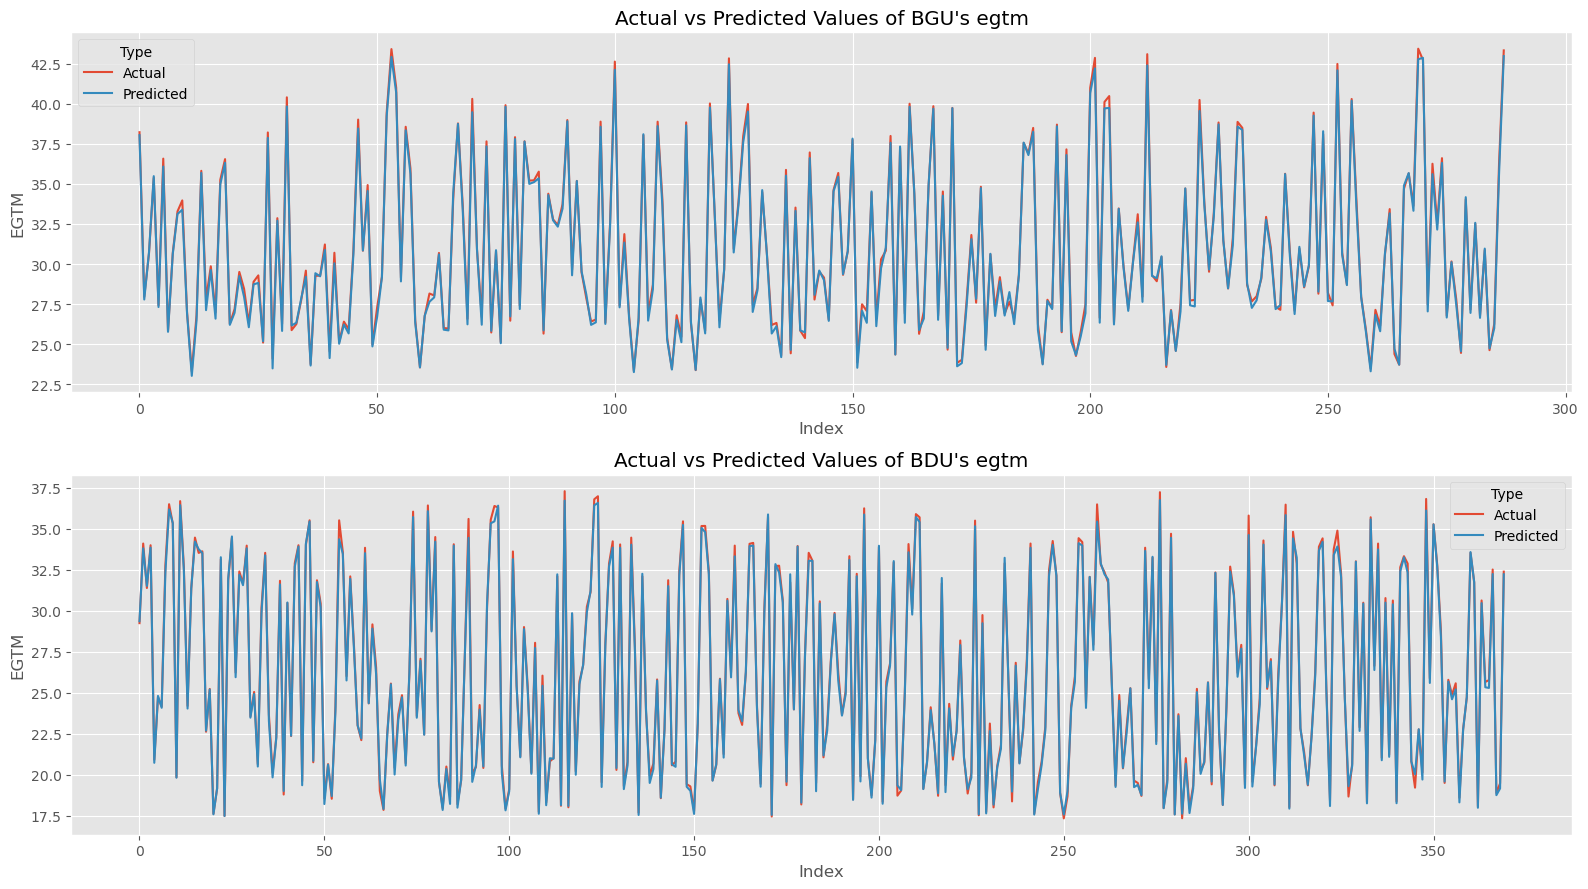

In [195]:
# Create DataFrames with the actual and predicted values
results_BGU_df = pd.DataFrame({
    'Actual': y_test_BGU,
    'Predicted': y_pred_BGU
}).reset_index(drop=True)

results_BDU_df = pd.DataFrame({
    'Actual': y_test_BDU,
    'Predicted': y_pred_BDU
}).reset_index(drop=True)

# Melt the DataFrames to long format for seaborn's relplot
results_BGU_long_df = results_BGU_df.melt(var_name='Type', value_name='EGTM', ignore_index=False).reset_index()
results_BDU_long_df = results_BDU_df.melt(var_name='Type', value_name='EGTM', ignore_index=False).reset_index()

# Create a figure with 16:4.5 aspect ratio
fig, axs = plt.subplots(2, 1, figsize=(16, 9))

# Plot the first subplot for BGU
sns.lineplot(data=results_BGU_long_df, x='index', y='EGTM', hue='Type', ax=axs[0])
axs[0].set_title("Actual vs Predicted Values of BGU's egtm")
axs[0].set_xlabel('Index')
axs[0].set_ylabel('EGTM')
axs[0].legend(title='Type')

# Plot the second subplot for BDU
sns.lineplot(data=results_BDU_long_df, x='index', y='EGTM', hue='Type', ax=axs[1])
axs[1].set_title("Actual vs Predicted Values of BDU's egtm")
axs[1].set_xlabel('Index')
axs[1].set_ylabel('EGTM')
axs[1].legend(title='Type')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()